# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

from collections import Counter

from sklearn.preprocessing import RobustScaler, OneHotEncoder

from sklearn.metrics import mean_squared_error, mean_absolute_error, silhouette_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.cluster import KMeans

In [2]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

In [3]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


periodo       fecha  hora_inicio  hora_fin     dia    estacion    sentido  \
0     2019  2019-01-01            0         1  Martes     Alberti     Centro   
1     2019  2019-01-01            0         1  Martes     Alberti     Centro   
2     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
3     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
4     2019  2019-01-01            0         1  Martes  Avellaneda     Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              22  
1       Liviano    TELEPASE               6  
2       Liviano  NO COBRADO              53  
3       Liviano    TELEPASE              18  
4       Liviano    EFECTIVO              16

In [4]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


periodo       fecha  hora_inicio  hora_fin    dia estacion sentido  \
0     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
1     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
2     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
3     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
4     2018  2018-01-01            2         3  Lunes  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              29  
1       Liviano    TELEPASE               9  
2       Liviano  NO COBRADO              73  
3       Liviano    TELEPASE              39  
4       Liviano  NO COBRADO             115

In [5]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


periodo       fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
1     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
2     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
3     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
4     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              25  
1       Liviano    TELEPASE               7  
2       Liviano  NO COBRADO               5  
3       Liviano    EFECTIVO               2  
4       Liviano    EFECTIVO              94

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [6]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [7]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [8]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [9]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

## Exploracion de los datasets

In [10]:
dataset = pd.concat([data_2019, data_2018, data_2017]).reset_index(drop = True)

In [11]:
#Paso a formato datetime el feature "fecha"
dataset["fecha"] = pd.to_datetime(dataset["fecha"])

In [12]:
#Unifico el tipo de pago de tarjeta de discapacidad, reemplazando la clasificacion vieja (2017 y 2018) con la mas reciente
ind_disc = dataset[dataset["forma_pago"] == "TARJETA DISCAPACIDAD"].index
dataset.loc[ind_disc,"forma_pago"] = "T. DISCAPACIDAD"

In [13]:
#Unifico la estacion de peaje Dellepiane
ind_della = dataset[dataset["estacion"].isin(['Dellepiane Centro', 'Dellepiane Liniers'])].index
dataset.loc[ind_della,"estacion"] = "Dellepiane"

In [14]:
#Corrijo la estacion de peaje Alberdi a Alberti
ind_della = dataset[dataset["estacion"] == "Alberdi"].index
dataset.loc[ind_della,"estacion"] = "Alberti"

In [15]:
#Agrupo y sumarizo todas las combinaciones categoricas respecto de "cantidad_pasos"
#Facilitará las visualizaciones y el tiempo de ejecución de cada una
flujo_peajes = dataset.groupby(by = ["periodo","estacion","sentido","tipo_vehiculo","forma_pago"])["cantidad_pasos"].sum()

In [16]:
flujo_peajes = flujo_peajes.reset_index()

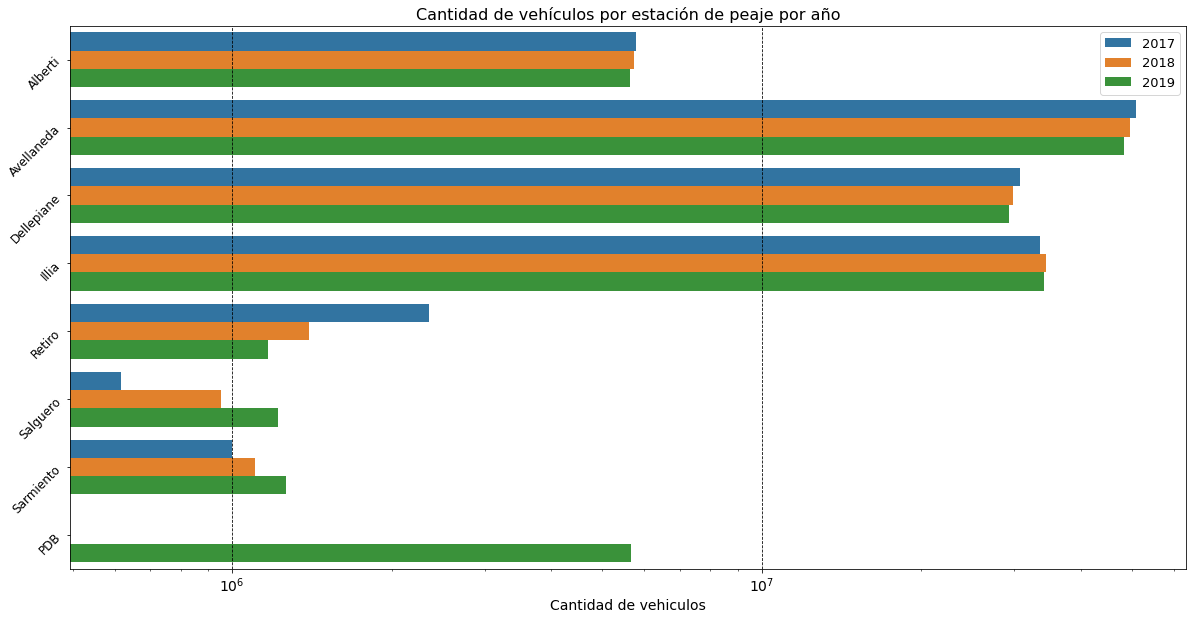

In [17]:
_ = plt.figure(figsize = (20,10))

_ = sns.barplot(data = flujo_peajes.groupby(by = ["periodo","estacion"])["cantidad_pasos"].sum().reset_index(), 
                x = "cantidad_pasos", 
                y = "estacion", 
                hue = "periodo")

_ = plt.title("Cantidad de vehículos por estación de peaje por año", 
              fontsize = 16)

_ = plt.ylabel("")
_ = plt.xlabel("Cantidad de vehiculos", 
               fontsize = 14)

_ = plt.yticks(fontsize = 12, rotation = 45)

_ = plt.xscale("log")
_ = plt.xticks(fontsize = 14 )

_ = plt.legend(loc =  "best", fontsize = 13)

_ = plt.grid(axis = "x", 
             c = "k", 
             linestyle = "--")

### Para destacar:

1. Tendencia decreciente:
* Alberti: consistente en los 3 años de analisis
* Avellaneda: consistente en los 3 años de analisis
* Dellepiene: consistente en los 3 años de analisis
* Illia: respecto al año anterior, pero mayor a 2017

2. Tendencia creciente:
* Salguero
* Sarmiento 

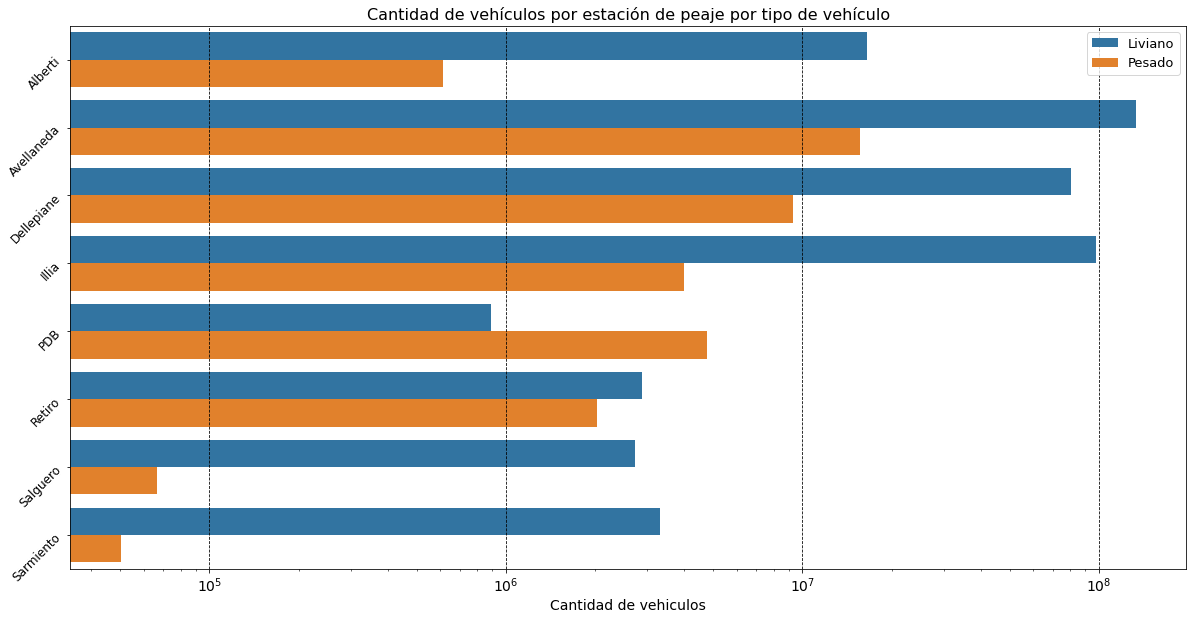

In [18]:
_ = plt.figure(figsize = (20,10))

_ = sns.barplot(data = flujo_peajes.groupby(by = ["tipo_vehiculo","estacion"])["cantidad_pasos"].sum().reset_index(), 
                x = "cantidad_pasos", 
                y = "estacion", 
                hue = "tipo_vehiculo")

_ = plt.title("Cantidad de vehículos por estación de peaje por tipo de vehículo", 
              fontsize = 16)

_ = plt.ylabel("")
_ = plt.xlabel("Cantidad de vehiculos", 
               fontsize = 14)

_ = plt.yticks(fontsize = 12, rotation = 45)

_ = plt.xscale("log")
_ = plt.xticks(fontsize = 14 )

_ = plt.legend(loc =  "best", fontsize = 13)

_ = plt.grid(axis = "x", 
             c = "k", 
             linestyle = "--")

### Para destacar:

En la mayoria de los peajes predomina el tipo de vehiculo LIVIANO, con excepcion del peaje PDB.

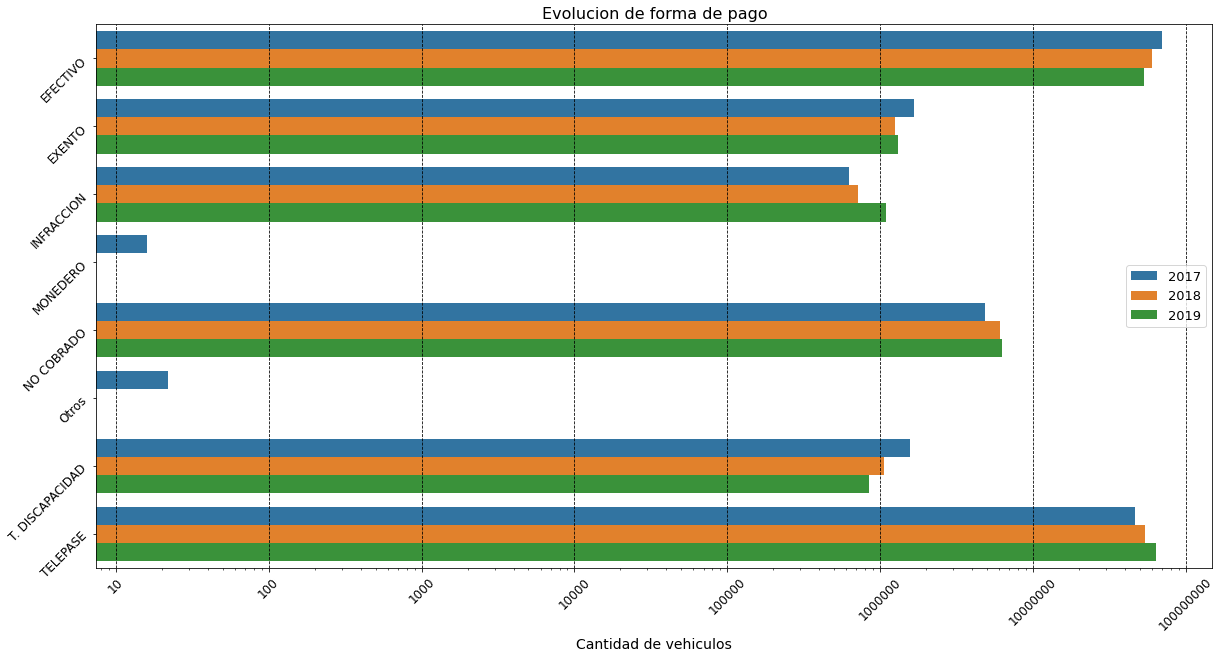

In [19]:
_ = plt.figure(figsize = (20,10))

_ = sns.barplot(data = flujo_peajes.groupby(by = ["periodo","forma_pago"])["cantidad_pasos"].sum().reset_index(), 
                x = "cantidad_pasos", 
                y = "forma_pago", 
                hue = "periodo")

_ = plt.title("Evolucion de forma de pago", 
              fontsize = 16)

_ = plt.ylabel("")
_ = plt.xlabel("Cantidad de vehiculos", 
               fontsize = 14)

_ = plt.yticks(fontsize = 12, rotation = 45)

_ = plt.xscale("log")
_ = plt.xticks([10**i for i in range(1,9)], 
               [str(10**i) for i in range(1,9)], 
               rotation = 45, fontsize = 12)


_ = plt.legend(loc =  "best", fontsize = 13)

_ = plt.grid(axis = "x", 
             c = "k", 
             linestyle = "--")

EFECTIVO y TELEPASE son los métodos de pagos mas frecuentes. Luego puede notarse:

1. Tendencia decreciente:
* EFECTIVO
* T. DISCAPACIDAD

2. Tendencia creciente:
* INFRACCION
* NO COBRADO
* TELEPASE

3. Categorias en desuso:
* Otros
* MONEDERO

4. Posibles movimientos/migraciones de formas de pago:
* EFECTIVO hacia TELEPASE
* T. DISCAPACIDAD hacia NO COBRADO o EXENTO

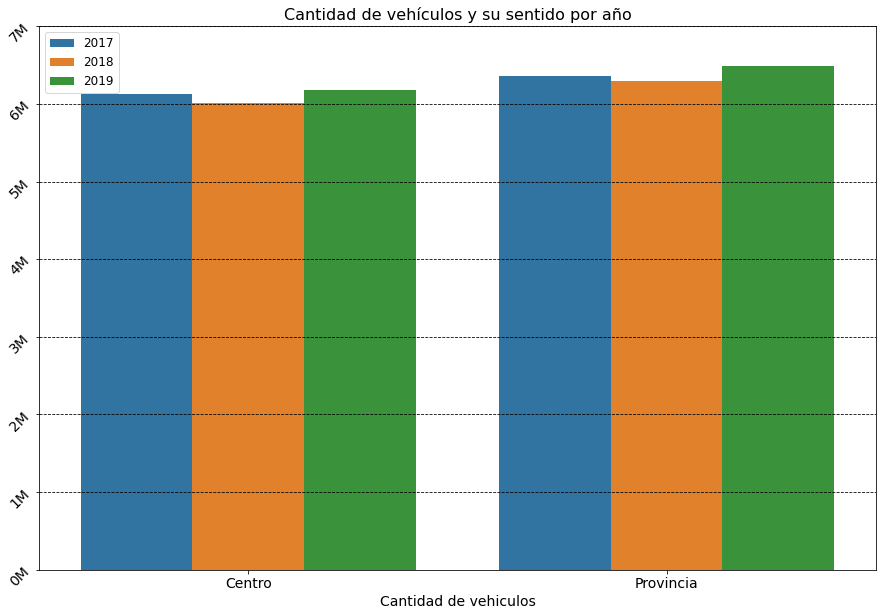

In [20]:
_ = plt.figure(figsize = (15,10))

_ = sns.barplot(data = flujo_peajes.groupby(by = ["periodo","sentido"])["cantidad_pasos"].sum().reset_index(), 
                y = "cantidad_pasos", 
                x = "sentido", 
                hue = "periodo")

_ = plt.title("Cantidad de vehículos y su sentido por año", 
              fontsize = 16)

_ = plt.ylabel("")
_ = plt.xlabel("Cantidad de vehiculos", 
               fontsize = 14)

_ = plt.yticks(fontsize = 12, rotation = 45)

_ = plt.yticks(range(0,8*10**7,10**7),
               [str(i) + "M" for i in range(0,8)],
               fontsize = 14 )

_ = plt.xticks(fontsize = 14)

_ = plt.legend(loc =  "best", fontsize = 12)

_ = plt.grid(axis = "y", 
             c = "k", 
             linestyle = "--")

* Podemos distinguir que el flujo a provincia es mayor que hacia el centro.
* Por otro lado, vemos que hay un descenso de circulación para el año 2018.

## Segmentación del proyecto:

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [21]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

fecha  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos
80   2019-01-01         2  Martes     Centro       Liviano             537
86   2019-01-01         2  Martes     Centro        Pesado               1
88   2019-01-01         2  Martes  Provincia       Liviano             443
94   2019-01-01         2  Martes  Provincia        Pesado               1
149  2019-01-01         3  Martes     Centro       Liviano             769

In [22]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos              fecha2
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [23]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [24]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
...         ...        ...           ...             ...                 ...
238864   Martes  Provincia       Liviano             556 2019-12-31 22:00:00
238865   Martes  Provincia        Pesado               1 2019-12-31 22:00:00
238866   Martes     Centro       Liviano             580 2019-12-31 22:00:00
238867   Martes     Centro       Liviano             214 2019-12-31 23:00:00
238868   Martes  Provincia       Liviano             190 2019-12-31 23:00:00

[238869 rows x 5 columns]

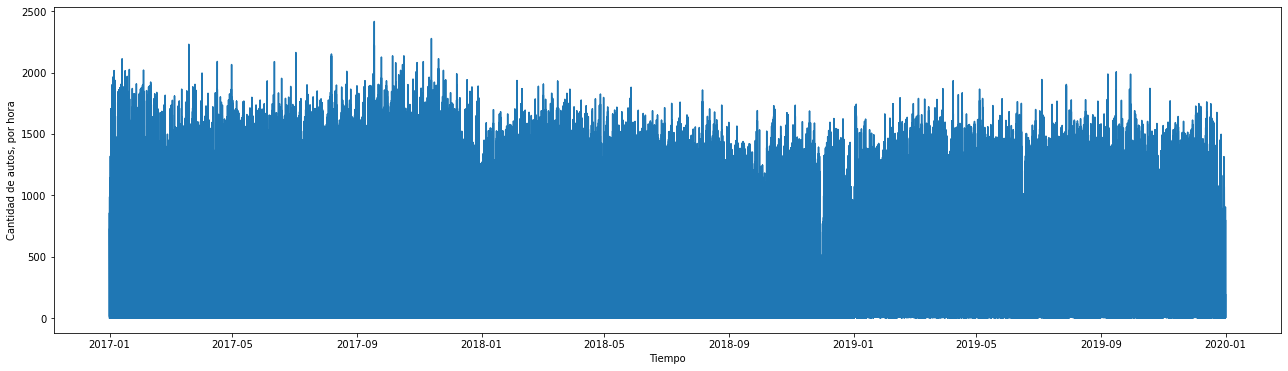

In [25]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (22,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [26]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


cantidad_pasos
fecha                     
2017-01-01           31183
2017-01-02           51568
2017-01-03           51093
2017-01-04           53332
2017-01-05           56486

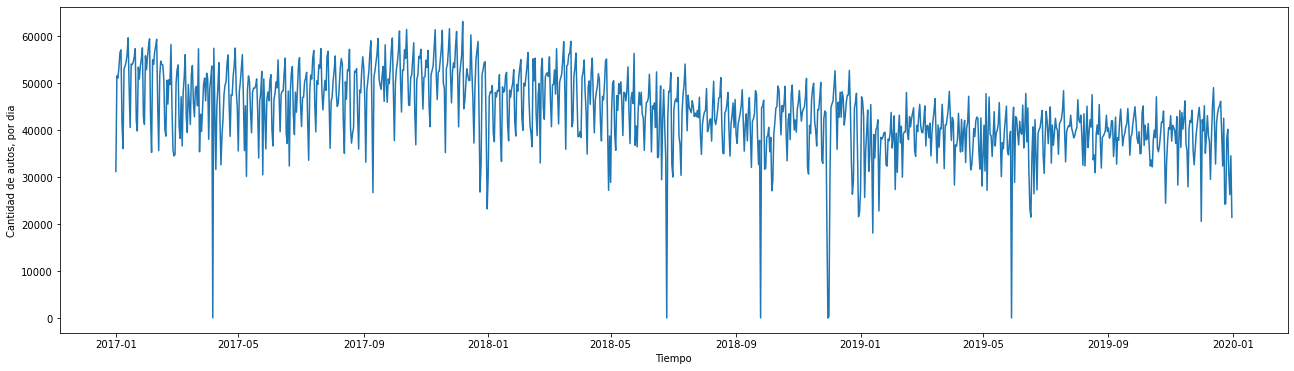

In [27]:
plt.figure(figsize = (22,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

### Preguntas
* Que dia de la semana tuvo mayor cantidad de autos para cada direccion?
* Cuantos autos pasaron por dia? y por hora?
* Que horarios son los mas congestionados para cada dia de la semana en promedio?

In [28]:
pivot_days = dataset.pivot_table(values = "cantidad_pasos",
                                 index = "dia",
                                 columns = "sentido",
                                 aggfunc = "sum")

pivot_days = pivot_days.reset_index()


In [29]:
print("Dia con mayor cantidad de autos hacia el Centro: ", pivot_days["dia"][pivot_days["Centro"] == pivot_days["Centro"].max()].values)
print("Dia con mayor cantidad de autos hacia Provincia: ", pivot_days["dia"][pivot_days["Provincia"] == pivot_days["Provincia"].max()].values)

Dia con mayor cantidad de autos hacia el Centro:  ['Viernes']
Dia con mayor cantidad de autos hacia Provincia:  ['Viernes']


In [30]:
order_days = ["Lunes","Martes","Miércoles","Jueves","Viernes","Sábado","Domingo"]

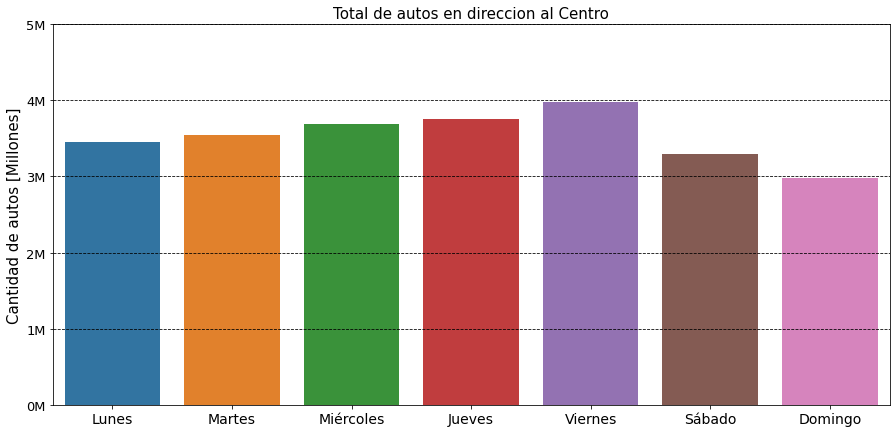

In [31]:
_ = plt.figure(figsize=(15,7))
_ = sns.barplot(data = pivot_days, y = "Centro", x = "dia", order = order_days)
_ = plt.title("Total de autos en direccion al Centro", fontsize=15)
_ = plt.xlabel("")
_ = plt.ylabel("Cantidad de autos [Millones]", fontsize=15)
_ = plt.xticks(fontsize=14)
_ = plt.yticks(range(0,6*10**6,10**6),
               [str(i) + "M" for i in range(0,6)], 
               fontsize=13)
_ = plt.grid(axis = "y", c = "k", linestyle = "--")

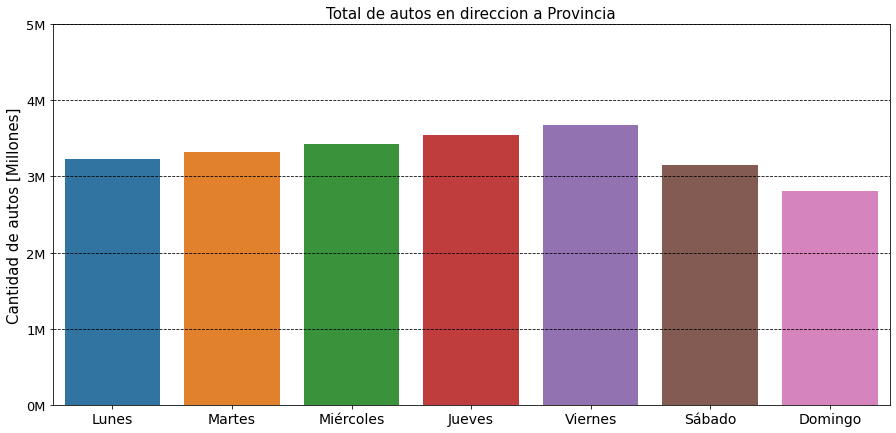

In [32]:
_ = plt.figure(figsize=(15,7))
_ = sns.barplot(data = pivot_days, y = "Provincia", x = "dia", order = order_days)
_ = plt.title("Total de autos en direccion a Provincia", fontsize=15)
_ = plt.xlabel("")
_ = plt.ylabel("Cantidad de autos [Millones]", fontsize=15)
_ = plt.xticks(fontsize=14)
_ = plt.yticks(range(0,6*10**6,10**6),
               [str(i) + "M" for i in range(0,6)], 
               fontsize=13)
_ = plt.grid(axis = "y", c = "k", linestyle = "--")

In [33]:
dataset["hour"] = dataset["fecha"].dt.hour
dataset

dia    sentido tipo_vehiculo  cantidad_pasos               fecha  \
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00   
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00   
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00   
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00   
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00   
...         ...        ...           ...             ...                 ...   
238864   Martes  Provincia       Liviano             556 2019-12-31 22:00:00   
238865   Martes  Provincia        Pesado               1 2019-12-31 22:00:00   
238866   Martes     Centro       Liviano             580 2019-12-31 22:00:00   
238867   Martes     Centro       Liviano             214 2019-12-31 23:00:00   
238868   Martes  Provincia       Liviano             190 2019-12-31 23:00:00   

        hour  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
238864    22  
238865    22  
238866    22  
238867    23  
238868    23  

[238869 rows x 6 columns]

In [34]:
pivot_hours = dataset.pivot_table(values = "cantidad_pasos",
                                  index = ["dia","hour"],
                                  columns = "sentido", 
                                  aggfunc = "sum")

pivot_hours = pivot_hours.reset_index()
pivot_hours.head()

sentido      dia  hour  Centro  Provincia
0        Domingo     0   91070      84433
1        Domingo     1   84397      90495
2        Domingo     2   75607      83329
3        Domingo     3   59124      67369
4        Domingo     4   40995      43223

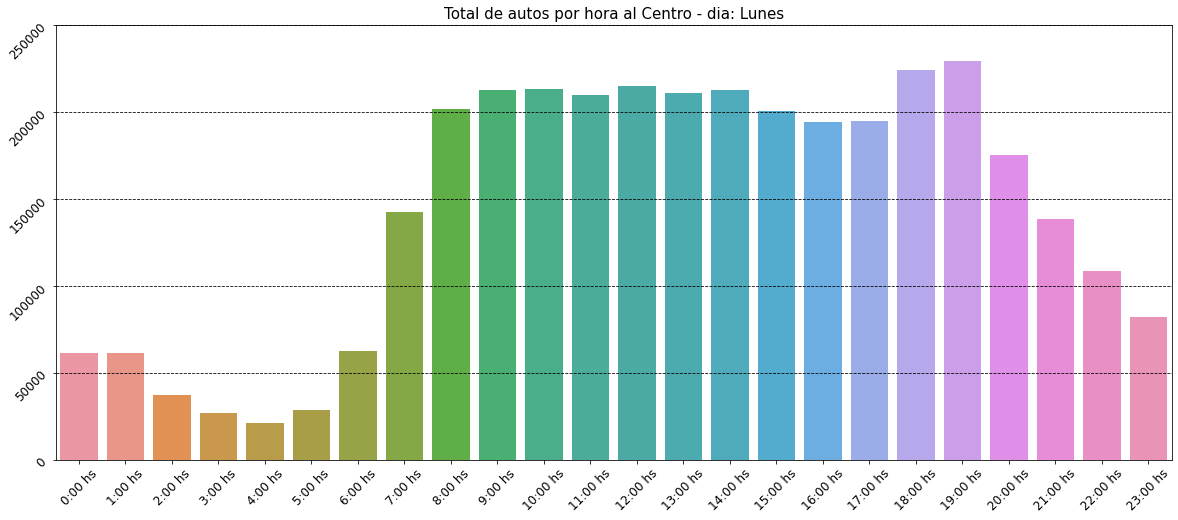

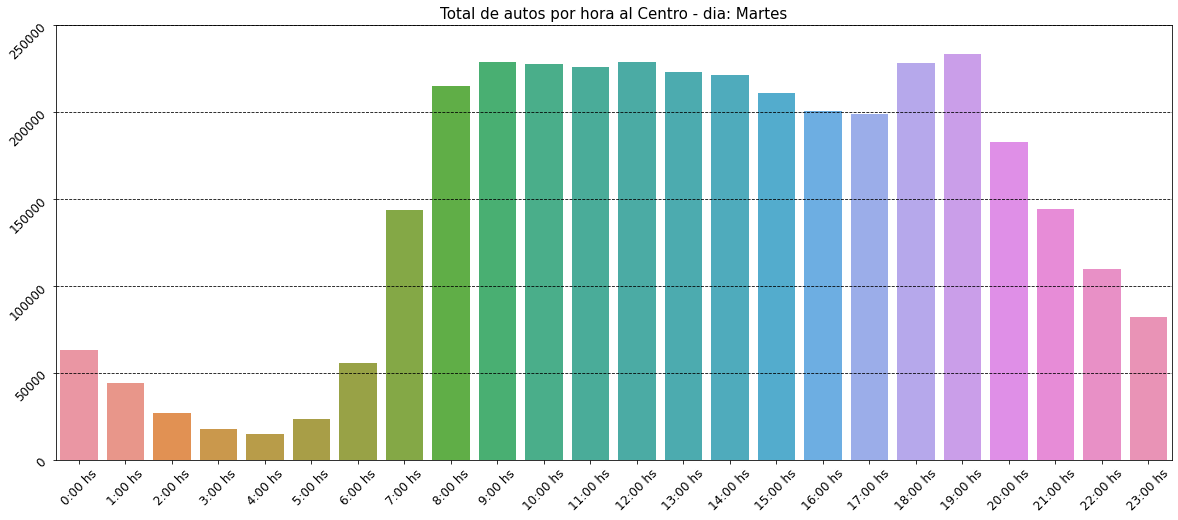

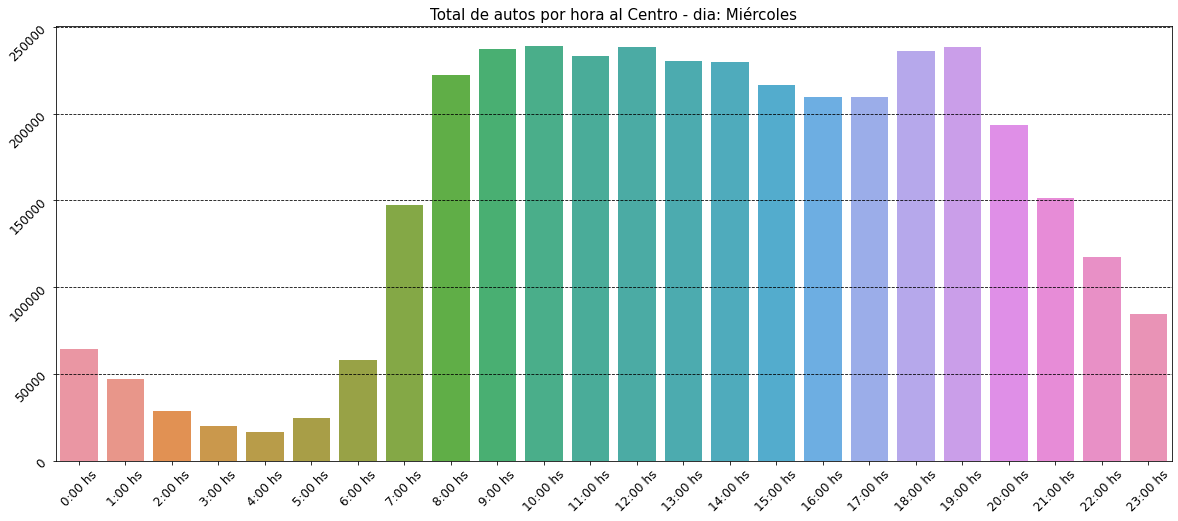

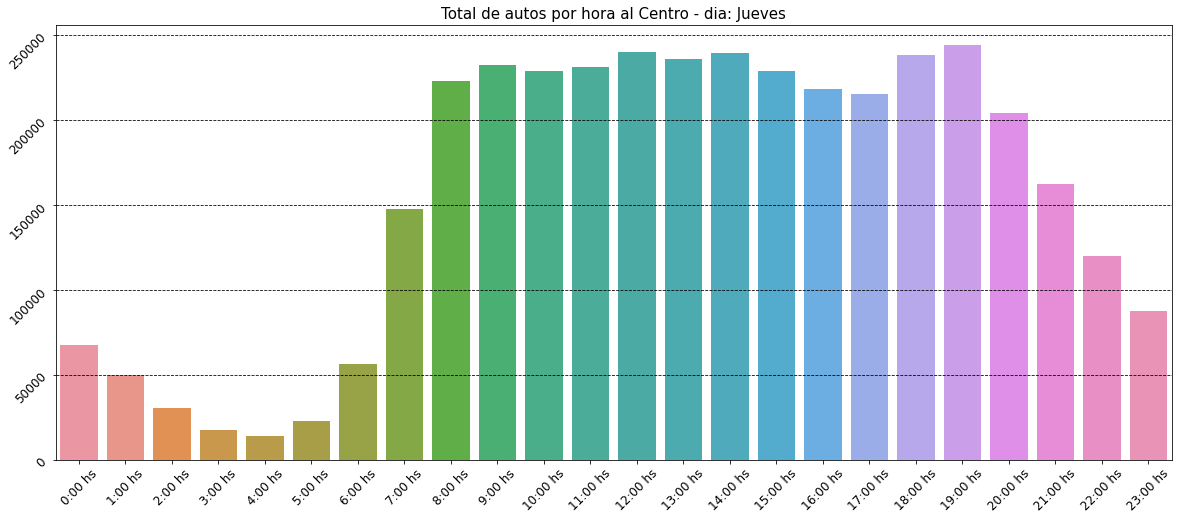

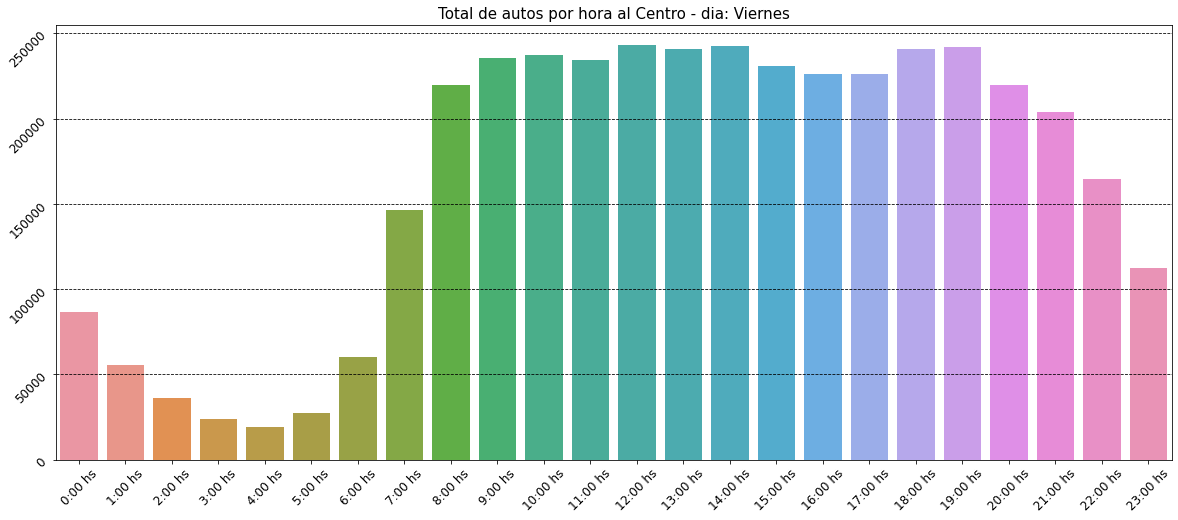

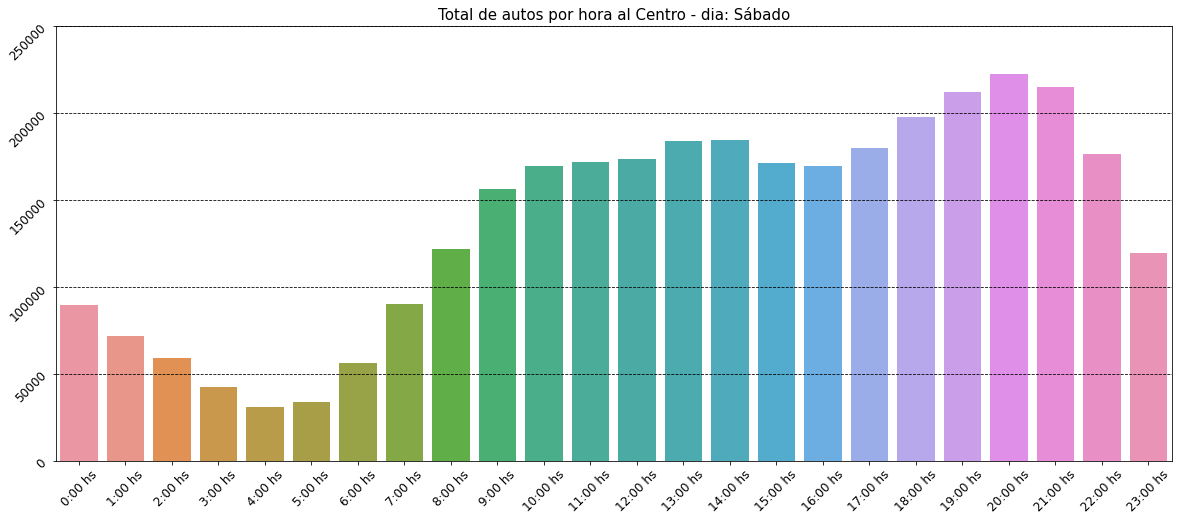

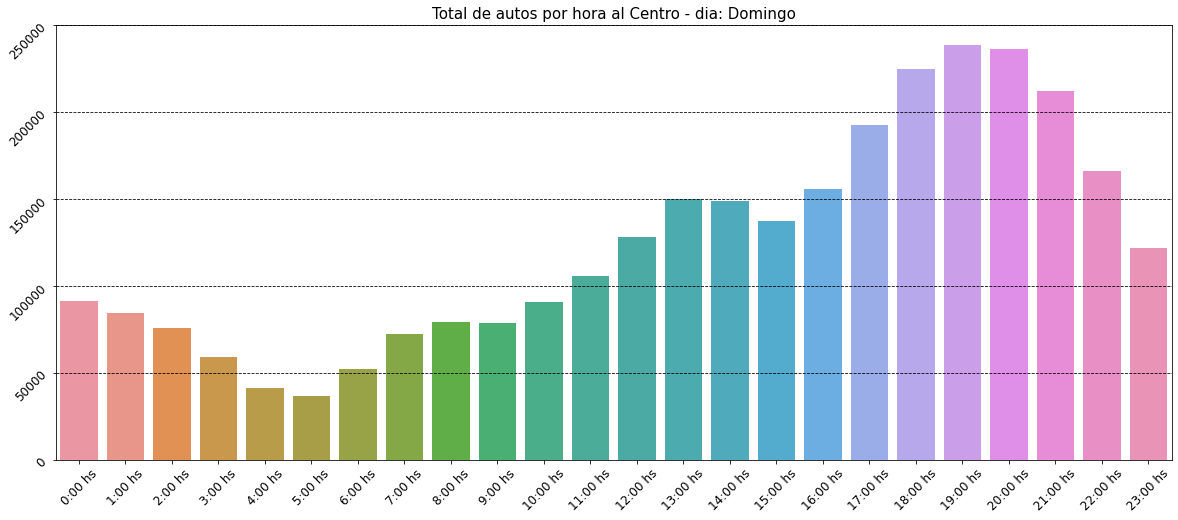

In [35]:
for dia in order_days:

    _ = plt.figure(figsize=(20,8))
    _ = sns.barplot(data = pivot_hours[pivot_hours["dia"] == dia], x = "hour", y = "Centro")
    _ = plt.title("Total de autos por hora al Centro - dia: " + dia, fontsize = 15)
    _ = plt.ylabel("")
    _ = plt.xlabel("")
    _ = plt.xticks(range(24),
                   [str(i) + ":00 hs" for i in range(24)],
                   rotation = 45,
                   fontsize = 12)
    _ = plt.yticks(range(0,3*10**5,5*10**4),
                   [str(i) for i in range(0,3*10**5,5*10**4)], 
                   rotation = 45, 
                   fontsize = 12)
    _ = plt.grid(axis = "y", c = "k", linestyle = "--")

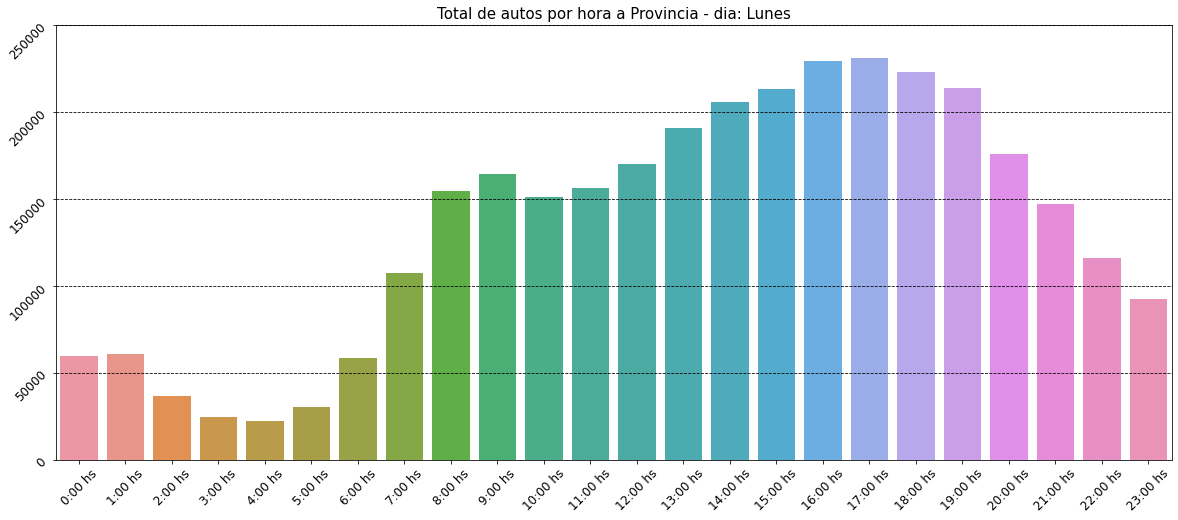

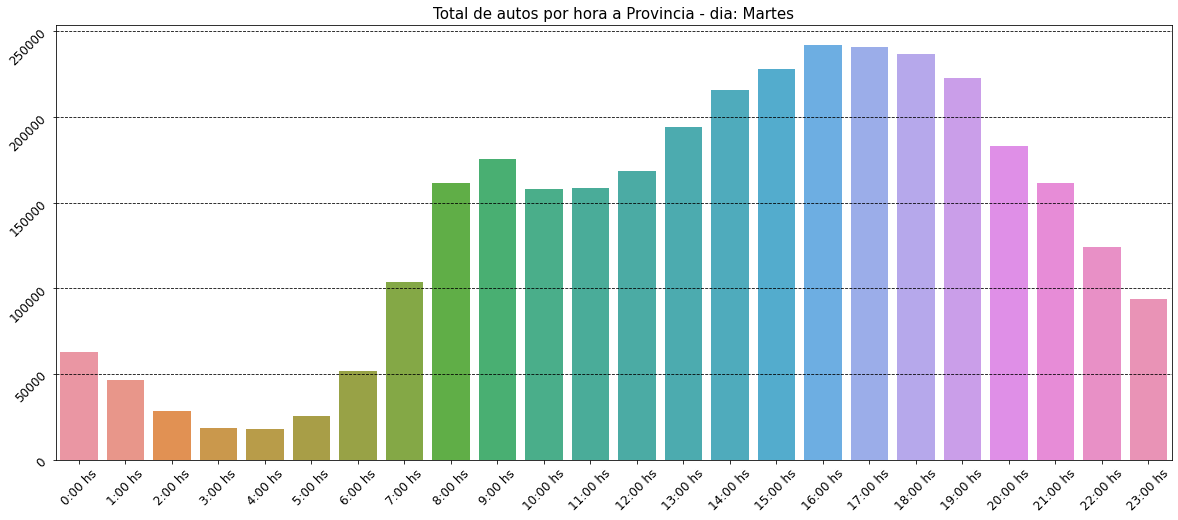

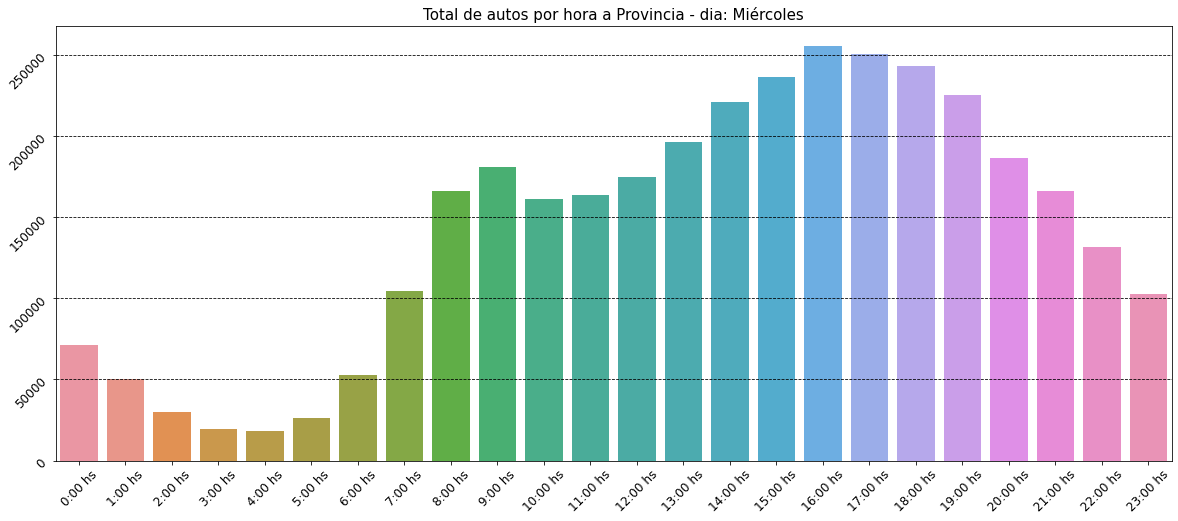

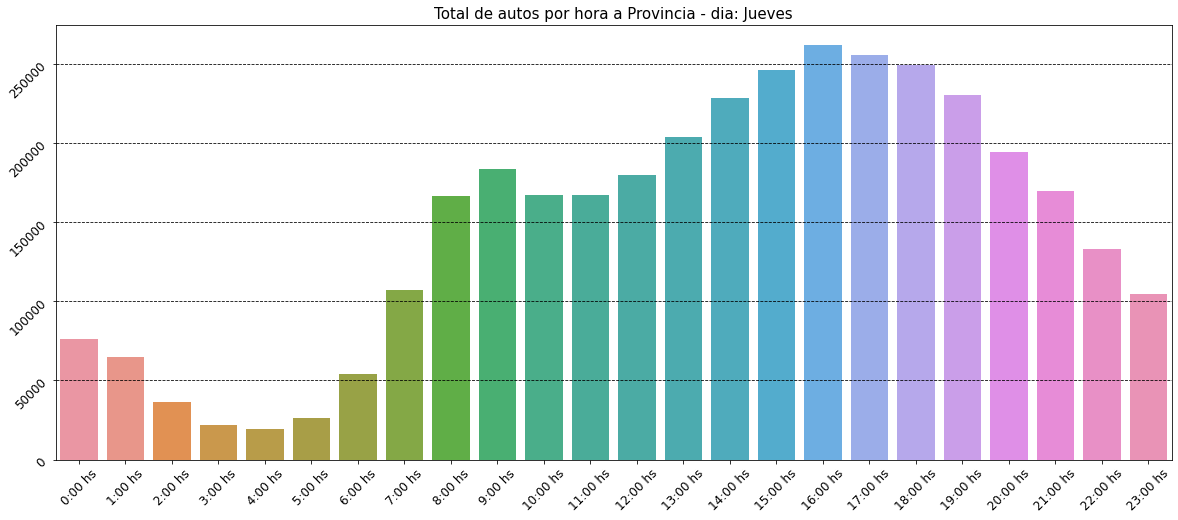

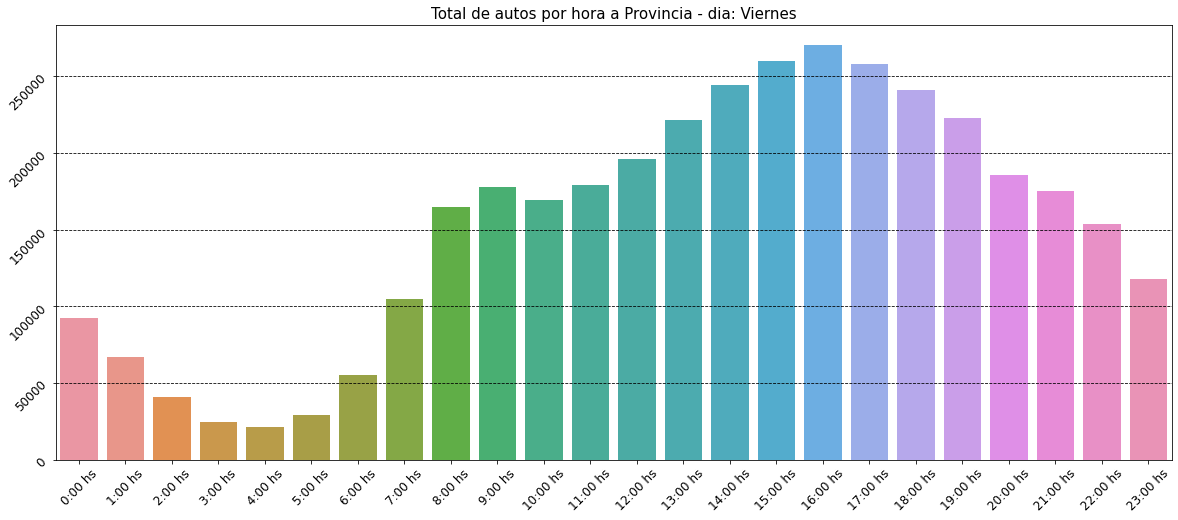

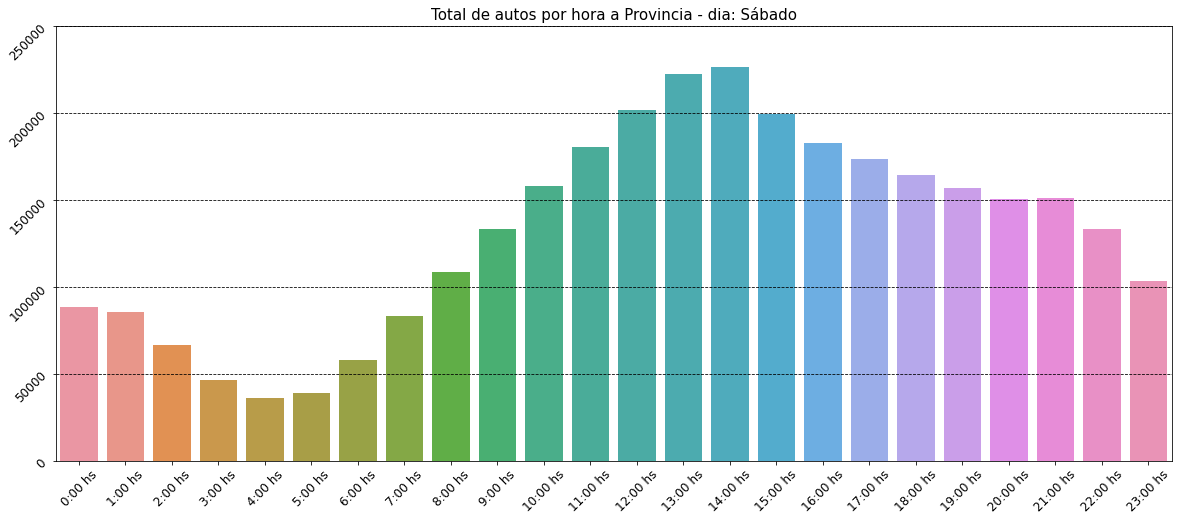

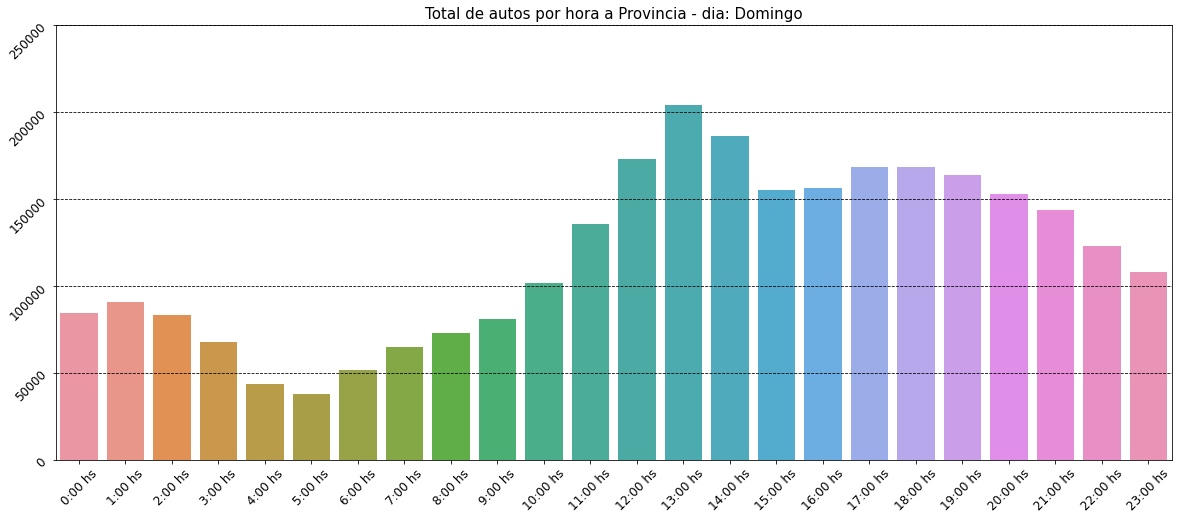

In [36]:
for dia in order_days:

    _ = plt.figure(figsize=(20,8))
    _ = sns.barplot(data = pivot_hours[pivot_hours["dia"] == dia], x = "hour", y = "Provincia")
    _ = plt.title("Total de autos por hora a Provincia - dia: " + dia, fontsize = 15)
    _ = plt.ylabel("")
    _ = plt.xlabel("")
    _ = plt.xticks(range(24),
                   [str(i) + ":00 hs" for i in range(24)],
                   rotation = 45,
                   fontsize = 12)
    _ = plt.yticks(range(0,3*10**5,5*10**4),
                   [str(i) for i in range(0,3*10**5,5*10**4)], 
                   rotation = 45, 
                   fontsize = 12)
    _ = plt.grid(axis = "y", c = "k", linestyle = "--")

In [37]:
trafico_prom = dataset.groupby(["sentido","dia","hour"])["cantidad_pasos"].agg("mean")
trafico_prom = trafico_prom.reset_index()

In [38]:
trafico_prom.head()

sentido      dia  hour  cantidad_pasos
0  Centro  Domingo     0      127.015342
1  Centro  Domingo     1      134.390127
2  Centro  Domingo     2      124.970248
3  Centro  Domingo     3       97.403624
4  Centro  Domingo     4       69.957338

In [39]:
trafico_prom_centro = trafico_prom[trafico_prom["sentido"] == "Centro"][["dia","hour","cantidad_pasos"]]

In [40]:
heat_centro = trafico_prom_centro.pivot_table(values="cantidad_pasos", index = "dia", columns="hour").loc[order_days]
heat_centro.head(7)

hour               0           1           2          3          4   \
dia                                                                   
Lunes       85.977560   87.745690   54.992560  41.655864  31.818043   
Martes      89.395448   65.046062   40.016616  28.131621  23.196875   
Miércoles   90.196906   66.115331   41.565982  31.913183  26.637380   
Jueves      92.743132   71.496423   44.510294  27.548031  21.738654   
Viernes    123.209700   78.168317   52.510116  37.149923  30.549606   
Sábado     140.100000  105.960177   85.406386  66.131661  47.027692   
Domingo    127.015342  134.390127  124.970248  97.403624  69.957338   

hour              5          6           7           8           9   ...  \
dia                                                                  ...   
Lunes      42.654135  86.361111  175.835600  262.208062  266.120301  ...   
Martes     35.726300  76.245879  175.479853  273.635669  289.972117  ...   
Miércoles  35.836257  79.589532  172.377778  266.860911  297.229036  ...   
Jueves     34.934451  76.906849  173.762073  277.225124  286.210332  ...   
Viernes    40.845577  82.986264  177.278788  277.660354  293.280199  ...   
Sábado     52.353941  80.496413  115.106003  158.027273  200.229487  ...   
Domingo    61.663317  83.769726  110.372129  115.187228  116.633929  ...   

hour               14          15          16          17          18  \
dia                                                                     
Lunes      257.133172  246.664207  229.057920  237.282582  275.798030   
Martes     265.013174  258.739877  237.648104  240.228537  276.290909   
Miércoles  264.861751  249.612457  238.380682  244.822637  280.182898   
Jueves     277.580533  267.453801  250.823192  252.505275  288.707022   
Viernes    276.038724  261.657596  258.822451  260.639401  290.304819   
Sábado     232.496847  225.961691  218.106959  236.146982  249.910127   
Domingo    201.914402  187.369210  205.819022  244.228426  288.391026   

hour               19          20          21          22          23  
dia                                                                    
Lunes      283.530941  228.246415  184.046667  147.482289  113.013812  
Martes     289.143921  234.066667  187.848564  151.013812  118.265896  
Miércoles  296.042184  242.171464  198.445026  158.342318  118.008380  
Jueves     295.758788  255.872340  216.684000  164.867950  122.206128  
Viernes    296.244798  275.761606  264.454663  223.067751  158.304225  
Sábado     276.653595  289.083225  289.662618  261.339259  181.654490  
Domingo    312.893701  308.716340  273.866925  229.265193  170.255230  

[7 rows x 24 columns]

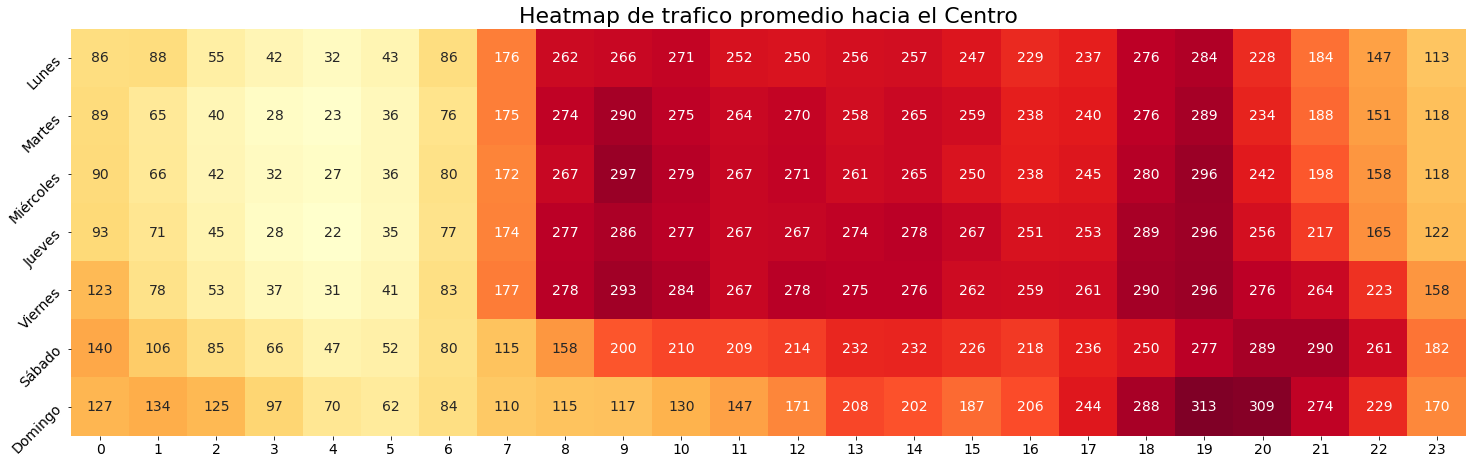

In [41]:
#Heatmap cantidad de autos promedio por rango horario para cada dia de la semana

_ = plt.figure(figsize=(25,11))

_ = sns.heatmap(heat_centro, 
                cbar = False, 
                square = True, 
                annot=True,
                fmt= '.0f', 
                annot_kws={'size': 14},
                cmap= 'YlOrRd')

_ = plt.xlabel("")
_ = plt.ylabel("")
_ = plt.xticks(fontsize=14)
_ = plt.yticks(rotation = 45, fontsize=14)
_ = plt.title("Heatmap de trafico promedio hacia el Centro", fontsize = 22)


In [42]:
trafico_prom_pcia = trafico_prom[trafico_prom["sentido"] == "Provincia"][["dia","hour","cantidad_pasos"]]

In [43]:
heat_pcia = trafico_prom_pcia.pivot_table(values="cantidad_pasos", index = "dia", columns="hour").loc[order_days]
heat_pcia.head(7)

hour               0           1           2           3          4   \
dia                                                                    
Lunes       96.347403  105.351211   66.030631   45.581784  40.602941   
Martes     104.127273   81.331579   50.277087   33.928309  33.276438   
Miércoles  112.196850   89.028219   54.055856   35.305054  33.182815   
Jueves     120.573016  109.641892   63.469459   39.960000  35.675373   
Viernes    143.683801  108.398058   71.467487   41.567521  38.214669   
Sábado     148.668919  144.692568  112.399323   81.545614  62.578671   
Domingo    135.309295  157.109375  147.746454  120.301786  83.928155   

hour              5          6           7           8           9   ...  \
dia                                                                  ...   
Lunes      55.820370  99.930153  172.300161  226.419971  242.256637  ...   
Martes     46.502712  86.818487  152.417404  224.052778  247.078873  ...   
Miércoles  46.755396  88.269360  160.208909  237.281831  263.759475  ...   
Jueves     46.922261  91.219224  161.031627  233.505602  260.303977  ...   
Viernes    50.534602  91.581126  158.457576  227.506207  251.651558  ...   
Sábado     70.157040  94.791461  132.068146  158.016035  180.039295  ...   
Domingo    74.314961  98.062738  112.998258  119.569079  128.426984  ...   

hour               14          15          16          17          18  \
dia                                                                     
Lunes      282.469780  289.519022  309.920162  315.408470  316.326241   
Martes     301.518156  307.431267  325.283984  328.271487  337.358060   
Miércoles  294.394667  313.615385  336.956407  329.694335  337.622222   
Jueves     302.373510  321.138381  344.607378  346.590231  348.163408   
Viernes    326.477971  344.861886  348.164948  345.062918  331.009615   
Sábado     332.935199  287.767677  266.443796  247.912732  236.829971   
Domingo    283.382622  228.602659  226.627907  245.880117  242.754690   

hour               19          20          21          22          23  
dia                                                                    
Lunes      300.243319  255.074020  220.089955  176.873476  143.575428  
Martes     314.173484  262.163090  243.432229  184.977645  143.559633  
Miércoles  316.057584  269.640580  247.374627  195.983607  152.873134  
Jueves     322.830295  279.218705  250.156573  202.065250  163.097978  
Viernes    303.903270  261.139241  258.442478  236.442219  179.681402  
Sábado     226.395080  234.300156  236.352665  218.912829  166.684380  
Domingo    238.581633  226.445104  219.865237  185.596970  162.286787  

[7 rows x 24 columns]

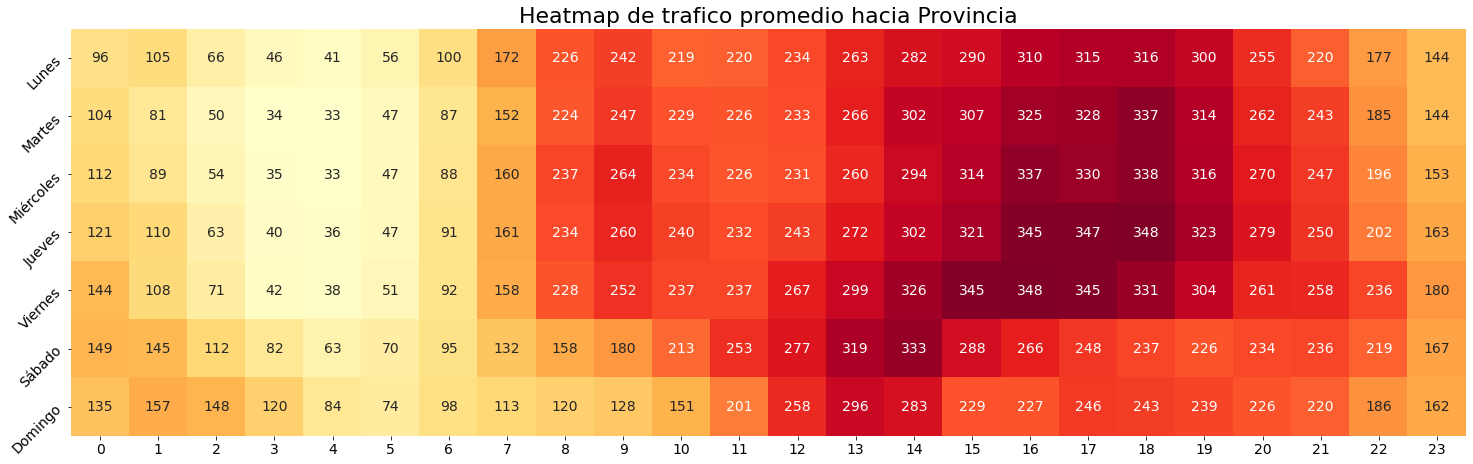

In [44]:
#Heatmap cantidad de autos promedio por rango horario para cada dia de la semana

_ = plt.figure(figsize=(25,11))

_ = sns.heatmap(heat_pcia, 
                cbar = False, 
                square = True, 
                annot=True,
                fmt= '.0f', 
                annot_kws={'size': 14},
                cmap= 'YlOrRd')

_ = plt.xlabel("")
_ = plt.ylabel("")
_ = plt.xticks(fontsize=14)
_ = plt.yticks(rotation = 45, fontsize=14)
_ = plt.title("Heatmap de trafico promedio hacia Provincia", fontsize = 22)


In [45]:
dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos      fecha  hour
0  Domingo  Provincia        Pesado               1 2017-01-01     0
1  Domingo  Provincia       Liviano               9 2017-01-01     0
2  Domingo  Provincia       Liviano             644 2017-01-01     0
3  Domingo  Provincia        Pesado               6 2017-01-01     0
4  Domingo  Provincia        Pesado               1 2017-01-01     0

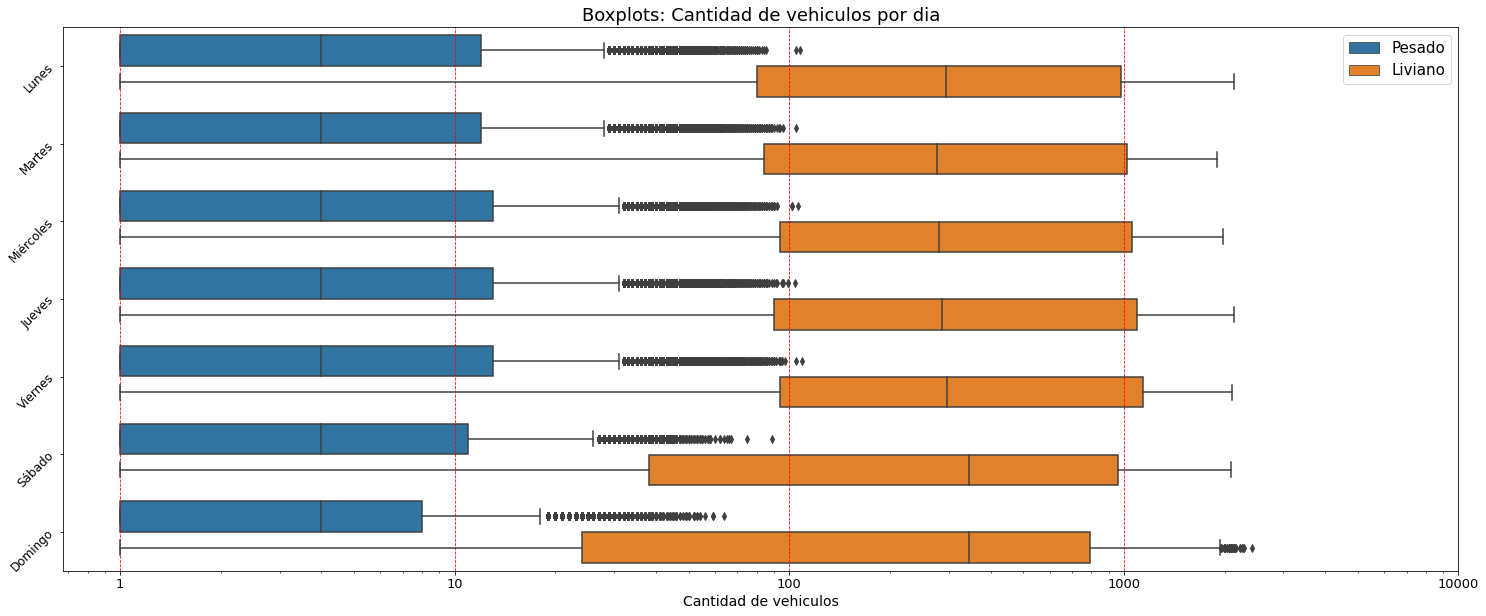

In [46]:
_ = plt.figure(figsize = (25,10))

_ = sns.boxplot(data = dataset,
                y = "dia", 
                x = "cantidad_pasos", 
                order = order_days, 
                hue= "tipo_vehiculo")

_ = plt.title("Boxplots: Cantidad de vehiculos por dia", 
              fontsize=18)

_ = plt.ylabel("")

_ = plt.xlabel("Cantidad de vehiculos", 
               fontsize = 14)

_ = plt.xscale("log")

_ = plt.xticks(tuple(10**i for i in range(5)),
               [str(10**i) for i in range(5)],
               fontsize = 13)

_ = plt.yticks(fontsize = 12, 
               rotation = 45)

_ = plt.legend(fontsize = 15)

_ = plt.grid(axis="x",
             c = "r",
             linestyle = "--")

### Modifico escalas para mejorar la visualizacion para cada tipo de vehiculo

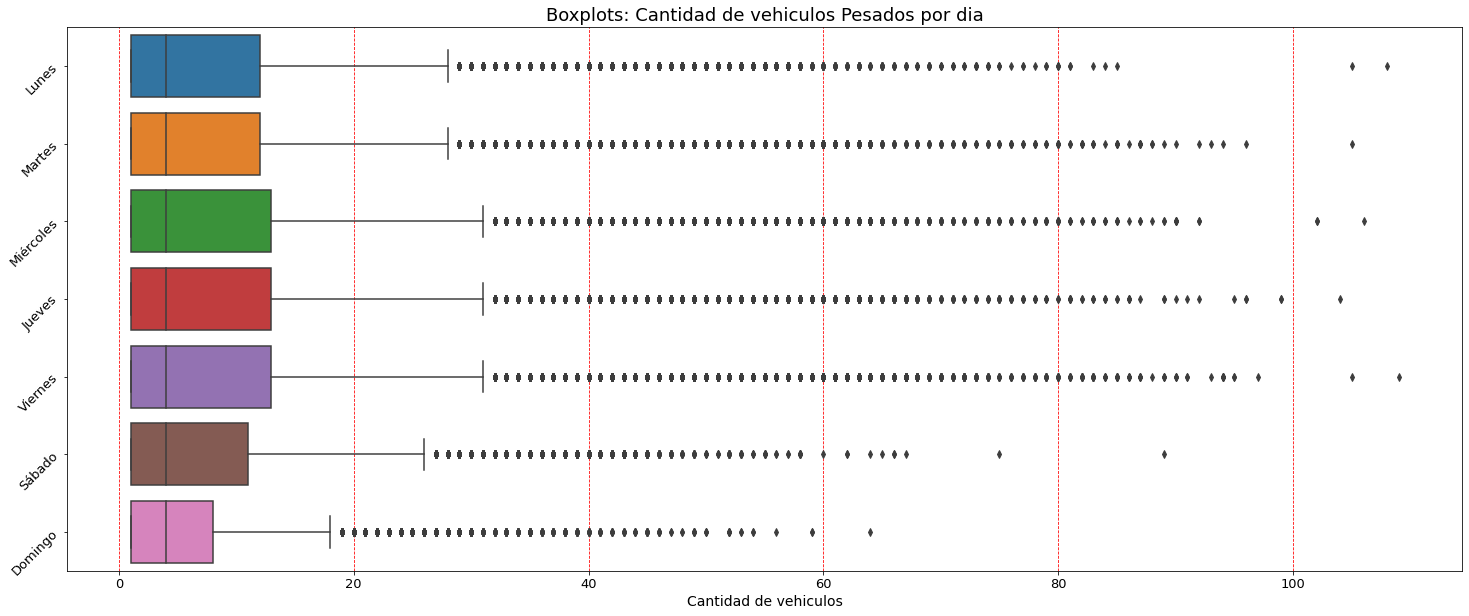

In [47]:
_ = plt.figure(figsize = (25,10))

_ = sns.boxplot(data = dataset[dataset["tipo_vehiculo"] == "Pesado"],
                y = "dia", 
                x = "cantidad_pasos", 
                order = order_days) 

_ = plt.title("Boxplots: Cantidad de vehiculos Pesados por dia", 
              fontsize=18)

_ = plt.ylabel("")

_ = plt.xlabel("Cantidad de vehiculos", 
               fontsize = 14)

_ = plt.xticks(fontsize = 13)

_ = plt.yticks(fontsize = 13, 
               rotation = 45)

_ = plt.grid(axis="x",
             c = "r",
             linestyle = "--")

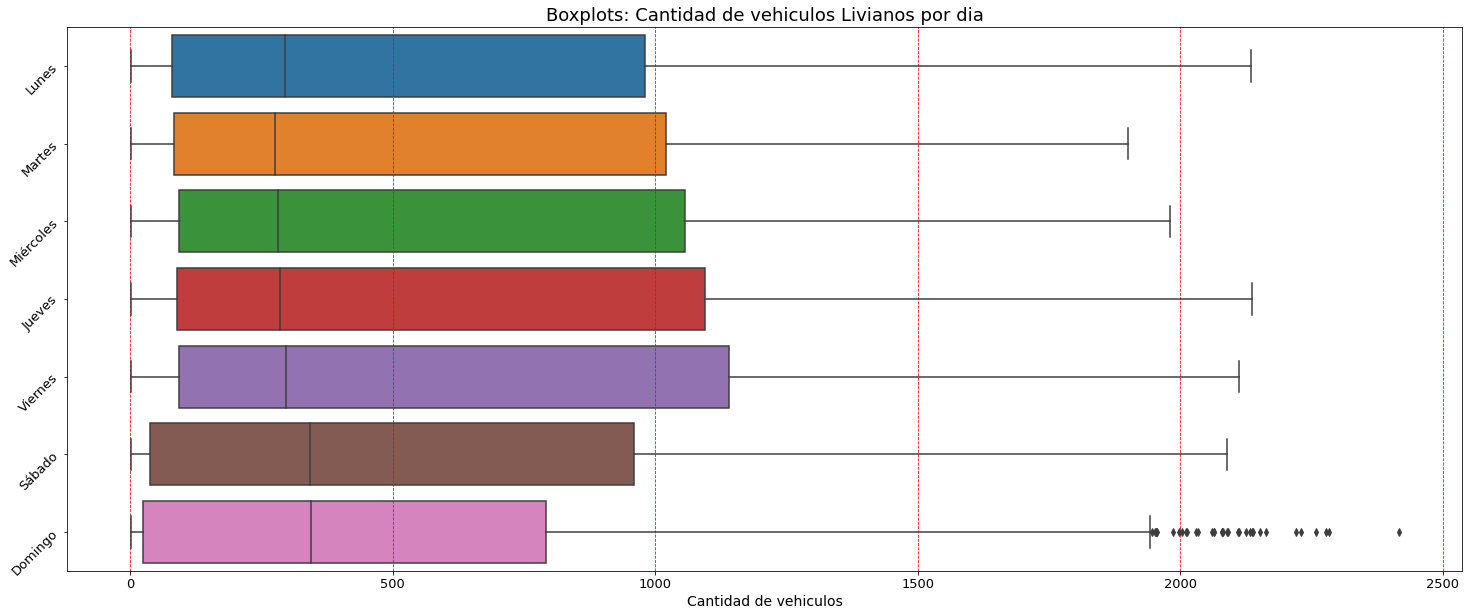

In [48]:
_ = plt.figure(figsize = (25,10))

_ = sns.boxplot(data = dataset[dataset["tipo_vehiculo"] == "Liviano"],
                y = "dia", 
                x = "cantidad_pasos", 
                order = order_days) 

_ = plt.title("Boxplots: Cantidad de vehiculos Livianos por dia", 
              fontsize=18)

_ = plt.ylabel("")

_ = plt.xlabel("Cantidad de vehiculos", 
               fontsize = 14)

_ = plt.xticks(fontsize = 13)

_ = plt.yticks(fontsize = 13, 
               rotation = 45)

_ = plt.grid(axis="x",
             c = "r",
             linestyle = "--")

## Valores faltantes

In [49]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238869 entries, 0 to 238868
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   dia             238869 non-null  object        
 1   sentido         238869 non-null  object        
 2   tipo_vehiculo   238869 non-null  object        
 3   cantidad_pasos  238869 non-null  int64         
 4   fecha           238869 non-null  datetime64[ns]
 5   hour            238869 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 10.9+ MB


A primera vista podríamos pensar que no hay valores faltantes en los atributos del dataset. Sin embargo, podría suceder que las fechas no contengan el calendario completo de los 3 años en estudio. Por este motivo, comparo a continuación las fechas disponibles en el dataset contra el calendario completo.

In [50]:
dataset["fecha"] = dataset["fecha"].dt.normalize()

In [51]:
dataset.head(1).append(dataset.tail(1))

dia    sentido tipo_vehiculo  cantidad_pasos      fecha  hour
0       Domingo  Provincia        Pesado               1 2017-01-01     0
238868   Martes  Provincia       Liviano             190 2019-12-31    23

In [52]:
# Construccion del calendario completo
calendario_completo = pd.Series(pd.date_range(start = "2017-01-01",
                                              end = "2019-12-31", 
                                              freq = "D"))

In [53]:
calendario_completo.shape[0] - len(dataset.fecha.unique())

4

### Faltan 4 fechas. Cuáles son? Pasó algo en particular ese dia?

In [54]:
# Convierto a tipo set el calendario completo y los valores unicos de las fechas del dataset

set_completo = set(calendario_completo.unique())
set_dataset = set(dataset.fecha.unique())

In [55]:
# Aplico diferencia de conjuntos para obtener las fechas faltantes
dias_faltantes = list(set_completo - set_dataset)

In [56]:
print("LOS DIAS FALTANTES SON:")
for i,j in enumerate(dias_faltantes):
    print(str(pd.to_datetime(dias_faltantes[i]).date()))

LOS DIAS FALTANTES SON:
2018-09-25
2019-05-29
2018-11-30
2018-06-25


2018-06-25: PARO GENERAL CGT

https://www.telam.com.ar/notas/201806/289299-la-cgt-dispuso-un-paro-nacional-para-el-lunes-25-de-junio-sin-movilizacion.html

2018-09-25: PARO GENERAL CGT

https://www.infobae.com/politica/2018/08/29/la-cgt-anuncio-un-paro-general-para-el-25-de-septiembre/

2018-11-30: Por la Cumbre del G-20 el 30 de noviembre fue feriado en la Ciudad de Buenos Aires

https://www.argentina.gob.ar/noticias/por-la-cumbre-del-g-20-el-30-de-noviembre-sera-feriado-en-la-ciudad-de-buenos-aires

2019-05-29: HUELGA GENERAL

https://elpais.com/internacional/2019/05/29/argentina/1559153842_024679.html

## Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

In [57]:
### Resampleo a frecuencia semanal el dataset

semanal = dataset[["fecha","cantidad_pasos"]].resample('W', on = 'fecha').sum()
semanal["fecha_num"] = semanal.index.map(dt.datetime.toordinal)
semanal.head(3).append(semanal.tail(3))

cantidad_pasos  fecha_num
fecha                                
2017-01-01           31183     736330
2017-01-08          347212     736337
2017-01-15          366413     736344
2019-12-22          292881     737415
2019-12-29          226390     737422
2020-01-05           55970     737429

In [58]:
lr = LinearRegression()
lr.fit(semanal.fecha_num.values.reshape(-1, 1), semanal.cantidad_pasos)

LinearRegression()

#### Rolling window - 4 semanas

Lo cual representa un barrido de un mes aproximadamente

In [59]:
semanal_promedio_tendencia = semanal.cantidad_pasos.rolling(window=4, center = True).mean()
semanal_promedio_tendencia

fecha
2017-01-01          NaN
2017-01-08          NaN
2017-01-15    275505.75
2017-01-22    356355.25
2017-01-29    359402.50
                ...    
2019-12-08    271726.50
2019-12-15    278821.75
2019-12-22    268780.50
2019-12-29    212050.25
2020-01-05          NaN
Freq: W-SUN, Name: cantidad_pasos, Length: 158, dtype: float64

In [60]:
q25,q75 = np.percentile(semanal.cantidad_pasos, [25 ,75])
iqr = q75 - q25

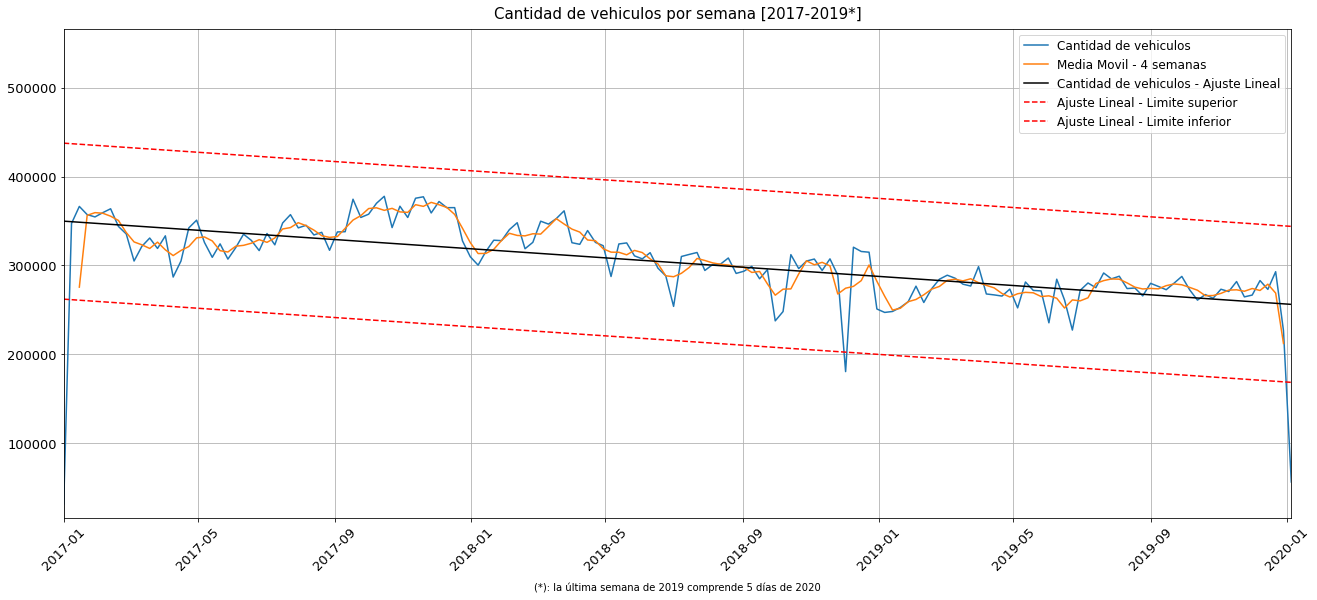

In [61]:
_ = plt.figure(figsize = (22,9))

_ = plt.plot(semanal.index,
             semanal.cantidad_pasos, 
             label = "Cantidad de vehiculos")

_ = plt.plot(semanal_promedio_tendencia,
             label = "Media Movil - 4 semanas")

_ = plt.plot(semanal.index, 
             lr.predict(semanal.fecha_num.values.reshape(-1, 1)),
             c = "k",
             label = "Cantidad de vehiculos - Ajuste Lineal")

_ = plt.plot(semanal.index, 
             lr.predict(semanal.fecha_num.values.reshape(-1, 1)) + 1.5 * iqr,
             ls = "--",
             c = "r",
             label = "Ajuste Lineal - Limite superior")

_ = plt.plot(semanal.index, 
             lr.predict(semanal.fecha_num.values.reshape(-1, 1)) - 1.5 * iqr,
             ls = "--",
             c = "r",
             label = "Ajuste Lineal - Limite inferior")


_ = plt.title("Cantidad de vehiculos por semana [2017-2019*]", 
              fontsize = 15, 
              pad = 10)

_ = plt.xlabel("(*): la última semana de 2019 comprende 5 días de 2020",
               labelpad = 10)

_ = plt.ylabel("")

_ = plt.yticks(fontsize = 13)

_ = plt.xticks(fontsize = 13,
               rotation = 45)

_ = plt.xlim(dt.date(2017,1,1),
             dt.date(2020,1,5))

_ = plt.ylim(semanal.cantidad_pasos.min()*0.5,
             semanal.cantidad_pasos.max()*1.5)

_ = plt.grid(axis = "both")

_ = plt.legend(fontsize = 12)

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [63]:
result = seasonal_decompose(semanal.cantidad_pasos, model = 'additive')

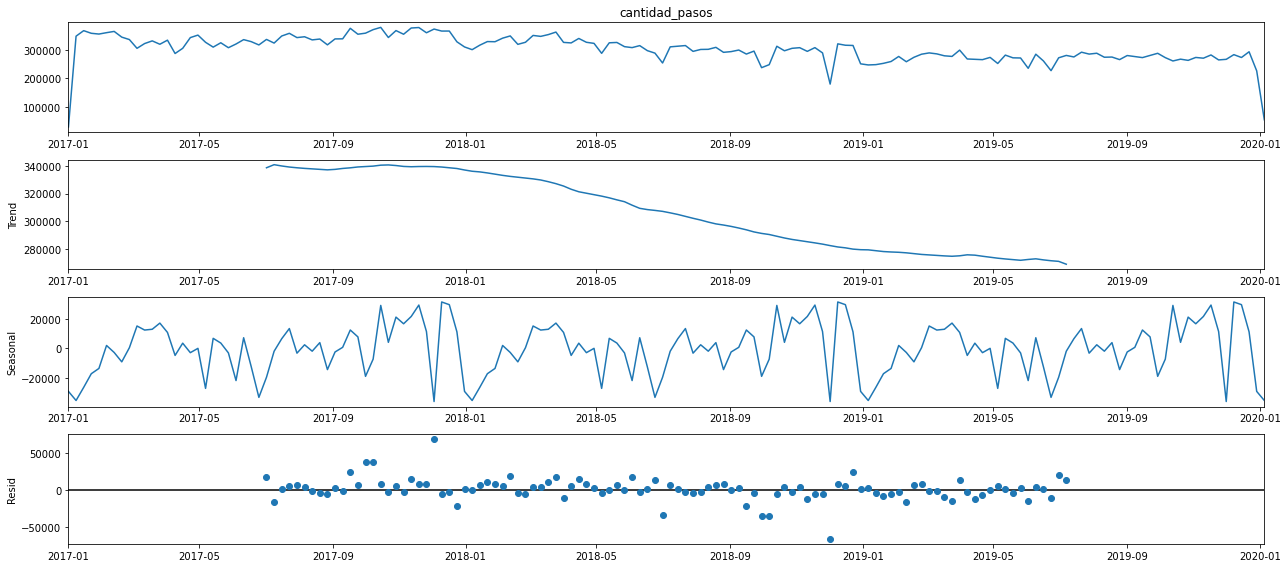

In [64]:
# Graficos:
# - Cantidad de vehiculos semanales
# - Tendencia
# - Estacionalidad
# - Residuos

_ = plt.rcParams['figure.figsize'] = [18,8]
_ = result.plot()
_ = plt.show()

In [65]:
# Componentes de tendencia
result.trend.dropna()

fecha
2017-07-02    338712.971154
2017-07-09    340939.307692
2017-07-16    340000.817308
2017-07-23    339236.500000
2017-07-30    338702.365385
                  ...      
2019-06-09    272878.000000
2019-06-16    272106.125000
2019-06-23    271484.625000
2019-06-30    271038.259615
2019-07-07    268966.192308
Freq: W-SUN, Name: trend, Length: 106, dtype: float64

In [66]:
# Componentes estacionales
result.seasonal

fecha
2017-01-01   -29066.512790
2017-01-08   -35210.426251
2017-01-15   -26342.632982
2017-01-22   -17116.580097
2017-01-29   -13559.546444
                  ...     
2019-12-08    31334.477595
2019-12-15    29519.290095
2019-12-22    11135.703556
2019-12-29   -29066.512790
2020-01-05   -35210.426251
Freq: W-SUN, Name: seasonal, Length: 158, dtype: float64

## RESAMPLEO DIARIO

In [67]:
diario = dataset[["fecha","cantidad_pasos"]].resample('D', on = 'fecha').sum().reset_index()

In [68]:
calendario_completo_df = pd.DataFrame(calendario_completo)

diario_ok = calendario_completo_df.merge(diario, 
                                         how = "left", 
                                         left_on = 0, 
                                         right_on = "fecha")


In [69]:
diario_ok.drop(columns = 0, axis=1, inplace = True)

In [70]:
diario_ok["cantidad_pasos"].fillna(value = 0, inplace = True)

In [71]:
diario_ok.set_index(calendario_completo, inplace=True)

In [72]:
diario_ok["fecha_num"] = diario_ok.index.map(dt.datetime.toordinal)

In [73]:
diario_ok.drop(columns = "fecha", axis=1, inplace = True)

#### Rolling window - 7 dias

Lo cual representa un barrido de una semana

In [74]:
diario_promedio_tendencia = diario_ok.cantidad_pasos.rolling(window = 7, center = True).mean()
diario_promedio_tendencia

2017-01-01             NaN
2017-01-02             NaN
2017-01-03             NaN
2017-01-04    48904.285714
2017-01-05    49601.714286
                  ...     
2019-12-27    31197.428571
2019-12-28    30801.285714
2019-12-29             NaN
2019-12-30             NaN
2019-12-31             NaN
Name: cantidad_pasos, Length: 1095, dtype: float64

In [75]:
lr = LinearRegression()
lr.fit(diario_ok.fecha_num.values.reshape(-1, 1), diario_ok.cantidad_pasos)

LinearRegression()

In [76]:
q25,q75 = np.percentile(diario_ok.cantidad_pasos, [25 ,75])
iqr = q75 - q25

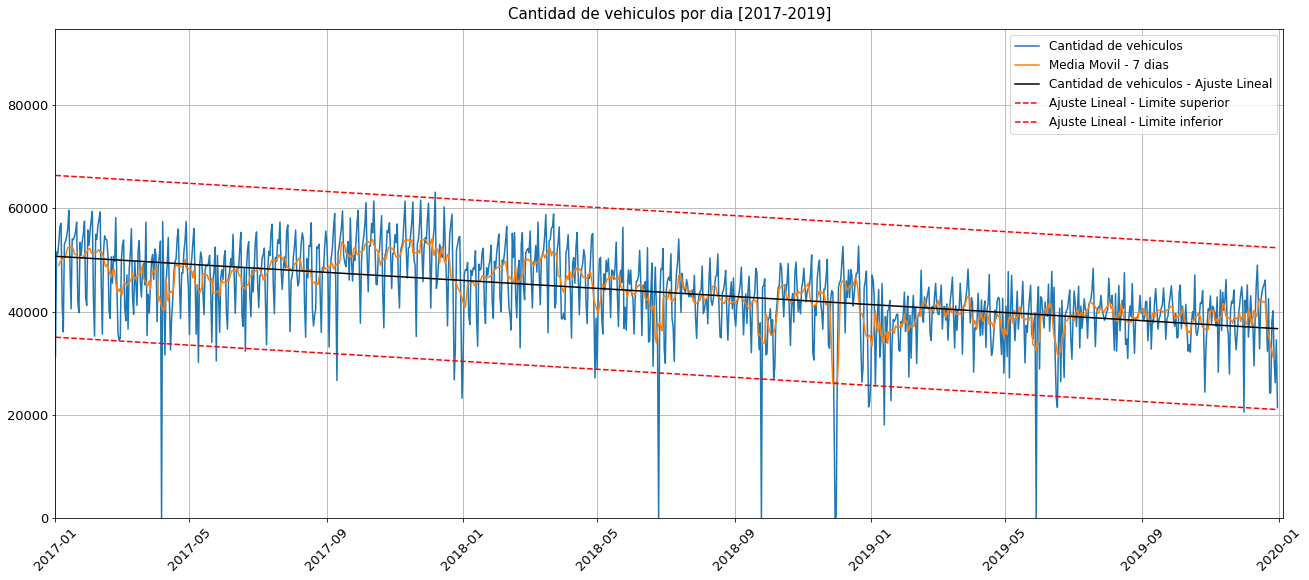

In [77]:
_ = plt.figure(figsize = (22,9))

_ = plt.plot(diario_ok.index,
             diario_ok.cantidad_pasos, 
             label = "Cantidad de vehiculos")

_ = plt.plot(diario_promedio_tendencia, 
             label = "Media Movil - 7 dias")

_ = plt.plot(diario_ok.index, 
             lr.predict(diario_ok.fecha_num.values.reshape(-1, 1)),
             c = "k",
             label = "Cantidad de vehiculos - Ajuste Lineal")

_ = plt.plot(diario_ok.index, 
             lr.predict(diario_ok.fecha_num.values.reshape(-1, 1)) + 1.5 * iqr,
             ls = "--",
             c = "r",
             label = "Ajuste Lineal - Limite superior")

_ = plt.plot(diario_ok.index, 
             lr.predict(diario_ok.fecha_num.values.reshape(-1, 1)) - 1.5 * iqr,
             ls = "--",
             c = "r",
             label = "Ajuste Lineal - Limite inferior")


_ = plt.title("Cantidad de vehiculos por dia [2017-2019]", 
              fontsize = 15, 
              pad = 10)


_ = plt.ylabel("")

_ = plt.yticks(fontsize = 13)

_ = plt.xticks(fontsize = 13,
               rotation = 45)

_ = plt.xlim(dt.date(2017,1,1),
             dt.date(2020,1,5))

_ = plt.ylim(diario_ok.cantidad_pasos.min()*0.5,
             diario_ok.cantidad_pasos.max()*1.5)

_ = plt.grid(axis = "both")

_ = plt.legend(fontsize = 12)

In [78]:
result = seasonal_decompose(diario_ok.cantidad_pasos, model = 'additive')

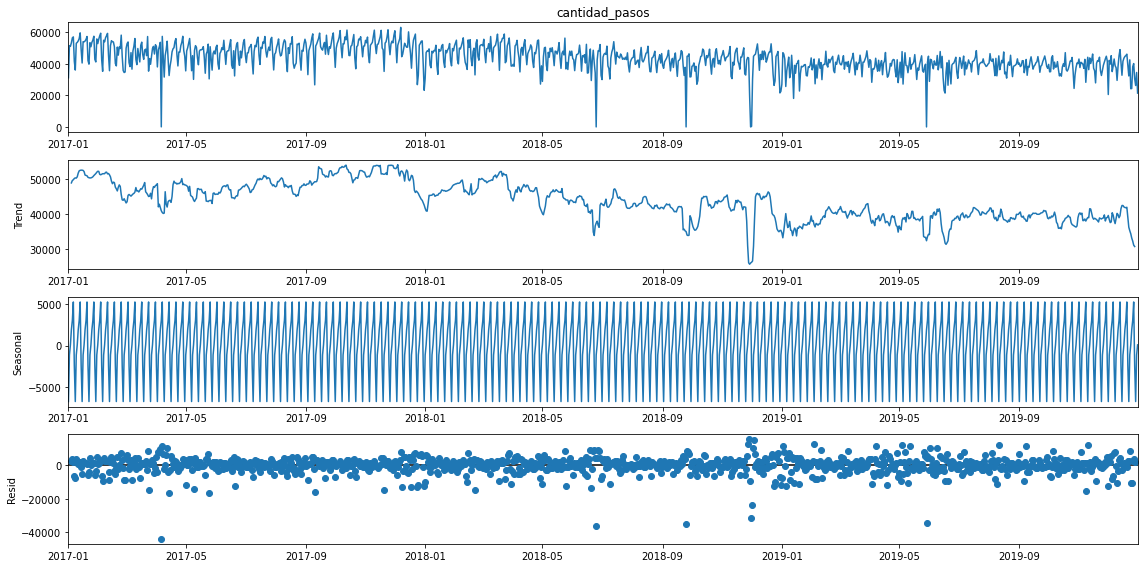

In [79]:
# Graficos:
# - Cantidad de vehiculos semanales
# - Tendencia
# - Estacionalidad
# - Residuos

_ = plt.rcParams['figure.figsize'] = [16,8]
_ = result.plot()
_ = plt.show()

### Tendencia decreciente ... Qué posibles causas puede haber detrás de este comportamiento?

Independientemente del resampleo, la tendencia se mantiene decreciente para la estación Illia para el método de pago efectivo.

Algunas de las hipótesis que se me ocurren son:

* Migración a otro de método de pago más conveniente (como el telepase)
* Mantenimiento/obras de los tramos que conectan la estación
* Otros factores: descenso de la oferta laboral, inseguridad, aumento del costo de vida

In [80]:
data_original = pd.concat([data_2019, data_2018, data_2017])

mask_telepase = np.logical_and(data_original.estacion == 'Illia', data_original.forma_pago == 'TELEPASE')

telepase = data_original[mask_telepase]

telepase.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

telepase.head()

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


fecha  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos
20  2019-01-01         1  Martes     Centro       Liviano              59
21  2019-01-01         1  Martes     Centro        Pesado               1
23  2019-01-01         1  Martes  Provincia       Liviano             106
25  2019-01-01         1  Martes  Provincia        Pesado               2
85  2019-01-01         2  Martes     Centro       Liviano             507

In [81]:
telepase["fecha"] = pd.to_datetime(telepase.fecha)
telepase["fecha"] = telepase["fecha"].dt.normalize()

<ipython-input-81-bfa4efc8c44c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telepase["fecha"] = pd.to_datetime(telepase.fecha)
<ipython-input-81-bfa4efc8c44c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telepase["fecha"] = telepase["fecha"].dt.normalize()


In [82]:
telepase = telepase[["fecha","cantidad_pasos"]].resample('D', on = 'fecha').sum()
telepase["fecha_num"] = telepase.index.map(dt.datetime.toordinal)
telepase.head(3).append(telepase.tail(3))

cantidad_pasos  fecha_num
fecha                                
2017-01-01           12326     736330
2017-01-02           35621     736331
2017-01-03           39390     736332
2019-12-29           22577     737422
2019-12-30           47001     737423
2019-12-31           20232     737424

### Rolling window - 7 dias

In [83]:
telepase_prom = telepase.cantidad_pasos.rolling(window = 7, center = True).mean()
telepase_prom

fecha
2017-01-01             NaN
2017-01-02             NaN
2017-01-03             NaN
2017-01-04    32063.000000
2017-01-05    32245.142857
                  ...     
2019-12-27    38469.428571
2019-12-28    37481.428571
2019-12-29             NaN
2019-12-30             NaN
2019-12-31             NaN
Freq: D, Name: cantidad_pasos, Length: 1095, dtype: float64

In [84]:
lr = LinearRegression()
lr.fit(telepase.fecha_num.values.reshape(-1, 1), telepase.cantidad_pasos)

LinearRegression()

In [85]:
q25,q75 = np.percentile(telepase.cantidad_pasos, [25 ,75])
iqr = q75 - q25

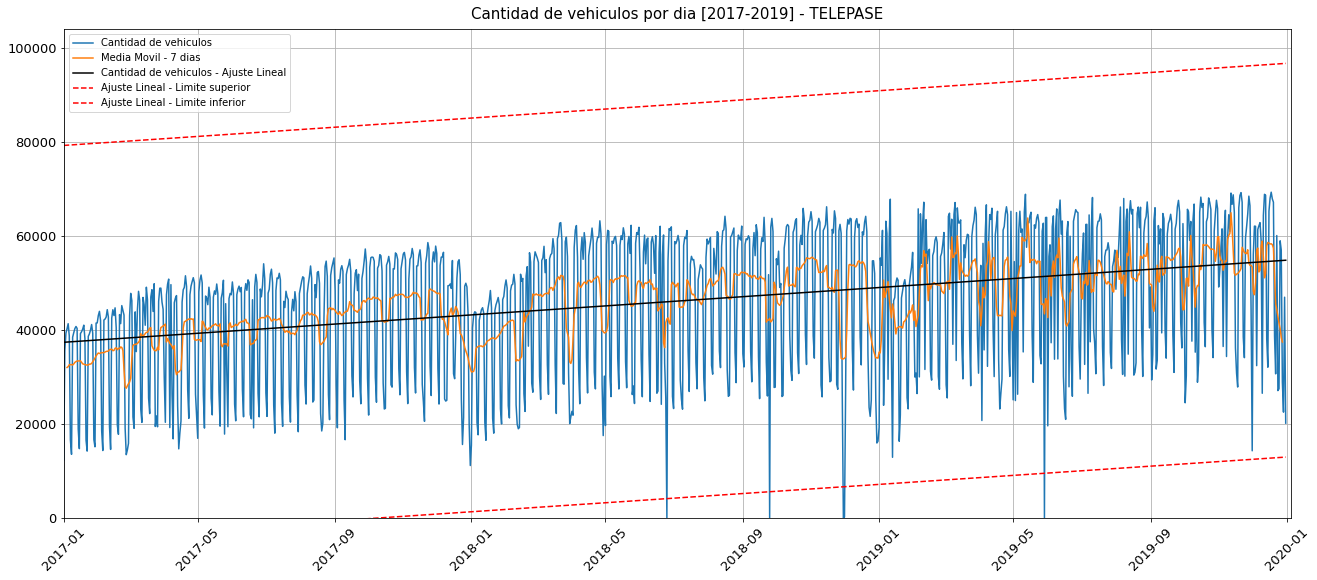

In [86]:
_ = plt.figure(figsize = (22,9))

_ = plt.plot(telepase.index,
             telepase.cantidad_pasos, 
             label = "Cantidad de vehiculos")

_ = plt.plot(telepase_prom, 
             label = "Media Movil - 7 dias")

_ = plt.plot(telepase.index, 
             lr.predict(telepase.fecha_num.values.reshape(-1, 1)),
             c = "k",
             label = "Cantidad de vehiculos - Ajuste Lineal")

_ = plt.plot(telepase.index, 
             lr.predict(telepase.fecha_num.values.reshape(-1, 1)) + 1.5 * iqr,
             ls = "--",
             c = "r",
             label = "Ajuste Lineal - Limite superior")

_ = plt.plot(telepase.index, 
             lr.predict(telepase.fecha_num.values.reshape(-1, 1)) - 1.5 * iqr,
             ls = "--",
             c = "r",
             label = "Ajuste Lineal - Limite inferior")


_ = plt.title("Cantidad de vehiculos por dia [2017-2019] - TELEPASE", 
              fontsize = 15, 
              pad = 10)


_ = plt.ylabel("")

_ = plt.yticks(fontsize = 13)

_ = plt.xticks(fontsize = 13,
               rotation = 45)

_ = plt.xlim(dt.date(2017,1,1),
             dt.date(2020,1,5))

_ = plt.ylim(telepase.cantidad_pasos.min()*0.5,
             telepase.cantidad_pasos.max()*1.5)

_ = plt.grid(axis = "both")

_ = plt.legend(fontsize = 10, loc = "best")

In [87]:
telepase_result = seasonal_decompose(telepase.cantidad_pasos, model = 'additive')

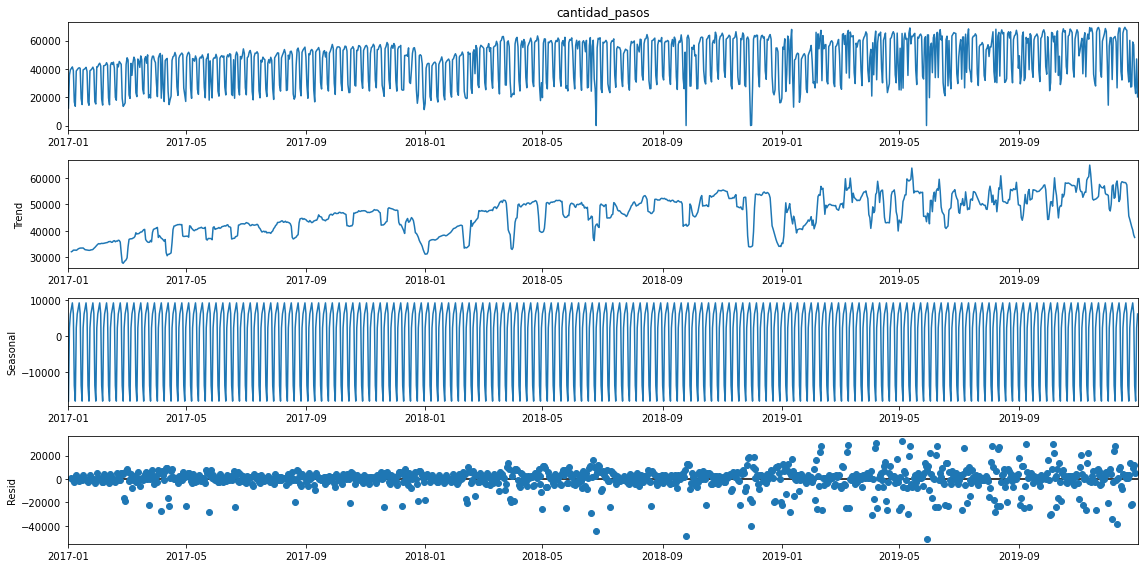

In [88]:
# Graficos:
# - Cantidad de vehiculos semanales
# - Tendencia
# - Estacionalidad
# - Residuos

_ = plt.rcParams['figure.figsize'] = [16,8]
_ = telepase_result.plot()
_ = plt.show()

### Conclusión
Hay una clara tendencia positiva en el método de pago de telepase. Investigando un poco más, su conveniencia por sobre los demás se debe a que la cabina del peaje se encuentra separada y es más agil para liberar el vehiculo del punto de pago. Considerando esta información, hay una gran probabilidad de que el causal de la tendencia negativa del pago efectivo sea por migración a este método de pago.

## Outliers

Regresando a la gráfica de "Cantidad de vehiculos por dia [2017-2019]" (Illia - EFECTIVO), podemos visualizar los valores atípicos como aquellos donde la curva de color azul se va por fuera de las bandas punteadas de color rojo. Lamentablemente, no es posible visualizar en mayor detalle si quisieramos saber la fecha exacta y que cantidad de vehiculos hubo ese dia.

In [89]:
#Fechas en detalle y cantidad de vehiculos para lo outliers

outliers = diario_ok.copy() # Copio el diario_ok para no pisarlo

#Construyo regresion una vez mas
lr = LinearRegression()
lr.fit(diario_ok.fecha_num.values.reshape(-1, 1), diario_ok.cantidad_pasos)
regresion = lr.predict(outliers.fecha_num.values.reshape(-1, 1))

#Cuartiles y rango intercuartilico
q25,q75 = np.percentile(outliers.cantidad_pasos, [25 ,75])
iqr = q75 - q25

outliers["regresion"] = regresion

outliers["reg_lim_sup"] = outliers["regresion"] + 1.5 * iqr # Construyo limite superior
outliers["reg_lim_inf"] = outliers["regresion"] - 1.5 * iqr # Construyo limite inferior

outliers["out_sup"] = outliers["cantidad_pasos"] - outliers["reg_lim_sup"]
outliers["out_inf"] = outliers["cantidad_pasos"] - outliers["reg_lim_inf"]


outliers["out_sup"] = outliers["out_sup"].apply(lambda x: 1 if x > 0 else 0) # los valores positivos son consecuencia de haber superado el limite superior
outliers["out_inf"] = outliers["out_inf"].apply(lambda x: 1 if x < 0 else 0) # los valores negativos son consecuencia de haber caido debajo del limite inferior

In [90]:
#Outliers limite superior
outliers[outliers["out_sup"] == 1]

cantidad_pasos  fecha_num     regresion   reg_lim_sup  \
2017-12-07           63127     736670  46362.684885  62017.434885   

             reg_lim_inf  out_sup  out_inf  
2017-12-07  30707.934885        1        0

In [91]:
#Outliers limite inferior
outliers[outliers["out_inf"] == 1]

cantidad_pasos  fecha_num     regresion   reg_lim_sup  \
2017-01-01           31183     736330  50715.055311  66369.805311   
2017-04-06              40     736425  49498.951810  65153.701810   
2017-04-09           31615     736428  49460.548541  65115.298541   
2017-04-14           32588     736433  49396.543094  65051.293094   
2017-05-09           30152     736458  49076.515857  64731.265857   
2017-05-25           30479     736474  48871.698425  64526.448425   
2017-06-20           32336     736500  48538.870098  64193.620098   
2017-09-10           26684     736582  47489.180760  63143.930760   
2017-12-24           26805     736687  46145.066364  61799.816364   
2017-12-31           23229     736694  46055.458737  61710.208737   
2018-04-29           27169     736813  44532.129088  60186.879088   
2018-06-25               0     736870  43802.466987  59457.216987   
2018-09-25               0     736962  42624.766754  58279.516754   
2018-11-29           19728     737027  41792.695937  57447.445937   
2018-11-30               0     737028  41779.894848  57434.644848   
2018-12-01             350     737029  41767.093758  57421.843758   
2018-12-30           21559     737058  41395.862163  57050.612163   
2018-12-31           22599     737059  41383.061074  57037.811074   
2019-01-05           25650     737064  41319.055626  56973.805626   
2019-01-13           18076     737072  41216.646910  56871.396910   
2019-01-19           22774     737078  41139.840373  56794.590373   
2019-05-29               0     737208  39475.698740  55130.448740   
2019-06-16           23190     737226  39245.279129  54900.029129   
2019-06-17           21469     737227  39232.478040  54887.228040   
2019-12-01           20553     737394  37094.696095  52749.446095   

             reg_lim_inf  out_sup  out_inf  
2017-01-01  35060.305311        0        1  
2017-04-06  33844.201810        0        1  
2017-04-09  33805.798541        0        1  
2017-04-14  33741.793094        0        1  
2017-05-09  33421.765857        0        1  
2017-05-25  33216.948425        0        1  
2017-06-20  32884.120098        0        1  
2017-09-10  31834.430760        0        1  
2017-12-24  30490.316364        0        1  
2017-12-31  30400.708737        0        1  
2018-04-29  28877.379088        0        1  
2018-06-25  28147.716987        0        1  
2018-09-25  26970.016754        0        1  
2018-11-29  26137.945937        0        1  
2018-11-30  26125.144848        0        1  
2018-12-01  26112.343758        0        1  
2018-12-30  25741.112163        0        1  
2018-12-31  25728.311074        0        1  
2019-01-05  25664.305626        0        1  
2019-01-13  25561.896910        0        1  
2019-01-19  25485.090373        0        1  
2019-05-29  23820.948740        0        1  
2019-06-16  23590.529129        0        1  
2019-06-17  23577.728040        0        1  
2019-12-01  21439.946095        0        1

## Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Paso 0: Contruir el dataset completo para el modelo de predicción

Resampleo diario del dataset inicial (ignorando el efecto de las horas de aqui en adelante)

In [92]:
df = dataset.groupby(["fecha","dia","sentido","tipo_vehiculo"])["cantidad_pasos"].sum().reset_index()
df

fecha      dia    sentido tipo_vehiculo  cantidad_pasos
0    2017-01-01  Domingo     Centro       Liviano           16681
1    2017-01-01  Domingo     Centro        Pesado             370
2    2017-01-01  Domingo  Provincia       Liviano           13960
3    2017-01-01  Domingo  Provincia        Pesado             172
4    2017-01-02    Lunes     Centro       Liviano           26011
...         ...      ...        ...           ...             ...
4357 2019-12-30    Lunes  Provincia        Pesado             301
4358 2019-12-31   Martes     Centro       Liviano           10866
4359 2019-12-31   Martes     Centro        Pesado             109
4360 2019-12-31   Martes  Provincia       Liviano           10355
4361 2019-12-31   Martes  Provincia        Pesado             117

[4362 rows x 5 columns]

Contruyo dataframe de fechas faltantes, cerando los valores de cantidad de vehiculos

In [93]:
# Me faltan 4 fechas, pero para introducirlas en el dataset tengo que tener en cuenta que hay 2 sentidos y 2 tipos de vehiculos
# En consecuencia, necesitaré agregarlas imputando con 0 la cantidad de vehiculos para cada caso

fechas_faltantes = ["2018-06-25","2018-06-25","2018-06-25","2018-06-25",
                    "2018-09-25","2018-09-25","2018-09-25","2018-09-25", 
                    "2018-11-30","2018-11-30","2018-11-30","2018-11-30", 
                    "2019-05-29","2019-05-29","2019-05-29","2019-05-29"]

dias = ["Lunes","Lunes","Lunes","Lunes", 
        "Martes","Martes","Martes","Martes",
        "Viernes","Viernes","Viernes","Viernes",
        "Miércoles","Miércoles","Miércoles","Miércoles"]

sentidos = ["Centro","Centro","Provincia","Provincia",
            "Centro","Centro","Provincia","Provincia",
            "Centro","Centro","Provincia","Provincia",
            "Centro","Centro","Provincia","Provincia"]

tipos_vehiculo = ["Liviano","Pesado","Liviano","Pesado",
                 "Liviano","Pesado","Liviano","Pesado",
                 "Liviano","Pesado","Liviano","Pesado",
                 "Liviano","Pesado","Liviano","Pesado"]

diccionario_faltantes = {"fecha" : pd.to_datetime(fechas_faltantes), 
                         "dia" : dias, 
                         "sentido" : sentidos, 
                         "tipo_vehiculo" : tipos_vehiculo, 
                         "cantidad_pasos" : np.zeros(16, dtype = "int")}

In [94]:
df_faltantes = pd.DataFrame(diccionario_faltantes)
df_faltantes

fecha        dia    sentido tipo_vehiculo  cantidad_pasos
0  2018-06-25      Lunes     Centro       Liviano               0
1  2018-06-25      Lunes     Centro        Pesado               0
2  2018-06-25      Lunes  Provincia       Liviano               0
3  2018-06-25      Lunes  Provincia        Pesado               0
4  2018-09-25     Martes     Centro       Liviano               0
5  2018-09-25     Martes     Centro        Pesado               0
6  2018-09-25     Martes  Provincia       Liviano               0
7  2018-09-25     Martes  Provincia        Pesado               0
8  2018-11-30    Viernes     Centro       Liviano               0
9  2018-11-30    Viernes     Centro        Pesado               0
10 2018-11-30    Viernes  Provincia       Liviano               0
11 2018-11-30    Viernes  Provincia        Pesado               0
12 2019-05-29  Miércoles     Centro       Liviano               0
13 2019-05-29  Miércoles     Centro        Pesado               0
14 2019-05-29  Miércoles  Provincia       Liviano               0
15 2019-05-29  Miércoles  Provincia        Pesado               0

In [95]:
df = df.append(df_faltantes, ignore_index = True)

In [96]:
df = df.sort_values(["fecha","sentido","tipo_vehiculo"])

In [97]:
# chequeo que no haya faltantes en los datos ni en el calendario
df.info()

set_df = set(df.fecha.unique())

#Re-utilizo el set construido anteriormente del calendario completo para hacer diferencia de conjuntos contra el set del dataframe nuevo
set_completo - set_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4378 entries, 0 to 4361
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   fecha           4378 non-null   datetime64[ns]
 1   dia             4378 non-null   object        
 2   sentido         4378 non-null   object        
 3   tipo_vehiculo   4378 non-null   object        
 4   cantidad_pasos  4378 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 205.2+ KB


set()

No hay valores faltantes y el resultado de la diferencia de conjuntos es un set vacio (conjunto vacio). En consecuencia, el dataframe construido cuenta con todas las fechas del calendario desde 2017 a 2019.

In [98]:
# indice reiniciado
df.reset_index(drop = True, inplace = True)

### Resumen del analisis exploratorio realizado previamente:

#### 1. Flujo vehicular:

* Flujo semanal: La cantidad de vehiculos crece desde el día lunes para obtener su maximo semanal el viernes, luego decrece hasta el domingo siendo éste el mínimo semanal. Este patrón es consistente en ambos sentidos de circulacion.

* Flujo diario: hay claras diferencias respecto del sentido y para cada dia. En este ultimo podríamos agrupar: dias de semana (lunes a viernes) y fines de semana (sabado y domingo)

* Tipos de vehiculos: hay diferencia significativa sobre la cantidad de livianos y pesados.

* Cantidad de tipo de vehiculo: tanto en pesado como en liviano observamos que las distribuciones son muy similares. Difieren, en mayor medida, en el tercer cuartil y cantidad de outliers respecto de si es o no un dia de la semana.

#### 2. Valores Faltantes: se compartieron noticias con mayor detalle en cada caso. Corresponden a dias de huelga general y evento de cambio de circulación vehicular

#### 3. Valores atípicos: excluyendo los valores faltantes (cant vehiculos = 0), podemos distinguir:

* Periodos de vacaciones de alta temporada: diciembre, enero y junio
* Dias festivos y/o cercanos a estos dias: navidad, fin de año, semana santa y pascua, etc.
* Movilizaciones/paros/huelgas: de menor medida que aquellos eventos identificados como faltantes, pero significativos en el momento de reducir la circulación. Considerando el contexto, es frecuente que haya al menos una movilización restringiendo la circulación en algún punto de Capital Federal todos los días.

## 1 - Transformaciones

### Encoding

In [99]:
# Label Encoding para el calendario

df["day_num"] = df.fecha.dt.day # Dia
df["month_num"] = df.fecha.dt.month # Mes
df["year_num"] = df.fecha.dt.year # Año

In [100]:
# Construyo 2 nuevas columnas que contengan los dias de la semana numerados
# 0: Lunes, 1: Martes, ... , 6: Domingo

df["dia_sem"] = df.fecha.dt.weekday
df["fin_sem"] = df.fecha.dt.weekday

In [101]:
# Armo el one hot encoding con la siguiente regla:

df["dia_sem"] = df["dia_sem"].apply(lambda x: 1 if x <= 4 else 0) # Implica que es un dia de semana, ya que 4 = Viernes
df["fin_sem"] = df["fin_sem"].apply(lambda x: 1 if x > 4 else 0) # Implica que es un fin de semana

In [102]:
# Armo one hot encoding para el sentido y el tipo de vehiculo

cat_features = ["sentido","tipo_vehiculo"]
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False).fit(df[cat_features])
label_names = list(ohe.get_feature_names())
label_names

['x0_Centro', 'x0_Provincia', 'x1_Liviano', 'x1_Pesado']

In [103]:
ohe_df = pd.DataFrame(ohe.transform(df[cat_features]), columns = label_names)
ohe_df = ohe_df.set_index(keys = df.index)

In [104]:
df = df.join(ohe_df, on = df.index)

df[label_names] = df[label_names].astype(dtype = "int")

In [105]:
df = df.drop(labels = ["dia"] + cat_features, axis = 1)

In [106]:
df["fecha_numeros"] = df.fecha.map(dt.datetime.toordinal)

In [107]:
df.head()

fecha  cantidad_pasos  day_num  month_num  year_num  dia_sem  fin_sem  \
0 2017-01-01           16681        1          1      2017        0        1   
1 2017-01-01             370        1          1      2017        0        1   
2 2017-01-01           13960        1          1      2017        0        1   
3 2017-01-01             172        1          1      2017        0        1   
4 2017-01-02           26011        2          1      2017        1        0   

   x0_Centro  x0_Provincia  x1_Liviano  x1_Pesado  fecha_numeros  
0          1             0           1          0         736330  
1          1             0           0          1         736330  
2          0             1           1          0         736330  
3          0             1           0          1         736330  
4          1             0           1          0         736331

### Particion ordenada de Train y Test

In [108]:
X_train = df[df["fecha"] < "2019-10-01"]
X_test = df[df["fecha"] >= "2019-10-01"]
y_train = df[df["fecha"] < "2019-10-01"]["cantidad_pasos"]
y_test = df[df["fecha"] >= "2019-10-01"]["cantidad_pasos"]

### Outliers

Si consideramos el contexto (información por fuera del dataset), los eventos que dan origen a los valores atípicos no son nada fuera de lo común para el dia a dia de alguien que vive en Capital Federal. La dificultad radica en la aleatoridad en que estos acontecimientos se producen, los cuales se relacionan a factores políticos y situación económica del momento (inflación, desempleo, etc).

Por otro lado, el tratamiento de encoding previamente realizado requiere que realicemos un analisis de outlier para cada combinacion particular (8 en total), estas son:

 * Cantidad de vehiculos en los dias de semana, en direccion al centro, siendo este liviano
 * Cantidad de vehiculos en los dias de semana, en direccion al centro, siendo este pesado
 * Cantidad de vehiculos en los dias de semana, en direccion a provincia, siendo este liviano
 * Cantidad de vehiculos en los dias de semana, en direccion a provincia, siendo este pesado
 
 ... y luego las mismas combinaciones aplicarian para los fines de semana.
 
Por último y no menos importante, deberiamos aplicar un efecto de tendencia negativa en los datos, lo cual provoca que la detección de valores atípicos sea variable a través del tiempo.
 
En consecuencia, un método para identificar estos valores es aplicar una media movil con una ventana de tiempo (por ej: 7 dias) y establecer limites de control.

Identificados estos valores, las posibles estrategias son:

* Encoding adicional: adicionando una columna al dataset tipo OHE.
* Eliminarlos
* Imputarlos: utilizando una estrategia de imputación que contemple las variables mas significativas ya codificadas y la tendencia negativa.

**Debido a la complejidad que implica modelar estos escenarios, decidí seguir adelante manteniendo los outliers sin aplicar las estrategias mencionadas.**

In [109]:
#Dropeo la label fecha una vez realizada la partición ordenada
X_train = X_train.drop(labels = "fecha", axis = 1)
X_test = X_test.drop(labels = "fecha", axis = 1)

### 2 y 3: Modelos y Cross Validation

In [110]:
# Guardo modelos en un diccionario
model_dict = {}

model_dict["knn"] = KNeighborsRegressor(n_neighbors = 5)

model_dict["tree"] = DecisionTreeRegressor(max_depth = 5, random_state = 123)

model_dict["random_forest"] = RandomForestRegressor(n_estimators = 50, max_depth = 5, max_features = "sqrt", random_state = 123, n_jobs = -1)

model_dict["gbr"] = GradientBoostingRegressor(n_estimators=50, max_depth=5, learning_rate=0.08, subsample=0.7, max_features = "sqrt", random_state = 123)

model_dict["xgbr"] = XGBRegressor(n_estimators=50, max_depth=5, learning_rate=0.08, subsample=0.7, max_features = "sqrt", random_state = 123, n_jobs = -1)

# Guardo keys en una lista
modelos = list(model_dict.keys()) 

Para el proceso de validacion cruzada utilizo las métricas de:

* Root mean squared error (RMSE): para poder penalizar grandes errores en el set de predicciones.
* Mean Absolute Error (MAE): para medir la magnitud promedio de los errores en un set de predicciones. Luego los errores pueden ser facilmente interpretables en términos del problema de estudio (son los que se usarán en las visualizacion de errores para analizar el desempeño de los modelos más adelante).
 


In [111]:
# Cross Validation

rmse = {}
mae = {}

for modelo in modelos:
    
    rmse[modelo] = np.sqrt(-cross_val_score(estimator = model_dict[modelo], X = X_train, y = y_train,
                                           scoring = "neg_mean_squared_error", cv = 5, n_jobs = -1))
    
    mae[modelo] = -cross_val_score(estimator = model_dict[modelo], X = X_train, y = y_train,
                                  scoring = "neg_mean_absolute_error", cv = 5, n_jobs = -1)
    
rmse = pd.DataFrame.from_dict(rmse)
mae = pd.DataFrame.from_dict(mae)

#### Resultados CV

In [112]:
resultados = pd.concat(objs=[pd.DataFrame(rmse.mean(), columns=["rmse"]),
                             pd.DataFrame(rmse.std(), columns=["rmse_std"]),
                             pd.DataFrame(mae.mean(), columns=["mae"]),
                             pd.DataFrame(mae.std(), columns=["mae_std"])], axis=1)

resultados

rmse    rmse_std         mae     mae_std
knn              92.556953   63.493948   35.393117   17.385062
tree            265.545994   47.280907  175.933415   35.936357
random_forest  1306.966205  166.548547  715.522703  100.920740
gbr             777.113310  223.600486  481.621465  163.089418
xgbr            273.240974   50.342311  185.047834   30.480684

#### Utilizando los parametros por defecto los modelos de menor error fueron:

* Vecinos mas cercanos (knn)
* Arboles de decision (tree)
* Xtreme gradient boosting (xgbr)

## 4 - Hipertunning

### Hipertunning de KNeighborsRegressor

In [113]:
parametros = {"n_neighbors" : range(3,12,2),
              "weights" : ["uniform","distance"],
              "leaf_size" : range(15, 60, 15),
              "p" : [1, 2]}

knn_cv = GridSearchCV(estimator = model_dict["knn"], param_grid = parametros, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

knn_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'leaf_size': range(15, 60, 15),
                         'n_neighbors': range(3, 12, 2), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error')

In [114]:
print(f"Los mejores hiperparametros son: \n")

for key, value in knn_cv.best_params_.items():
    print(f"{key}: {value}")
    
print(f"El error absoluto medio más bajo es: {np.round(-knn_cv.best_score_, 2)}")

Los mejores hiperparametros son: 

leaf_size: 30
n_neighbors: 3
p: 1
weights: distance
El error absoluto medio más bajo es: 26.2


### Hipertunning de DecisionTreeRegressor

In [115]:
parametros = {"criterion" : ["mse","mae","poisson"],
              "max_depth" : range(3,12,2), 
              "min_samples_split" : range(10,60,10),
              "min_samples_leaf" : range(10,60,10)}



tree_cv = GridSearchCV(estimator = model_dict["tree"], 
                       param_grid = parametros, 
                       scoring='neg_mean_absolute_error',
                       cv = 5,
                       n_jobs=-1)

tree_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(max_depth=5, random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae', 'poisson'],
                         'max_depth': range(3, 12, 2),
                         'min_samples_leaf': range(10, 60, 10),
                         'min_samples_split': range(10, 60, 10)},
             scoring='neg_mean_absolute_error')

In [116]:
print(f"Los mejores hiperparametros son: \n")

for key, value in tree_cv.best_params_.items():
    print(f"{key}: {value}")
    
print(f"El error absoluto medio más bajo es: {np.round(-tree_cv.best_score_, 2)}")

Los mejores hiperparametros son: 

criterion: mae
max_depth: 9
min_samples_leaf: 20
min_samples_split: 10
El error absoluto medio más bajo es: 80.2


### Hipertunning de XGBRegressor

In [117]:
parametros = {"n_estimators": [50, 100, 150],
              "subsample": [0.5, 0.7, 1.0],
              "min_child_weight" : [1, 3, 5, 7],
              "max_depth": [5,7,9],
              "max_features" : [None, "sqrt"]}

xgbr_cv = GridSearchCV(estimator = model_dict["xgbr"], 
                       param_grid = parametros, 
                       scoring='neg_mean_absolute_error',
                       cv = 5,
                       n_jobs=-1)

xgbr_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.08, max_delta_step=None,
                                    max_depth=5, max_features='sqrt',
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estim...
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=123, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=0.7, tree_method=None,
      

In [118]:
print(f"Los mejores hiperparametros son: \n")
for key, value in xgbr_cv.best_params_.items():
    print(f"{key}: {value}")
print(f"El error absoluto medio más bajo es: {np.round(-xgbr_cv.best_score_, 2)}")

Los mejores hiperparametros son: 

max_depth: 9
max_features: None
min_child_weight: 1
n_estimators: 150
subsample: 1.0
El error absoluto medio más bajo es: 17.7


In [119]:
model_1 = knn_cv.best_estimator_
model_2 = tree_cv.best_estimator_
model_3 = xgbr_cv.best_estimator_

## 5 - Valoracion de features y Evaluacion de modelos

#### XGBRegressor

In [120]:
importance_xgbr = model_3.feature_importances_

In [121]:
df_feat_importance_xgbr = pd.Series(data = importance_xgbr, name = "Feature_importance",index = X_test.columns).reset_index()
df_feat_importance_xgbr = df_feat_importance_xgbr.rename(columns = {"index":"Feature"})
df_feat_importance_xgbr = df_feat_importance_xgbr.sort_values("Feature_importance", ascending = False)

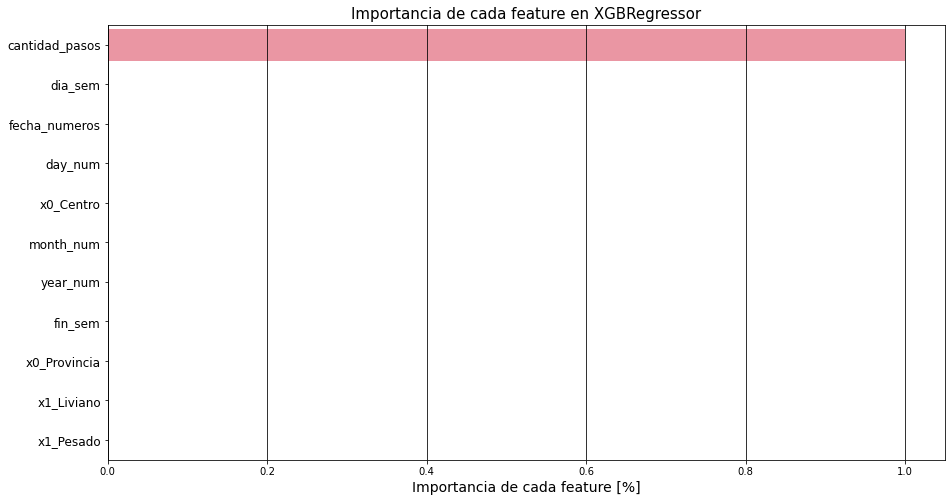

In [122]:
# Grafica
_ = plt.figure(figsize = (15,8))
_ = sns.barplot(data = df_feat_importance_xgbr, x = "Feature_importance", y = "Feature")
_ = plt.title("Importancia de cada feature en XGBRegressor", fontsize = 15)
_ = plt.ylabel("")
_ = plt.xlabel("Importancia de cada feature [%]", fontsize = 14)
_ = plt.yticks(fontsize = 12)
_ = plt.grid(axis = "x", color = "k")

#### KNeighborsRegressor y DecisionTreeRegressor

#### Estos modelos no cuentan con un atributo el cual nos regrese la importancia de los features utilizados

#### En su lugar vamos a utilizar: Permutation Feature Importance

1. Primero, un modelo se ajusta al conjunto de datos, como un modelo que no soporta puntuaciones de importancia de features nativas (ej: KNN)
2. Luego, el modelo se usa para hacer predicciones en un conjunto de datos, aunque los valores de un feature en el conjunto de datos están codificados. 
3. Se repite el paso 2 para cada feature del dataset 
4. Luego se repite todo el procesos 3, 5, 10 o mas veces (parametro n_repeats)
5. El resultado es una puntuación de importancia media para cada feature de entrada (y la distribución de puntuaciones dadas las repeticiones).

In [123]:
# permutation feature importance with knn for regression
from sklearn.inspection import permutation_importance

#### KNeighborsRegressor

In [124]:
# Permutation Importance
results = permutation_importance(model_1, 
                                 X_test, 
                                 y_test, 
                                 n_repeats = 10, 
                                 scoring = 'neg_mean_absolute_error', 
                                 n_jobs = -1, 
                                 random_state = 123)

In [125]:
importance = results.importances_mean / results.importances_mean.sum()

In [126]:
df_feat_importance = pd.Series(data = importance, name = "Feature_importance",index = X_test.columns).reset_index()
df_feat_importance = df_feat_importance.rename(columns = {"index":"Feature"})
df_feat_importance = df_feat_importance.sort_values("Feature_importance", ascending = False)

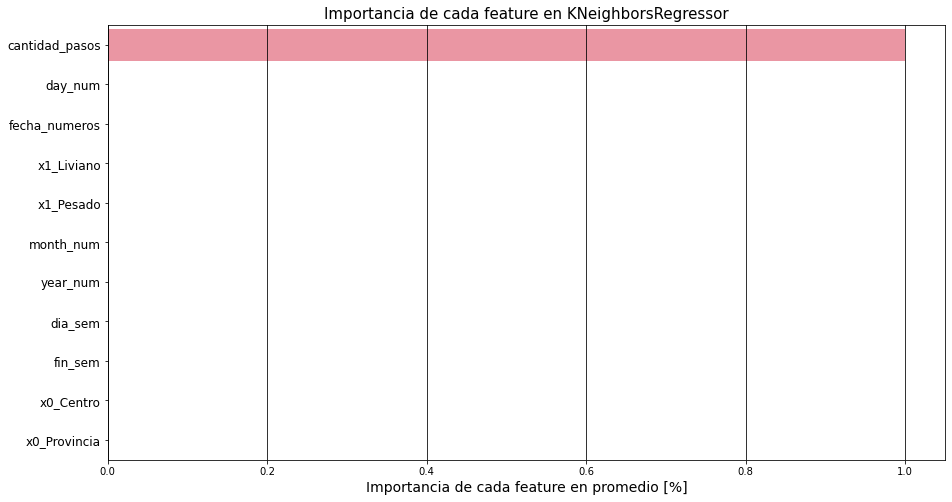

In [127]:
# Grafica
_ = plt.figure(figsize = (15,8))
_ = sns.barplot(data = df_feat_importance, x = "Feature_importance", y = "Feature")
_ = plt.title("Importancia de cada feature en KNeighborsRegressor", fontsize = 15)
_ = plt.ylabel("")
_ = plt.xlabel("Importancia de cada feature en promedio [%]", fontsize = 14)
_ = plt.yticks(fontsize = 12)
_ = plt.grid(axis = "x", color = "k")

#### DecisionTreeRegressor

In [128]:
# Permutation Importance
results = permutation_importance(model_2, 
                                 X_test, 
                                 y_test, 
                                 n_repeats = 10, 
                                 scoring = 'neg_mean_absolute_error', 
                                 n_jobs = -1, 
                                 random_state = 123)

In [129]:
importance = results.importances_mean / results.importances_mean.sum()

In [130]:
df_feat_importance = pd.Series(data = importance, name = "Feature_importance",index = X_test.columns).reset_index()
df_feat_importance = df_feat_importance.rename(columns = {"index":"Feature"})
df_feat_importance = df_feat_importance.sort_values("Feature_importance", ascending = False)

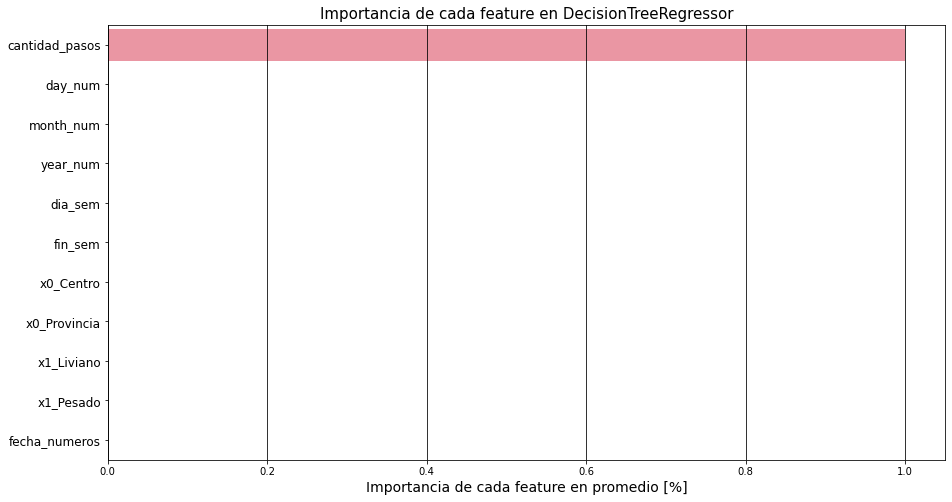

In [131]:
# Grafica
_ = plt.figure(figsize = (15,8))
_ = sns.barplot(data = df_feat_importance, x = "Feature_importance", y = "Feature")
_ = plt.title("Importancia de cada feature en DecisionTreeRegressor", fontsize = 15)
_ = plt.ylabel("")
_ = plt.xlabel("Importancia de cada feature en promedio [%]", fontsize = 14)
_ = plt.yticks(fontsize = 12)
_ = plt.grid(axis = "x", color = "k")

#### En todos los modelos, la variable de mayor importancia en forma absoluta es la cantidad de vehiculos.

## Evaluacion de los modelos

### KNeighborsRegressor

In [132]:
print(f"El RMSE en Entrenamiento: {np.sqrt(mean_squared_error(y_train, model_1.predict(X_train)))}")

print(f"El RMSE en Prueba: {np.sqrt(mean_squared_error(y_test, model_1.predict(X_test)))}" + "\n")

print(f"El MAE en Entrenamiento: {mean_absolute_error(y_train, model_1.predict(X_train))}")

print(f"El MAE en Prueba: {mean_absolute_error(y_test, model_1.predict(X_test))}")

El RMSE en Entrenamiento: 0.0
El RMSE en Prueba: 55.00121827893772

El MAE en Entrenamiento: 0.0
El MAE en Prueba: 19.991988838553592


### DecisionTreeRegressor

In [133]:
print(f"El RMSE en Entrenamiento: {np.sqrt(mean_squared_error(y_train, model_2.predict(X_train)))}")

print(f"El RMSE en Prueba: {np.sqrt(mean_squared_error(y_test, model_2.predict(X_test)))}" + "\n")

print(f"El MAE en Entrenamiento: {mean_absolute_error(y_train, model_2.predict(X_train))}")

print(f"El MAE en Prueba: {mean_absolute_error(y_test, model_2.predict(X_test))}")

El RMSE en Entrenamiento: 365.6017224403785
El RMSE en Prueba: 788.7092660707553

El MAE en Entrenamiento: 52.005236907730676
El MAE en Prueba: 121.7241847826087


### XGBRegressor

In [134]:
print(f"El RMSE en Entrenamiento: {np.sqrt(mean_squared_error(y_train, model_3.predict(X_train)))}")

print(f"El RMSE en Prueba: {np.sqrt(mean_squared_error(y_test, model_3.predict(X_test)))}" + "\n")

print(f"El MAE en Entrenamiento: {mean_absolute_error(y_train, model_3.predict(X_train))}")

print(f"El MAE en Prueba: {mean_absolute_error(y_test, model_3.predict(X_test))}")

El RMSE en Entrenamiento: 11.552470209935512
El RMSE en Prueba: 51.7516515259767

El MAE en Entrenamiento: 6.542256076407254
El MAE en Prueba: 17.62923382676166


### Para chequear: Hubo predicciones con valores negativos?

In [135]:
modelos = {"KNeighborsRegressor" : model_1,
           "DecisionTreeRegressor" : model_2,
           "XGBRegressor" : model_3}

for key, value in modelos.items():
    print(key + "\n")
    print("Cant valores (-) en X_train: " + str( (value.predict(X_train) < 0).sum() ) )
    print("Cant valores (-) en X_test: " + str( (value.predict(X_test) < 0).sum() ) + "\n")

KNeighborsRegressor

Cant valores (-) en X_train: 0
Cant valores (-) en X_test: 0

DecisionTreeRegressor

Cant valores (-) en X_train: 0
Cant valores (-) en X_test: 0

XGBRegressor

Cant valores (-) en X_train: 0
Cant valores (-) en X_test: 0



En caso de que hubiese predicciones de vehiculos con cantidades negativas, deberiamos forzar dichos valores a 0.

### Distribucion de los errores

Modelo: KNeighborsRegressor
Error Medio Absoluto en Train: 0.0
Error Medio Absoluto en Test: 19.991988838553592


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


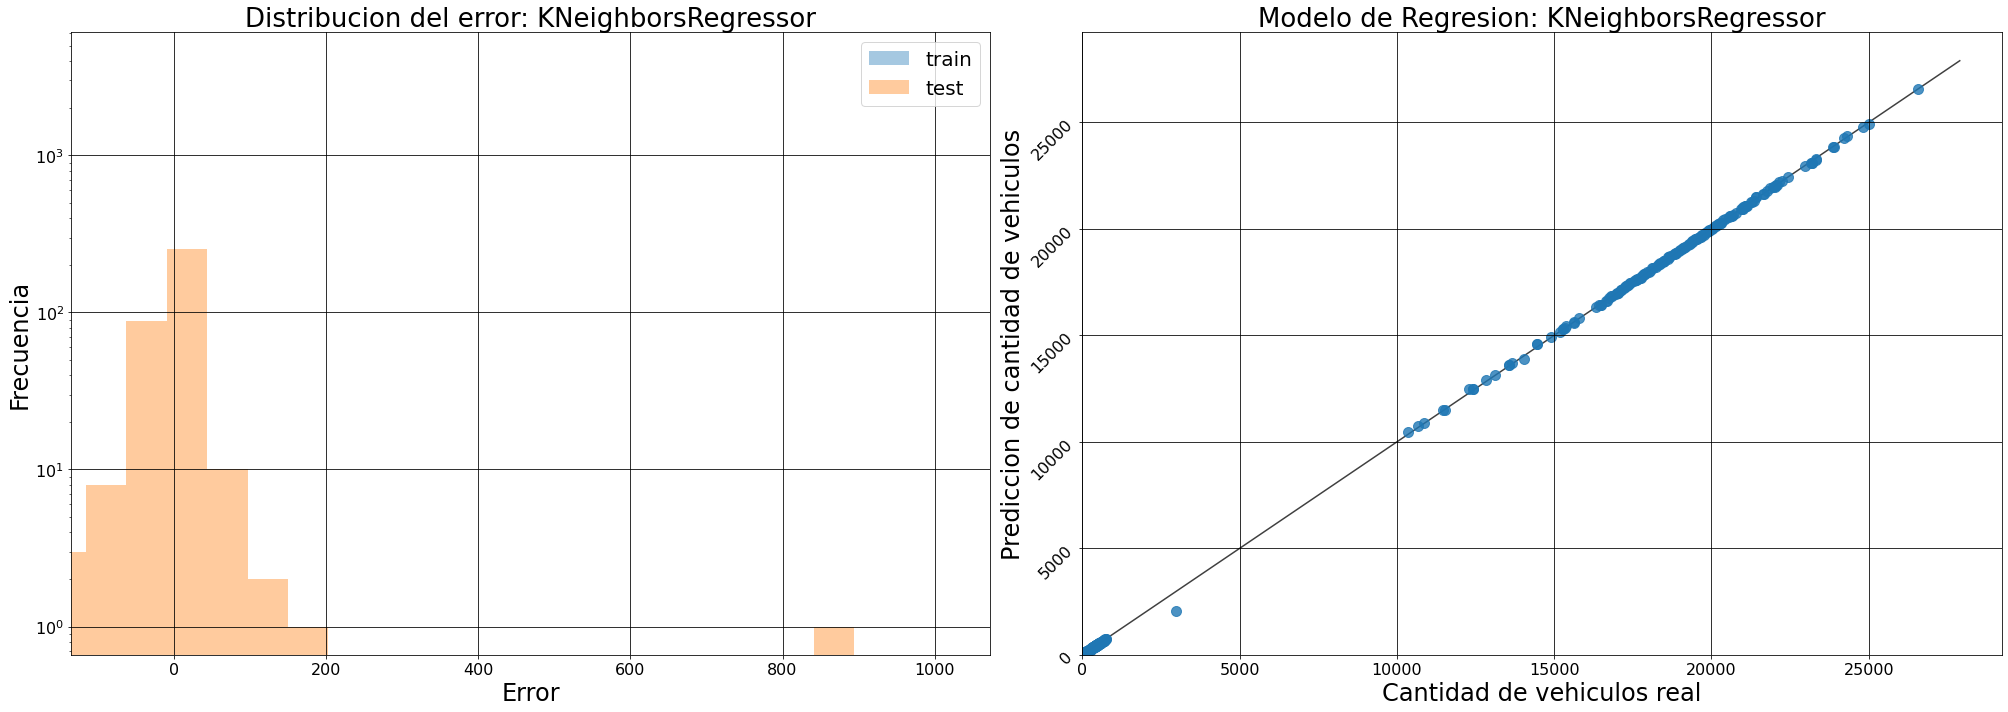

Modelo: DecisionTreeRegressor
Error Medio Absoluto en Train: 52.005236907730676
Error Medio Absoluto en Test: 121.7241847826087


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


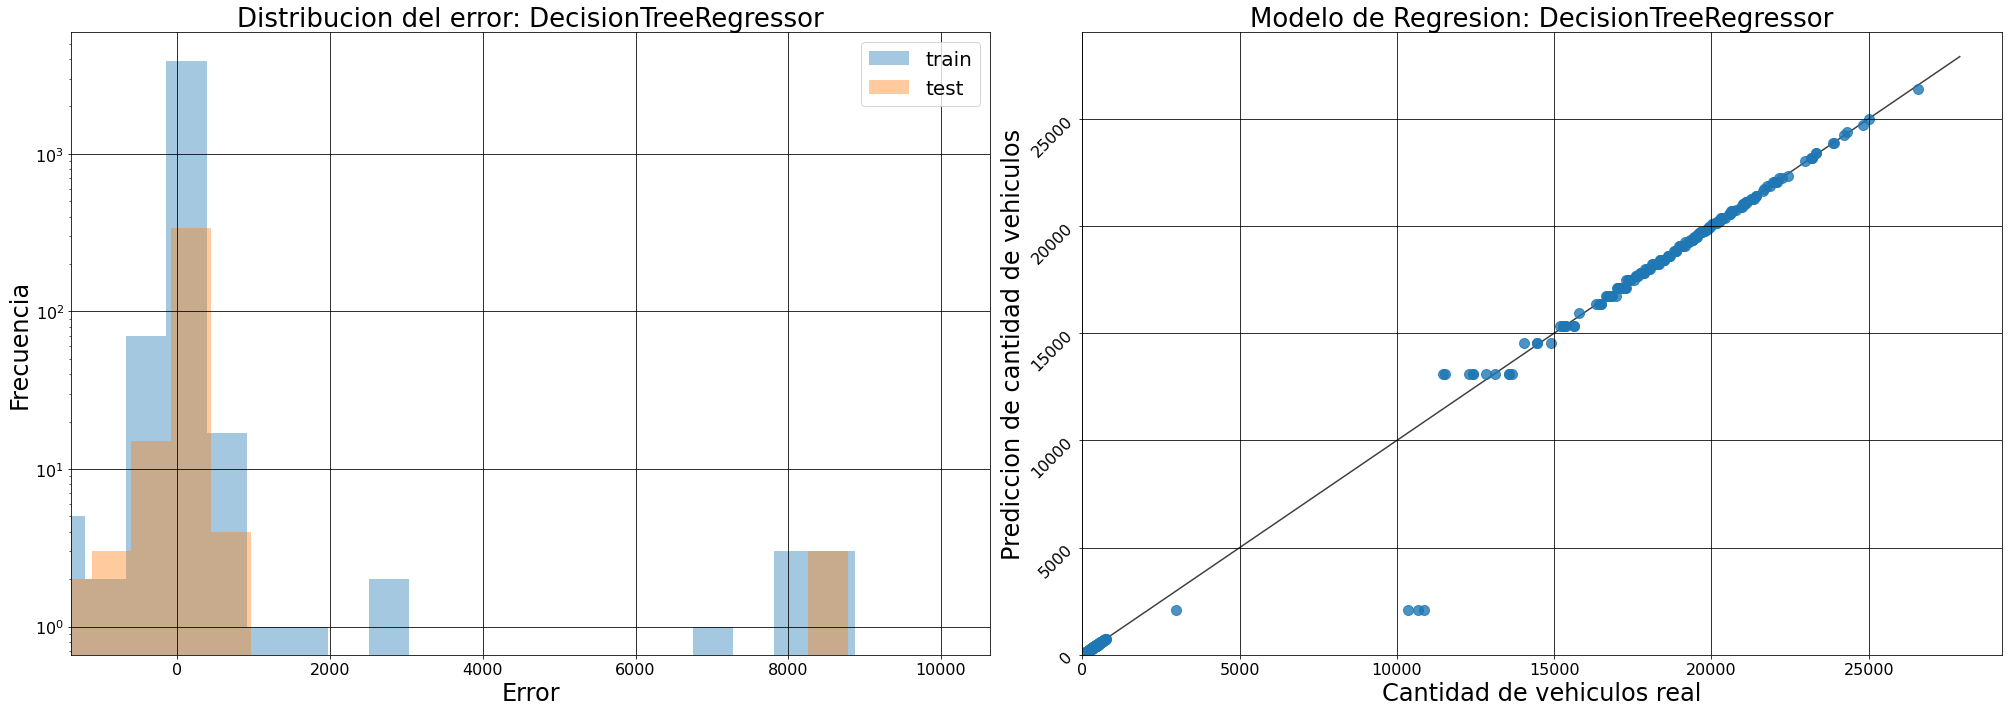

Modelo: XGBRegressor
Error Medio Absoluto en Train: 6.542256076407254
Error Medio Absoluto en Test: 17.62923382676166


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


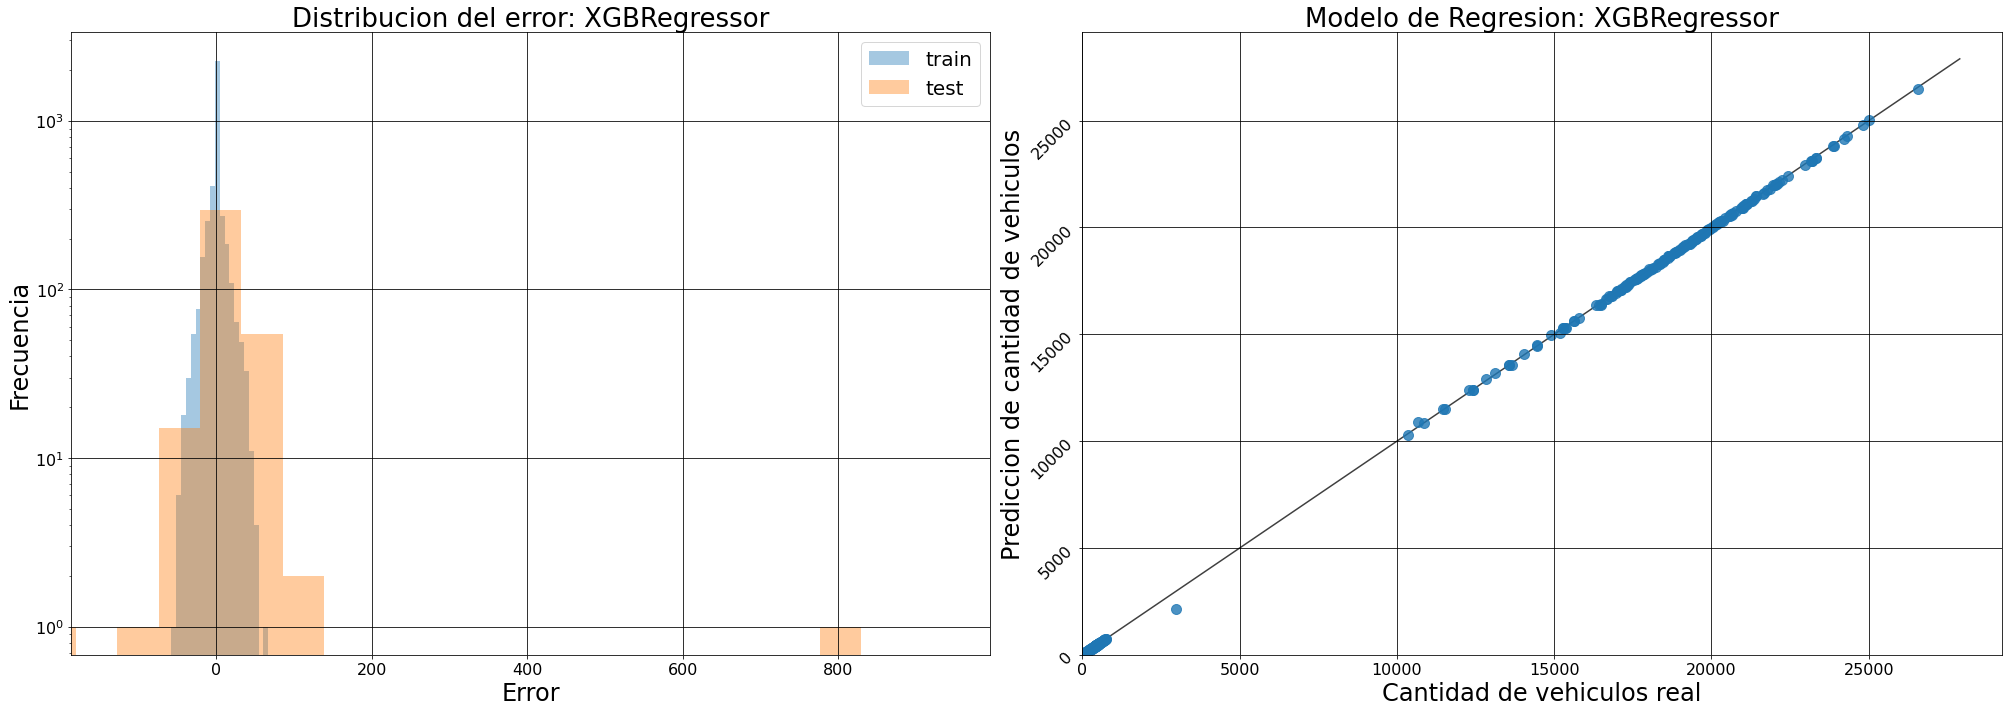

In [136]:
modelos = ["KNeighborsRegressor","DecisionTreeRegressor","XGBRegressor"]

for i, model in enumerate([model_1, model_2, model_3]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    
    print(f"Modelo: {modelos[i]}")

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    print(f"Error Medio Absoluto en Train: {mae_train}")
    print(f"Error Medio Absoluto en Test: {mae_test}")
    
    
    plt.figure(figsize = (28,10))
    plt.subplot(1,2,1)
    
    sns.distplot(y_train - y_train_pred,
                 bins = 20,
                 label = "train",
                 hist = True,
                 kde = False,
                 norm_hist = False)
    
    sns.distplot(y_test - y_test_pred,
                 bins = 20,
                 label = "test",
                 hist = True,
                 kde = False, 
                 norm_hist = False)
    
    plt.xlabel("Error", fontsize = 24)
    plt.xticks(fontsize = 16)
    
    plt.xlim((y_train - y_train_pred).append(y_test - y_test_pred).min() * 0.8, 
             (y_train - y_train_pred).append(y_test - y_test_pred).max() * 1.2)
    
    plt.ylabel("Frecuencia", fontsize = 24)
    plt.yscale("log")
    plt.yticks(fontsize = 16)
    plt.legend(fontsize = 20)
    plt.title("Distribucion del error: " + modelos[i], fontsize = 26)
    plt.grid(c = "k")


    ax = plt.subplot(1,2,2)
    ax.scatter(x = y_test, y = y_test_pred, s = 100, alpha = 0.8)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
    plt.xlabel("Cantidad de vehiculos real", fontsize = 24)
    plt.xticks(fontsize = 16)
    plt.ylabel("Prediccion de cantidad de vehiculos", fontsize = 24)
    plt.yticks(rotation = 45, fontsize = 16)
    plt.title("Modelo de Regresion: " + modelos[i], fontsize = 26)
    
    plt.xlim(0, y_test.max() * 1.1)
    plt.ylim(0, y_test_pred.max() * 1.1)
    plt.grid(c = "k")
    
    plt.tight_layout()
    plt.show()

Recordando que la cantidad de vehiculos de menor frecuencia se encuentra clusterizada en tipo "pesados" y la de mayor en "livianos". Graficamente, aquellos scatters más cercanos al cero se encuentran representados en su mayoria por vehiculos pesados y luego el resto son todos vehiculos livianos.

## Interpretacion de los errores

* Presentan distribuciones aproximadamente normales con algunos outliers.
* Podemos notar que el modelo de vecinos mas cercanos se encuentra en overfitting, este no es el caso para los otros dos modelos.

### Donde es mayor el error?

* los errores son mayores en cercania del rango entre 10000 y 15000 vehiculos.  

### Donde acierta?

* En las bajas frecuencias de cantidad de vehiculos (correspondiente a vehiculos pesados).
* En las altas frecuencias ~15000 en adelante  (correspondiente a vehiculos livianos).

Importante: Estas graficas no muestran informacion acerca del desempeño del modelo a través del tiempo ni discrimina por los tipos de variables de categoricas.

### Estudio Desempeño de los modelos en el tiempo

Nota: separo por tipo de vehiculos para no sobrecargar las visualizaciones

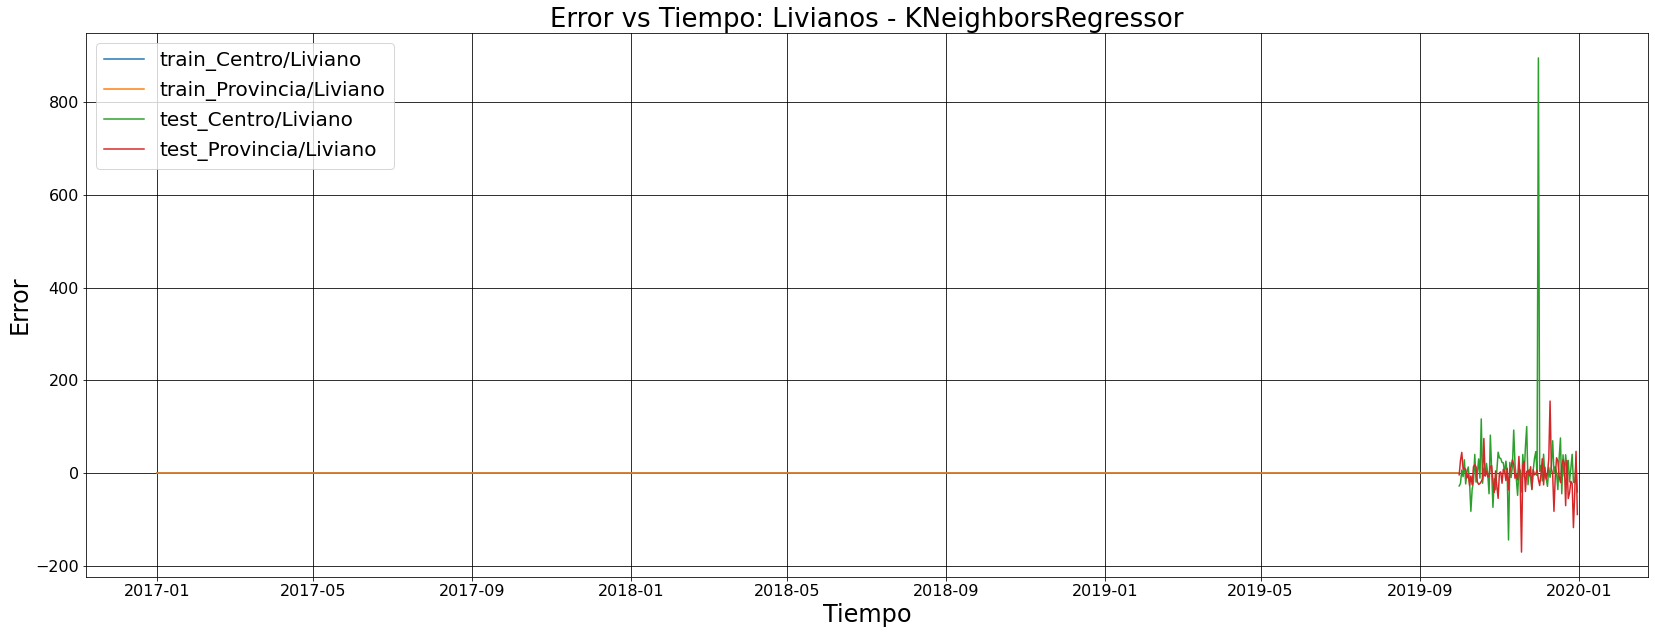

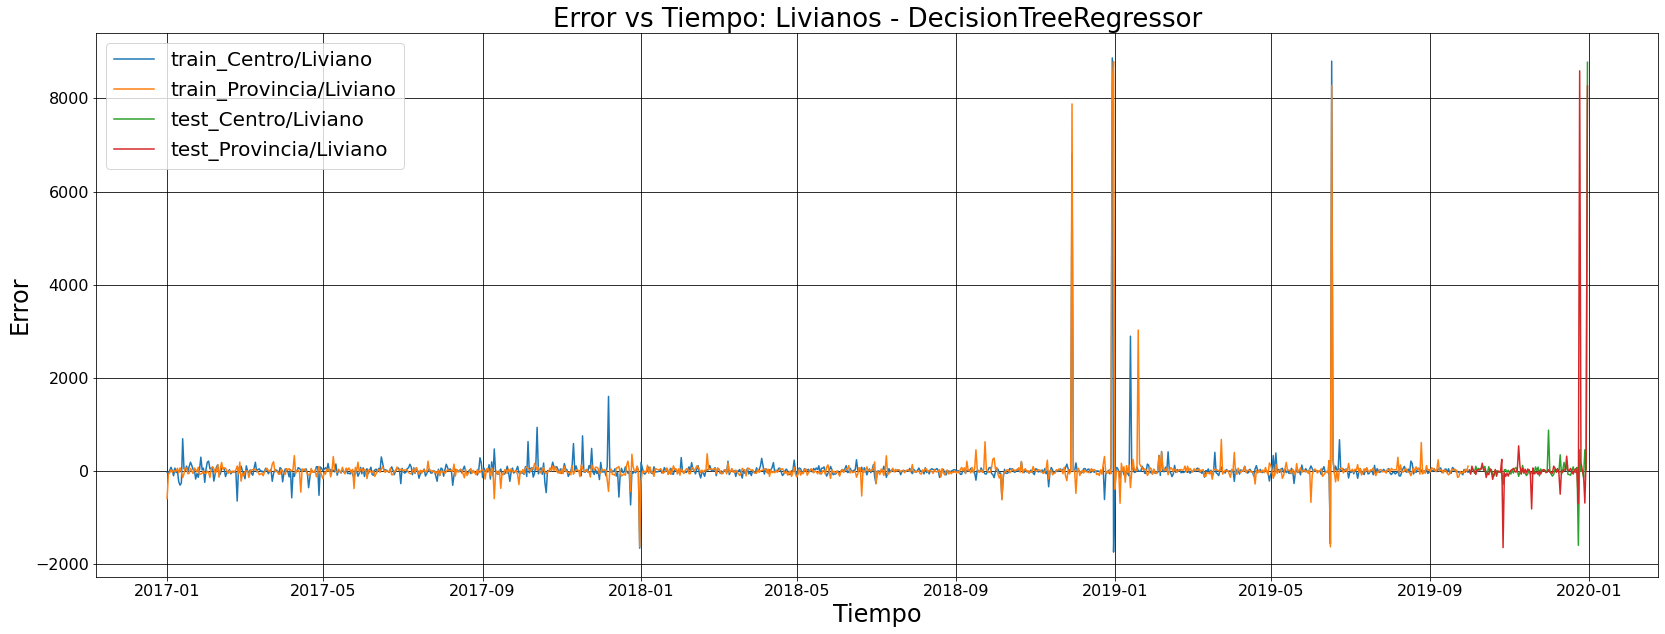

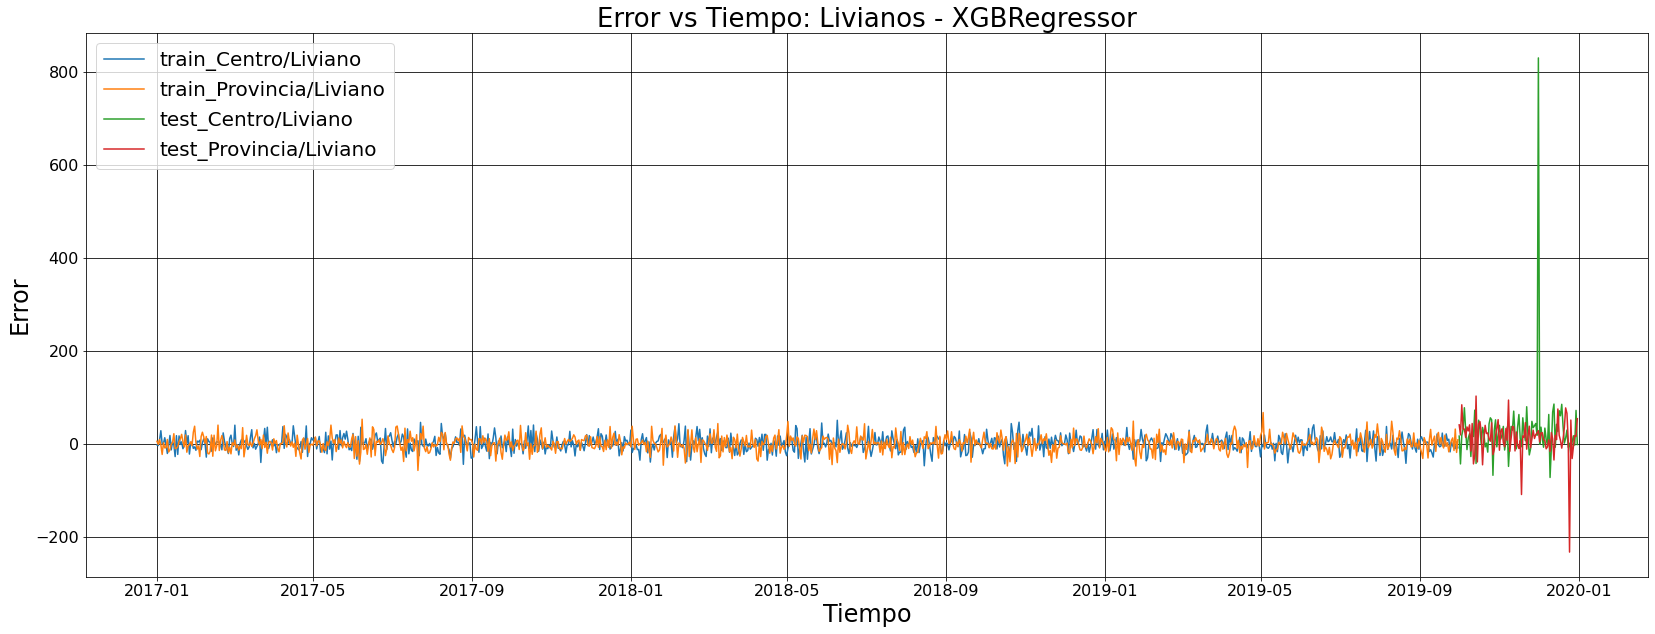

In [137]:
# Analizo los errores en el tiempo

modelos = ["KNeighborsRegressor","DecisionTreeRegressor","XGBRegressor"]

for i, model in enumerate([model_1, model_2, model_3]):
        
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
        
    df_aux_train = pd.DataFrame(data = {"error" : (y_train - y_train_pred),
                                        "fecha" : X_train["fecha_numeros"].apply(dt.datetime.fromordinal),
                                        "Centro" : X_train["x0_Centro"],
                                        "Liviano" : X_train["x1_Liviano"],
                                        }
                               )

    df_aux_test = pd.DataFrame(data = {"error" : (y_test - y_test_pred),
                                       "fecha" : X_test["fecha_numeros"].apply(dt.datetime.fromordinal),
                                       "Centro" : X_test["x0_Centro"],
                                       "Liviano" : X_test["x1_Liviano"],
                                      }
                              )

    plt.figure(figsize = (28,10))
    
    #TRAIN
    #Centro/Liviano
    sns.lineplot(data = df_aux_train[(df_aux_train["Centro"] == 1) & (df_aux_train["Liviano"] == 1)], 
                    x = "fecha",
                    y = "error",
                    label = "train_Centro/Liviano")
    
    #Provincia/Liviano
    sns.lineplot(data = df_aux_train[(df_aux_train["Centro"] == 0) & (df_aux_train["Liviano"] == 1)], 
                    x = "fecha",
                    y = "error",
                    label = "train_Provincia/Liviano")
    
    #TEST
    #Centro/Liviano
    sns.lineplot(data = df_aux_test[(df_aux_test["Centro"] == 1) & (df_aux_test["Liviano"] == 1)], 
                 x = "fecha",
                 y = "error",
                 label = "test_Centro/Liviano")
    
    #Provincia/Liviano
    sns.lineplot(data = df_aux_test[(df_aux_test["Centro"] == 0) & (df_aux_test["Liviano"] == 1)], 
                 x = "fecha",
                 y = "error",
                 label = "test_Provincia/Liviano")
    
    
    plt.title("Error vs Tiempo: Livianos - " + modelos[i], fontsize = 26)
        
    plt.xlabel("Tiempo", fontsize = 24)
    plt.xticks(fontsize = 16)
    plt.ylabel("Error", fontsize = 24)
    plt.yticks(fontsize = 16)
    plt.legend(fontsize = 20)
        
    plt.grid(c = "k")

### Errores para vehiculos livianos

Modelos:
* KNN: 
    * En train, se mantiene en 0 (overfitting explicado previamente).
    * En test, hay mayor dispersion de error en dirección al centro.
* Tree: 
    * En train, hay mayor dispersion de error en dirección a la provincia.
    * En test, hay mayor dispersion de error en dirección a la provincia.
* XGBR:
    * En train: baja dispersion en ambos sentidos
    * En test: en direccion a provincia se destacan 2 valores cuya prediccion fue mucho mayor a la realcomparando contra otros errores. Mientras que hacia el centro destaca un valor que predijo una muy baja cantidad pero ocurrió lo opuesto.

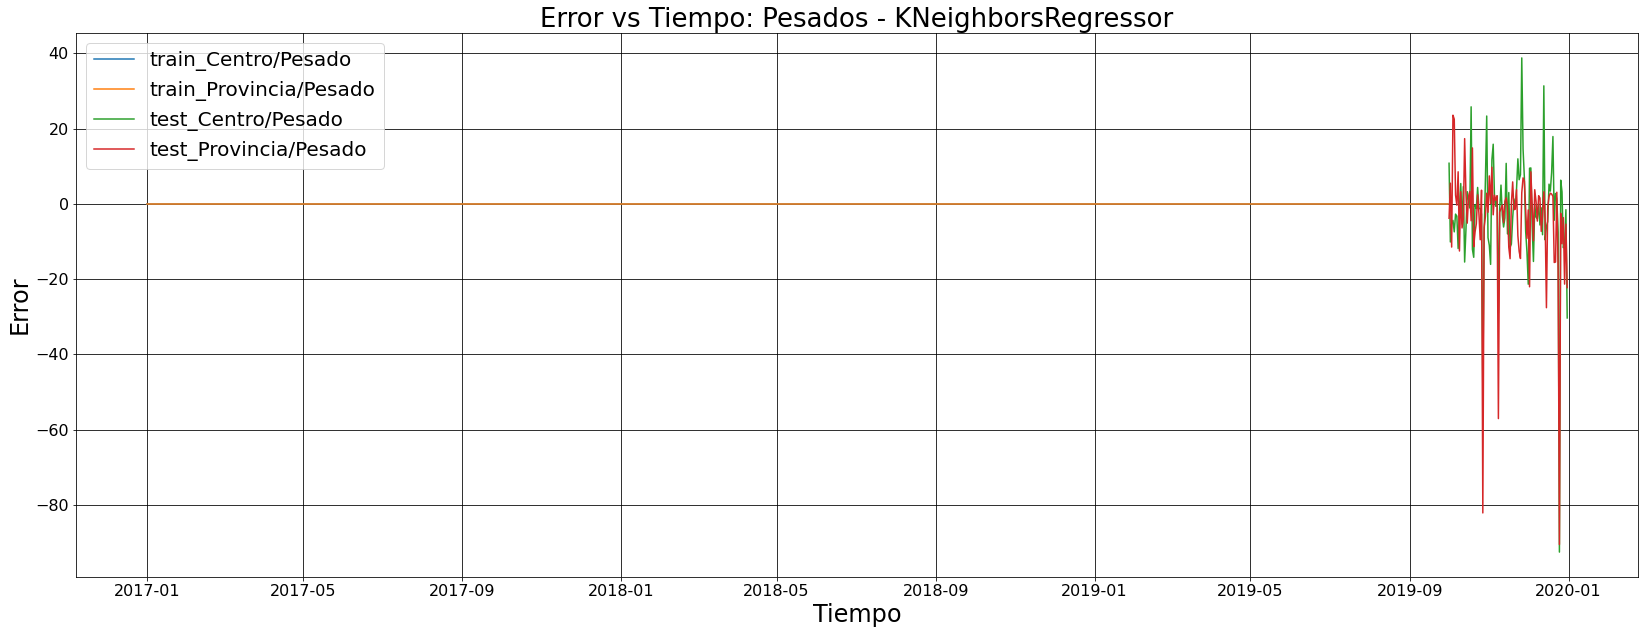

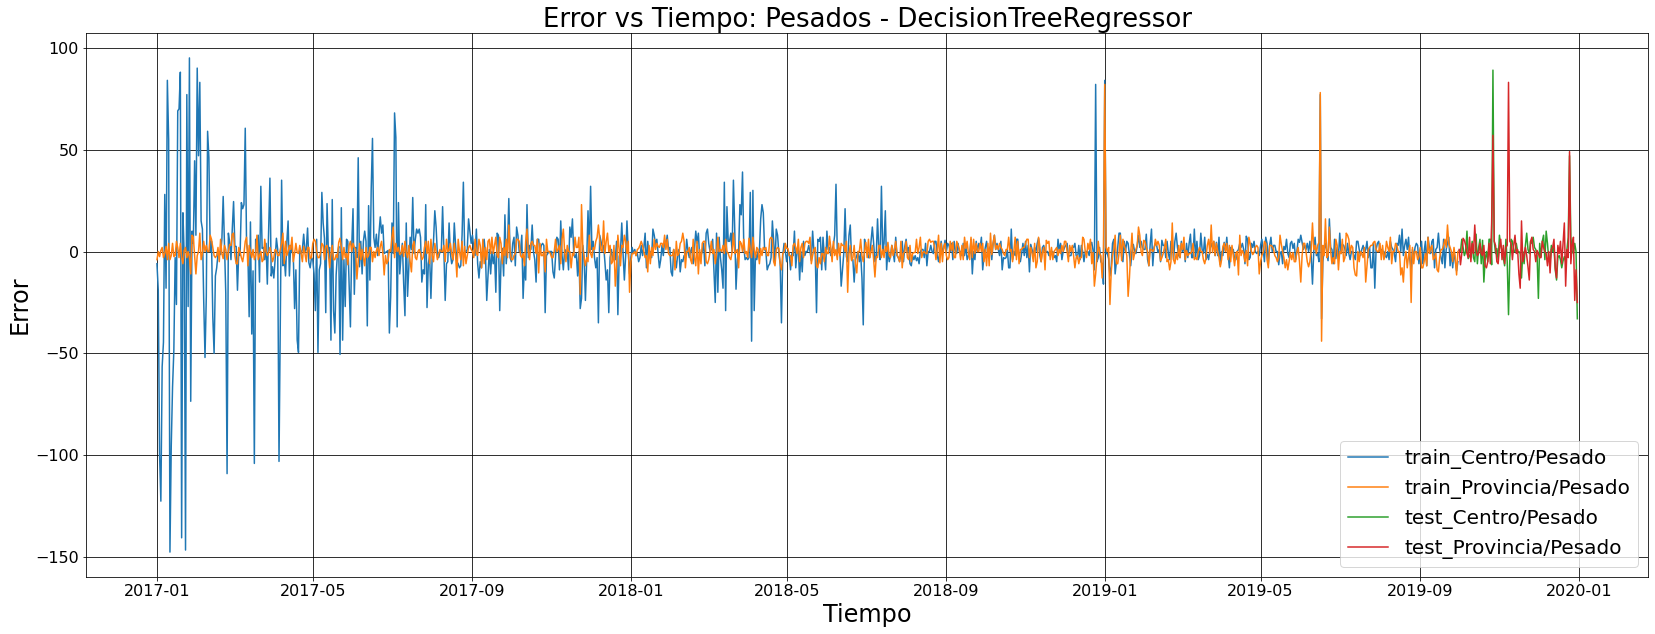

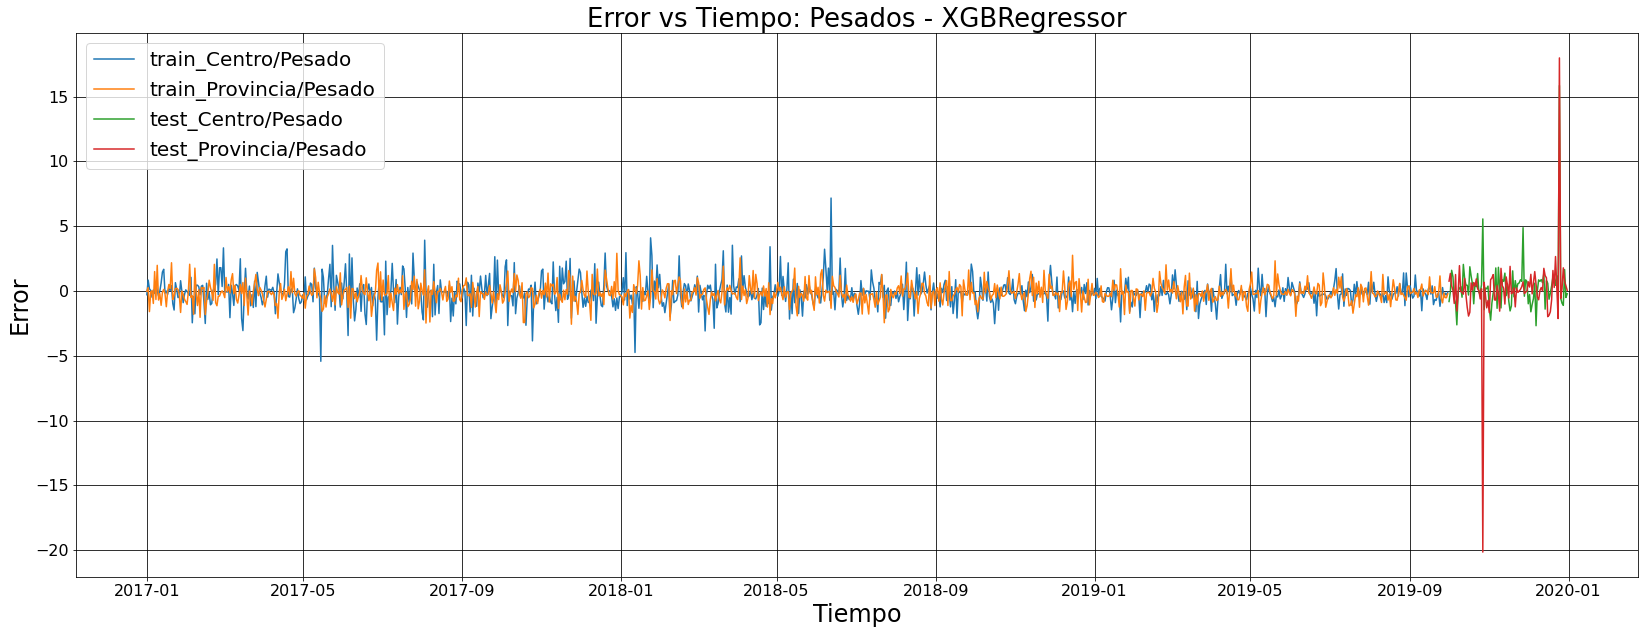

In [138]:
# Analizo los errores en el tiempo

modelos = ["KNeighborsRegressor","DecisionTreeRegressor","XGBRegressor"]

for i, model in enumerate([model_1, model_2, model_3]):
        
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
        
    df_aux_train = pd.DataFrame(data = {"error" : (y_train - y_train_pred),
                                        "fecha" : X_train["fecha_numeros"].apply(dt.datetime.fromordinal),
                                        "Centro" : X_train["x0_Centro"],
                                        "Liviano" : X_train["x1_Liviano"],
                                        }
                               )

    df_aux_test = pd.DataFrame(data = {"error" : (y_test - y_test_pred),
                                       "fecha" : X_test["fecha_numeros"].apply(dt.datetime.fromordinal),
                                       "Centro" : X_test["x0_Centro"],
                                       "Liviano" : X_test["x1_Liviano"],
                                      }
                              )

    plt.figure(figsize = (28,10))
    
    #TRAIN
    
    #Centro/Pesado
    sns.lineplot(data = df_aux_train[(df_aux_train["Centro"] == 1) & (df_aux_train["Liviano"] == 0)], 
                    x = "fecha",
                    y = "error",
                    label = "train_Centro/Pesado")
    
    #Provincia/Pesado
    sns.lineplot(data = df_aux_train[(df_aux_train["Centro"] == 0) & (df_aux_train["Liviano"] == 0)], 
                    x = "fecha",
                    y = "error",
                    label = "train_Provincia/Pesado")
    
    #TEST
    
    #Centro/Pesado
    sns.lineplot(data = df_aux_test[(df_aux_test["Centro"] == 1) & (df_aux_test["Liviano"] == 0)], 
                 x = "fecha",
                 y = "error",
                 label = "test_Centro/Pesado")
    
    #Provincia/Pesado
    sns.lineplot(data = df_aux_test[(df_aux_test["Centro"] == 0) & (df_aux_test["Liviano"] == 0)], 
                 x = "fecha",
                 y = "error",
                 label = "test_Provincia/Pesado")

    
    
    plt.title("Error vs Tiempo: Pesados - " + modelos[i], fontsize = 26)
        
    plt.xlabel("Tiempo", fontsize = 24)
    plt.xticks(fontsize = 16)
    plt.ylabel("Error", fontsize = 24)
    plt.yticks(fontsize = 16)
    plt.legend(fontsize = 20)
        
    plt.grid(c = "k")

### Errores para vehiculos pesados

Modelos:
* KNN: 
    * En train, se mantiene en 0 (overfitting explicado previamente).
    * En test, puede notarse que el modelo tiende a sobreestimar el flujo de camiones en direccion a provincia destacando que hasta contiene valores muy por encima del flujo normal.
* Tree: 
    * En train, en direccion al centro hay gran variabilidad en el comienzo de la serie que luego se amortigua a mediados de 2018. Mientras que en direccion a provincia solo tiene unos pocos valores atipicos.
    * En test, ambos sentidos poseen un comportamiento similar.
* XGBR:
    * En train: en direccion al centro comienza con un nivel de variabilidad que se amortigua a mediados de 2018 (como en Tree, pero un error bastante menor).
    * En test: pueden destacarse unos pocos errores significativos (mayor a +-5 vehiculos de diferencia) em ambos sentidos.

## Elección de modelo: XGBRegressor

Debido al desempeño en los resultados anteriores, demuestra una mayor precision que los demás modelos y margen para aprendizaje (lo cual no es posible en KNN por su overfitting).

## 6 - Prediccion de 2020

In [139]:
data_2020 = pd.read_csv('flujo-vehicular-2020.csv', sep =',')

In [140]:
data_2020.head()

periodo                fecha    mes        dia  dia_fecha  hora_inicio  \
0   2020.0  2020-01-01 00:00:00  enero  Miércoles        1.0          0.0   
1   2020.0  2020-01-01 00:00:00  enero  Miércoles        1.0          0.0   
2   2020.0  2020-01-01 00:00:00  enero  Miércoles        1.0          0.0   
3   2020.0  2020-01-01 00:00:00  enero  Miércoles        1.0          0.0   
4   2020.0  2020-01-01 00:00:00  enero  Miércoles        1.0          0.0   

   hora_fin estacion tipo_vehiculo forma_pago  \
0       1.0  ALBERDI          Auto   Efectivo   
1       1.0  ALBERDI          Auto   Efectivo   
2       1.0  ALBERDI          Auto  Rec.Deuda   
3       1.0  ALBERDI          Auto  Rec.Deuda   
4       1.0  ALBERDI          Auto  Rec.Deuda   

                        observacion    sentido  cantidad_pasos  
0                          Efectivo     Centro            24.0  
1                          Efectivo  Provincia            80.0  
2                Paso en Infracción  Provincia             1.0  
3  Paso en infracción con Multa LPR     Centro             1.0  
4  Paso en infracción con Multa LPR  Provincia             1.0

El tipo de vehiculo inicia con "auto" en lugar de "liviano" o "pesado"

In [141]:
data_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533743 entries, 0 to 2533742
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   periodo         float64
 1   fecha           object 
 2   mes             object 
 3   dia             object 
 4   dia_fecha       float64
 5   hora_inicio     float64
 6   hora_fin        float64
 7   estacion        object 
 8   tipo_vehiculo   object 
 9   forma_pago      object 
 10  observacion     object 
 11  sentido         object 
 12  cantidad_pasos  float64
dtypes: float64(5), object(8)
memory usage: 251.3+ MB


In [142]:
data_2020.tipo_vehiculo.unique()

array(['Auto', 'Auto con trailer', 'Moto', 'N/D', 'Pago Doble Auto',
       'Pago Doble Auto con trailer / Pesado 2 Ejes', 'Pago doble Moto',
       'Pesados 2 Ejes', 'Pesados 3 Ejes', 'Pesados 4 Ejes',
       'Pesados 5 Ejes', 'Pesados 6 Ejes'], dtype=object)

Para poder continuar el analisis analogamente a años anteriores, todo aquello que contenga la palabra "Pesado" o "Pesados" será convertido a "Pesado". Los demás tipos de vehiculos serán convertidos a "Liviano".

In [143]:
lista_pesado = ['Pago Doble Auto con trailer / Pesado 2 Ejes',
                'Pesados 2 Ejes', 
                'Pesados 3 Ejes', 
                'Pesados 4 Ejes',
                'Pesados 5 Ejes', 
                'Pesados 6 Ejes']

In [144]:
data_2020["tipo_vehiculo"] = data_2020["tipo_vehiculo"].apply(lambda x: "Pesado" if x in lista_pesado else "Liviano")

In [145]:
data_2020.tipo_vehiculo.unique()

array(['Liviano', 'Pesado'], dtype=object)

In [146]:
# Verifico que no haya errores correspondientes al nombre de la estacion

data_2020.estacion.unique()

array(['ALBERDI', 'AVELLANEDA', 'DELLEPIANE LINIERSLEPIANE CENTRO',
       'DELLEPIANE LINIERS', 'ILLIA', 'ILP', 'PB1', 'PB3', 'PB4',
       'RETIRO', 'SALGUERO', 'SARMIENTO', 'PB2'], dtype=object)

In [147]:
# Verifico que no haya otros errores correspondientes a la forma de pago

data_2020.forma_pago.unique()

array(['Efectivo', 'Rec.Deuda', 'Tarjeta Magnética', 'Tag', 'Exento',
       'Violación', 'CPP', 'Mercado Pago'], dtype=object)

Notar que ahora efectivo es sin mayusculas

In [148]:
# Verifico que no haya errores en el sentido

data_2020.sentido.unique()

array(['Centro', 'Provincia'], dtype=object)

In [149]:
# Subset de estacion y forma de pago

df_2020 = data_2020[(data_2020["estacion"] == "ILLIA") & (data_2020["forma_pago"] == "Efectivo")]

In [150]:
df_2020.drop(labels = ["periodo","mes","dia","dia_fecha","hora_inicio","hora_fin","observacion"], 
             axis = 1, 
             inplace = True)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [151]:
df_2020.groupby(by = ["fecha","estacion","forma_pago","tipo_vehiculo","sentido"],as_index=False)["cantidad_pasos"].sum()

fecha estacion forma_pago tipo_vehiculo    sentido  \
0     2020-01-01 00:00:00    ILLIA   Efectivo       Liviano     Centro   
1     2020-01-01 00:00:00    ILLIA   Efectivo       Liviano  Provincia   
2     2020-01-01 00:00:00    ILLIA   Efectivo        Pesado     Centro   
3     2020-01-01 00:00:00    ILLIA   Efectivo        Pesado  Provincia   
4     2020-01-02 00:00:00    ILLIA   Efectivo       Liviano     Centro   
...                   ...      ...        ...           ...        ...   
1220           2020-12-30    ILLIA   Efectivo        Pesado  Provincia   
1221           2020-12-31    ILLIA   Efectivo       Liviano     Centro   
1222           2020-12-31    ILLIA   Efectivo       Liviano  Provincia   
1223           2020-12-31    ILLIA   Efectivo        Pesado     Centro   
1224           2020-12-31    ILLIA   Efectivo        Pesado  Provincia   

      cantidad_pasos  
0            11190.0  
1            10051.0  
2               91.0  
3               63.0  
4            17637.0  
...              ...  
1220           111.0  
1221          3397.0  
1222          3065.0  
1223            48.0  
1224            43.0  

[1225 rows x 6 columns]

In [152]:
df_2020["fecha"] = pd.to_datetime(df_2020["fecha"])

<ipython-input-152-9e948474d6a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020["fecha"] = pd.to_datetime(df_2020["fecha"])


In [153]:
# Construccion del calendario completo
calendario_2020 = pd.Series(pd.date_range(start = "2020-01-01",
                                          end = "2020-12-31", 
                                          freq = "D"))

In [154]:
calendario_2020.shape[0] - len(df_2020.fecha.unique())

59

## Faltan 59 fechas! Cuales?

In [155]:
faltantes_2020 = set(calendario_2020) - set(df_2020.fecha)

faltantes_2020

{Timestamp('2020-03-20 00:00:00'),
 Timestamp('2020-03-21 00:00:00'),
 Timestamp('2020-03-22 00:00:00'),
 Timestamp('2020-03-23 00:00:00'),
 Timestamp('2020-03-24 00:00:00'),
 Timestamp('2020-03-25 00:00:00'),
 Timestamp('2020-03-26 00:00:00'),
 Timestamp('2020-03-27 00:00:00'),
 Timestamp('2020-03-28 00:00:00'),
 Timestamp('2020-03-29 00:00:00'),
 Timestamp('2020-03-30 00:00:00'),
 Timestamp('2020-03-31 00:00:00'),
 Timestamp('2020-04-01 00:00:00'),
 Timestamp('2020-04-02 00:00:00'),
 Timestamp('2020-04-03 00:00:00'),
 Timestamp('2020-04-04 00:00:00'),
 Timestamp('2020-04-05 00:00:00'),
 Timestamp('2020-04-06 00:00:00'),
 Timestamp('2020-04-07 00:00:00'),
 Timestamp('2020-04-08 00:00:00'),
 Timestamp('2020-04-09 00:00:00'),
 Timestamp('2020-04-10 00:00:00'),
 Timestamp('2020-04-11 00:00:00'),
 Timestamp('2020-04-12 00:00:00'),
 Timestamp('2020-04-13 00:00:00'),
 Timestamp('2020-04-14 00:00:00'),
 Timestamp('2020-04-15 00:00:00'),
 Timestamp('2020-04-16 00:00:00'),
 Timestamp('2020-04-

In [156]:
inicio = data_2020["fecha"] >= "2020-03-20"
fin = data_2020["fecha"] <= "2020-05-18"
illia = data_2020["estacion"] == "ILLIA"
efectivo = data_2020["forma_pago"] == "Efectivo"

illia_covid = data_2020[inicio & fin & illia & efectivo]

illia_covid

periodo       fecha   mes    dia  dia_fecha  hora_inicio  hora_fin  \
835334   2020.0  2020-05-11  mayo  Lunes       11.0         20.0      21.0   

       estacion tipo_vehiculo forma_pago observacion sentido  cantidad_pasos  
835334    ILLIA       Liviano   Efectivo    Efectivo  Centro             1.0

## Explicacion de faltantes

El periodo de tiempo identificado coincide en la ventana de tiempo en la cual el gobierno estableció políticas de aislamiento y estricta regulación a la circulación en Argentina. Solo tenían permitido circular aquellos de "personal esencial" (personal de salud, seguridad, politicos, etc), quienes muy probablemente estarian utilizando un metodo diferente a pago efectivo.

In [157]:
# Adicional: hubo una restriccion ABSOLUTA de circulacion? Si no la hubo, que metodo fue el mas utilizado?

data_2020[inicio & fin & illia].pivot_table(values = "cantidad_pasos",
                                            index = "forma_pago",
                                            aggfunc = "sum").sort_values(by ="cantidad_pasos",
                                                                         ascending = False)

cantidad_pasos
forma_pago                
Tag               517018.0
Violación         404070.0
CPP               169057.0
Exento               183.0
Efectivo               1.0

Telepase fue reemplazado por Tag.
CPP son aquellos vehiculos no adheridos a Telepase que deben abonar el peaje.

Explicacion de Tag y CPP: https://www.ausa.com.ar/novedades/autopistas-sin-barreras-desde-manana-los-peajes-portenos-funcionaran-solo-con-telepase-y-con-cobro-por-patente-durante-la-noche/

In [158]:
df_2020.head()

fecha estacion tipo_vehiculo forma_pago    sentido  cantidad_pasos
52  2020-01-01    ILLIA       Liviano   Efectivo     Centro           326.0
53  2020-01-01    ILLIA       Liviano   Efectivo  Provincia           319.0
134 2020-01-01    ILLIA       Liviano   Efectivo     Centro           199.0
135 2020-01-01    ILLIA       Liviano   Efectivo  Provincia           180.0
202 2020-01-01    ILLIA       Liviano   Efectivo     Centro           114.0

In [159]:
# Completo el calendario para los valores faltantes

# Comienzo por "liviano"-"centro"

parte_1_2020 = pd.DataFrame(data = list(faltantes_2020)).rename(columns={0:"fecha"})

parte_1_2020["tipo_vehiculo"] = pd.Series("Liviano" for i in range(parte_1_2020.shape[0]))

parte_1_2020["sentido"] = pd.Series("Centro" for i in range(parte_1_2020.shape[0]))

parte_1_2020["cantidad_pasos"] = pd.Series(0 for i in range(parte_1_2020.shape[0]))

# Sigo con "liviano"-"provincia"

parte_2_2020 = parte_1_2020.copy()

parte_2_2020["sentido"] = pd.Series("Provincia" for i in range(parte_1_2020.shape[0]))

# Sigo con "pesado"-"centro"

parte_3_2020 = parte_1_2020.copy()

parte_3_2020["tipo_vehiculo"] = pd.Series("Pesado" for i in range(parte_1_2020.shape[0]))

# Termino con "pesado"-"provincia"

parte_4_2020 = parte_3_2020.copy()

parte_4_2020["sentido"] = pd.Series("Provincia" for i in range(parte_1_2020.shape[0]))

In [160]:
# Uno todas las partes

datos_faltantes_2020 = parte_1_2020.append(parte_2_2020).append(parte_3_2020).append(parte_4_2020)

datos_faltantes_2020.head().append(datos_faltantes_2020.tail())

fecha tipo_vehiculo    sentido  cantidad_pasos
0  2020-03-20       Liviano     Centro               0
1  2020-04-10       Liviano     Centro               0
2  2020-05-17       Liviano     Centro               0
3  2020-04-13       Liviano     Centro               0
4  2020-04-24       Liviano     Centro               0
54 2020-04-26        Pesado  Provincia               0
55 2020-04-05        Pesado  Provincia               0
56 2020-05-16        Pesado  Provincia               0
57 2020-04-30        Pesado  Provincia               0
58 2020-04-21        Pesado  Provincia               0

In [161]:
# Quito las columnas de estacion y forma de pago

df_2020.drop(labels = ["estacion","forma_pago"],
             axis = 1, 
             inplace = True)

# Completo el dataset con los datos faltantes, ordenando por fecha

df_2020_completo = df_2020.append(datos_faltantes_2020).sort_values(by = "fecha", ascending = True).reset_index(drop=True)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [162]:
# Chequeo...

set(calendario_2020) - set(df_2020_completo.fecha)

set()

In [163]:
df_2020_completo.head()

fecha tipo_vehiculo    sentido  cantidad_pasos
0 2020-01-01       Liviano     Centro           326.0
1 2020-01-01       Liviano  Provincia             2.0
2 2020-01-01        Pesado     Centro             1.0
3 2020-01-01        Pesado  Provincia             2.0
4 2020-01-01        Pesado     Centro             2.0

Todas las fechas se encuentran en el calendario

### Aplico todas las transformaciones ya realizadas previamente

In [164]:
# Label Encoding para el calendario

df_2020_completo["day_num"] = df_2020_completo.fecha.dt.day # Dia
df_2020_completo["month_num"] = df_2020_completo.fecha.dt.month # Mes
df_2020_completo["year_num"] = df_2020_completo.fecha.dt.year # Año

# Construyo 2 nuevas columnas que contengan los dias de la semana numerados
# 0: Lunes, 1: Martes, ... , 6: Domingo

df_2020_completo["dia_sem"] = df_2020_completo.fecha.dt.weekday
df_2020_completo["fin_sem"] = df_2020_completo.fecha.dt.weekday

# Armo el one hot encoding con la siguiente regla:

df_2020_completo["dia_sem"] = df_2020_completo["dia_sem"].apply(lambda x: 1 if x <= 4 else 0) # Implica que es un dia de semana, ya que 4 = Viernes
df_2020_completo["fin_sem"] = df_2020_completo["fin_sem"].apply(lambda x: 1 if x > 4 else 0) # Implica que es un fin de semana

In [165]:
# Armo one hot encoding para el sentido y el tipo de vehiculo

cat_features = ["sentido","tipo_vehiculo"]
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False).fit(df_2020_completo[cat_features])
label_names = list(ohe.get_feature_names())
label_names

['x0_Centro', 'x0_Provincia', 'x1_Liviano', 'x1_Pesado']

In [166]:
ohe_df = pd.DataFrame(ohe.transform(df_2020_completo[cat_features]), columns = label_names)
ohe_df = ohe_df.set_index(keys = df_2020_completo.index)

In [167]:
df_2020_completo = df_2020_completo.join(ohe_df, on = df_2020_completo.index)

df_2020_completo[label_names] = df_2020_completo[label_names].astype(dtype = "int")

In [168]:
df_2020_completo.drop(labels = cat_features, 
                      axis = 1,
                      inplace = True)

In [169]:
df_2020_completo["fecha_numeros"] = df_2020_completo.fecha.map(dt.datetime.toordinal)

In [170]:
# Paso a tipo entero los features cantidad_pasos, day_num, month_num, year_num

df_2020_completo[["cantidad_pasos", "day_num", "month_num", "year_num"]] = df_2020_completo[["cantidad_pasos", "day_num", "month_num", "year_num"]].astype(dtype="int")

In [171]:
df_2020_completo.head()

fecha  cantidad_pasos  day_num  month_num  year_num  dia_sem  fin_sem  \
0 2020-01-01             326        1          1      2020        1        0   
1 2020-01-01               2        1          1      2020        1        0   
2 2020-01-01               1        1          1      2020        1        0   
3 2020-01-01               2        1          1      2020        1        0   
4 2020-01-01               2        1          1      2020        1        0   

   x0_Centro  x0_Provincia  x1_Liviano  x1_Pesado  fecha_numeros  
0          1             0           1          0         737425  
1          0             1           1          0         737425  
2          1             0           0          1         737425  
3          0             1           0          1         737425  
4          1             0           0          1         737425

In [172]:
df.head()

fecha  cantidad_pasos  day_num  month_num  year_num  dia_sem  fin_sem  \
0 2017-01-01           16681        1          1      2017        0        1   
1 2017-01-01             370        1          1      2017        0        1   
2 2017-01-01           13960        1          1      2017        0        1   
3 2017-01-01             172        1          1      2017        0        1   
4 2017-01-02           26011        2          1      2017        1        0   

   x0_Centro  x0_Provincia  x1_Liviano  x1_Pesado  fecha_numeros  
0          1             0           1          0         736330  
1          1             0           0          1         736330  
2          0             1           1          0         736330  
3          0             1           0          1         736330  
4          1             0           1          0         736331

## Test 2020

In [173]:
X_test_2020 = df_2020_completo.drop(labels = "fecha", axis = 1) # 2020

y_test_2020 = df_2020_completo["cantidad_pasos"] # 2020

### Evaluacion de los modelos - 2020

### KNeighborsRegressor

In [174]:
print(f"El RMSE en Prueba: {np.sqrt(mean_squared_error(y_test_2020, model_1.predict(X_test_2020)))}" + "\n")

print(f"El MAE en Prueba: {mean_absolute_error(y_test_2020, model_1.predict(X_test_2020))}")

El RMSE en Prueba: 53.56935986282104

El MAE en Prueba: 28.30765701703561


### DecisionTreeRegressor

In [175]:
print(f"El RMSE en Prueba: {np.sqrt(mean_squared_error(y_test_2020, model_2.predict(X_test_2020)))}" + "\n")

print(f"El MAE en Prueba: {mean_absolute_error(y_test_2020, model_2.predict(X_test_2020))}")

El RMSE en Prueba: 22.160052015760023

El MAE en Prueba: 12.987093708420453


### XGBRegressor

In [176]:
print(f"El RMSE en Prueba: {np.sqrt(mean_squared_error(y_test_2020, model_3.predict(X_test_2020)))}" + "\n")

print(f"El MAE en Prueba: {mean_absolute_error(y_test_2020, model_3.predict(X_test_2020))}")

El RMSE en Prueba: 4.8791228221926275

El MAE en Prueba: 2.8122512336421708


### Distribucion de los errores

Modelo: KNeighborsRegressor
Error Medio Absoluto en Train: 0.0
Error Medio Absoluto en Test: 28.30765701703561


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


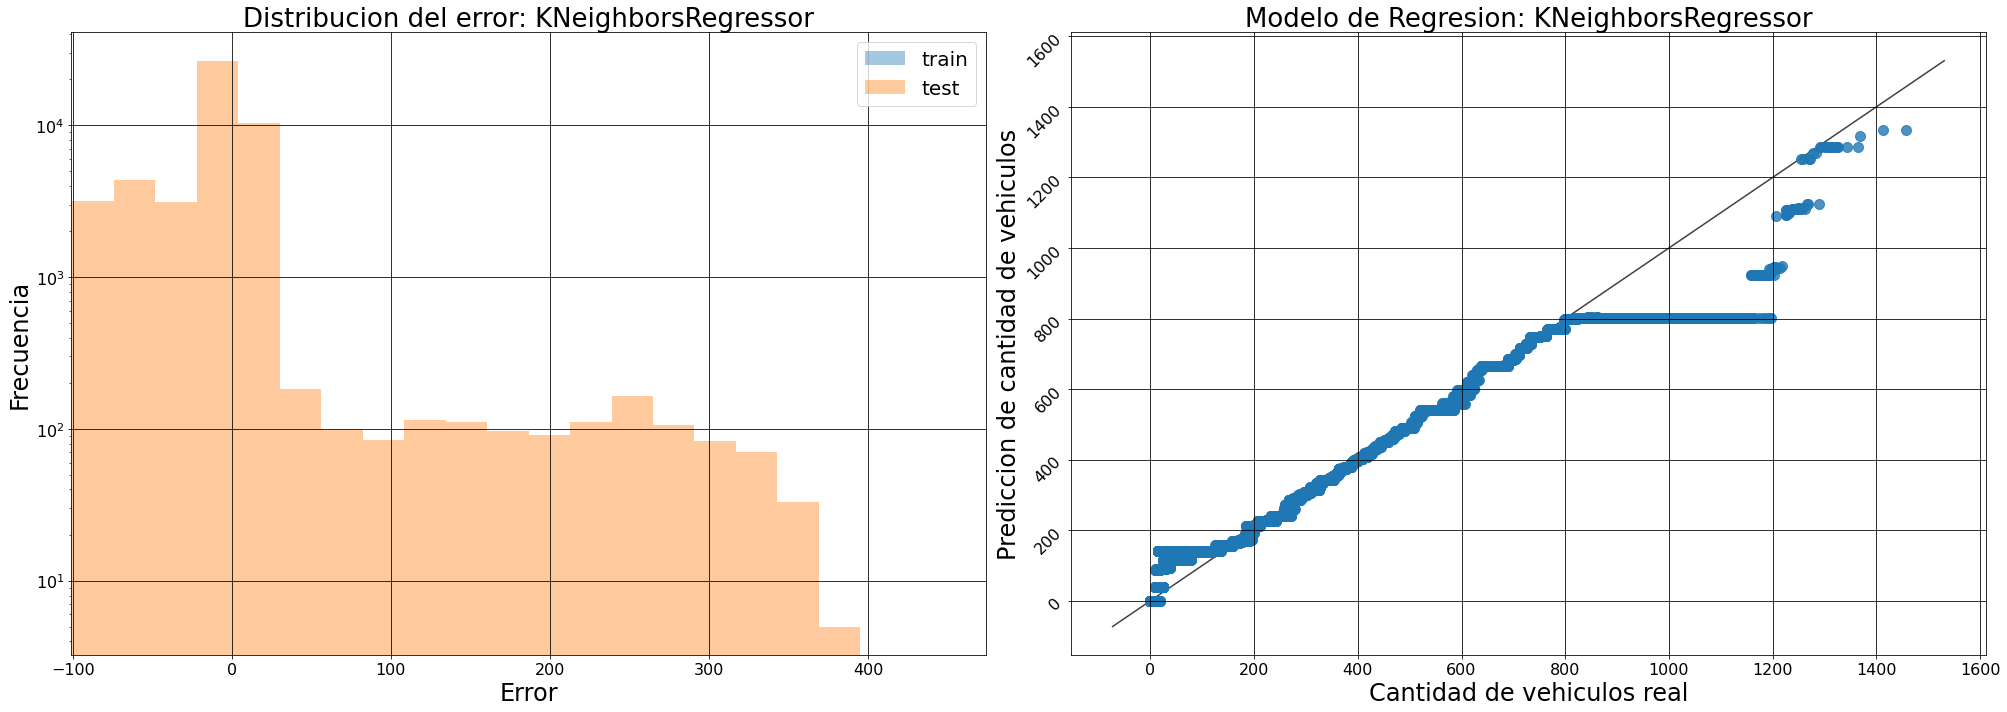

Modelo: DecisionTreeRegressor
Error Medio Absoluto en Train: 52.005236907730676
Error Medio Absoluto en Test: 12.987093708420453


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


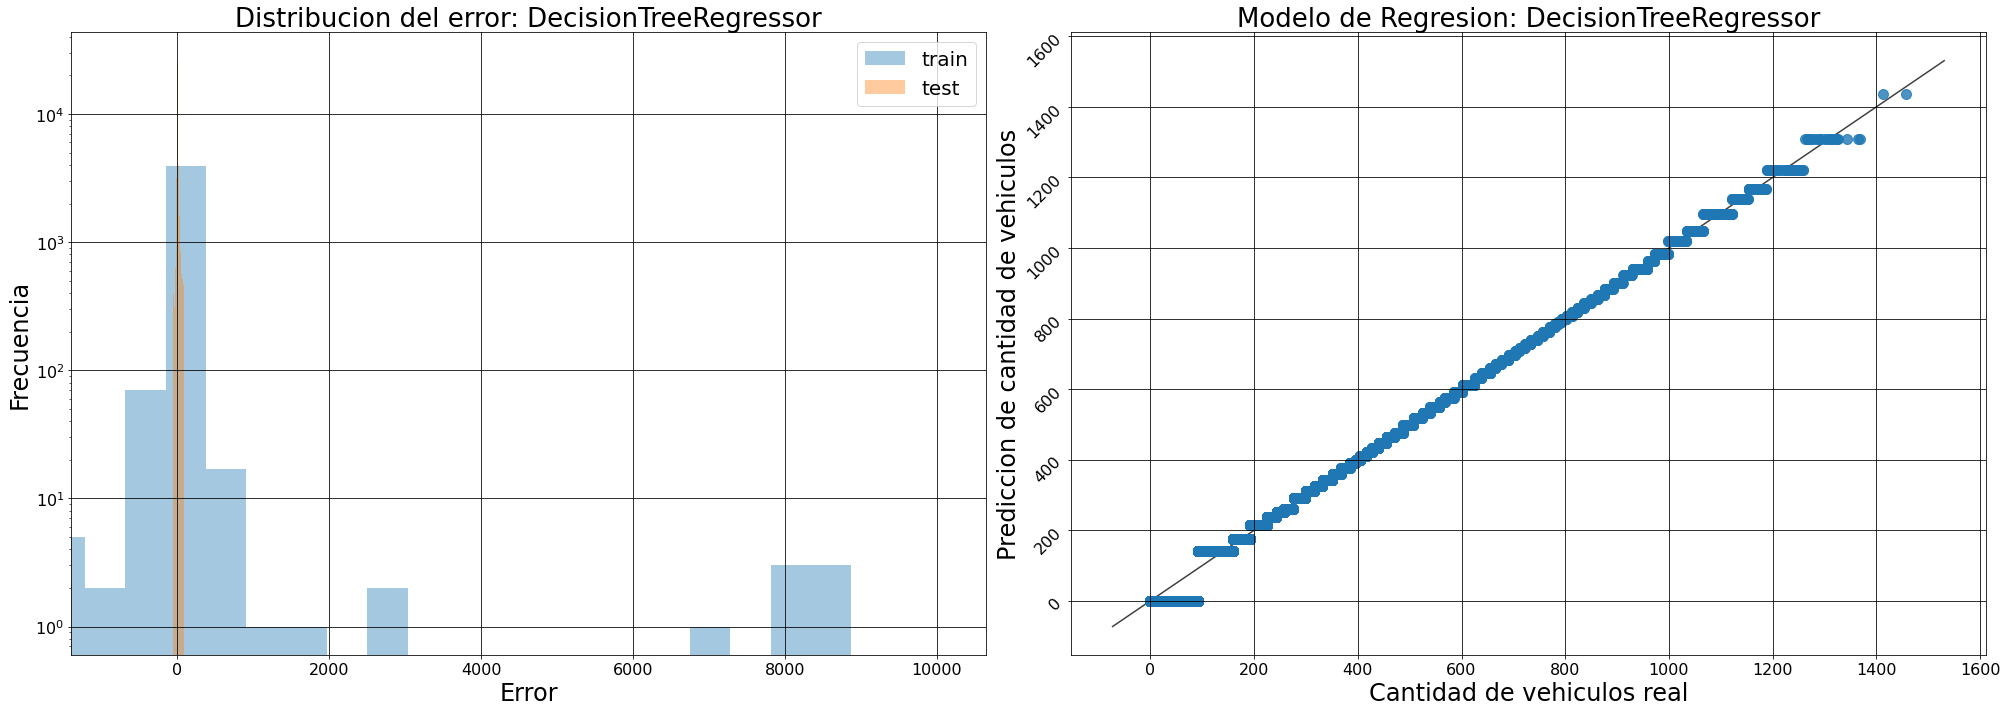

Modelo: XGBRegressor
Error Medio Absoluto en Train: 6.542256076407254
Error Medio Absoluto en Test: 2.8122512336421708


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


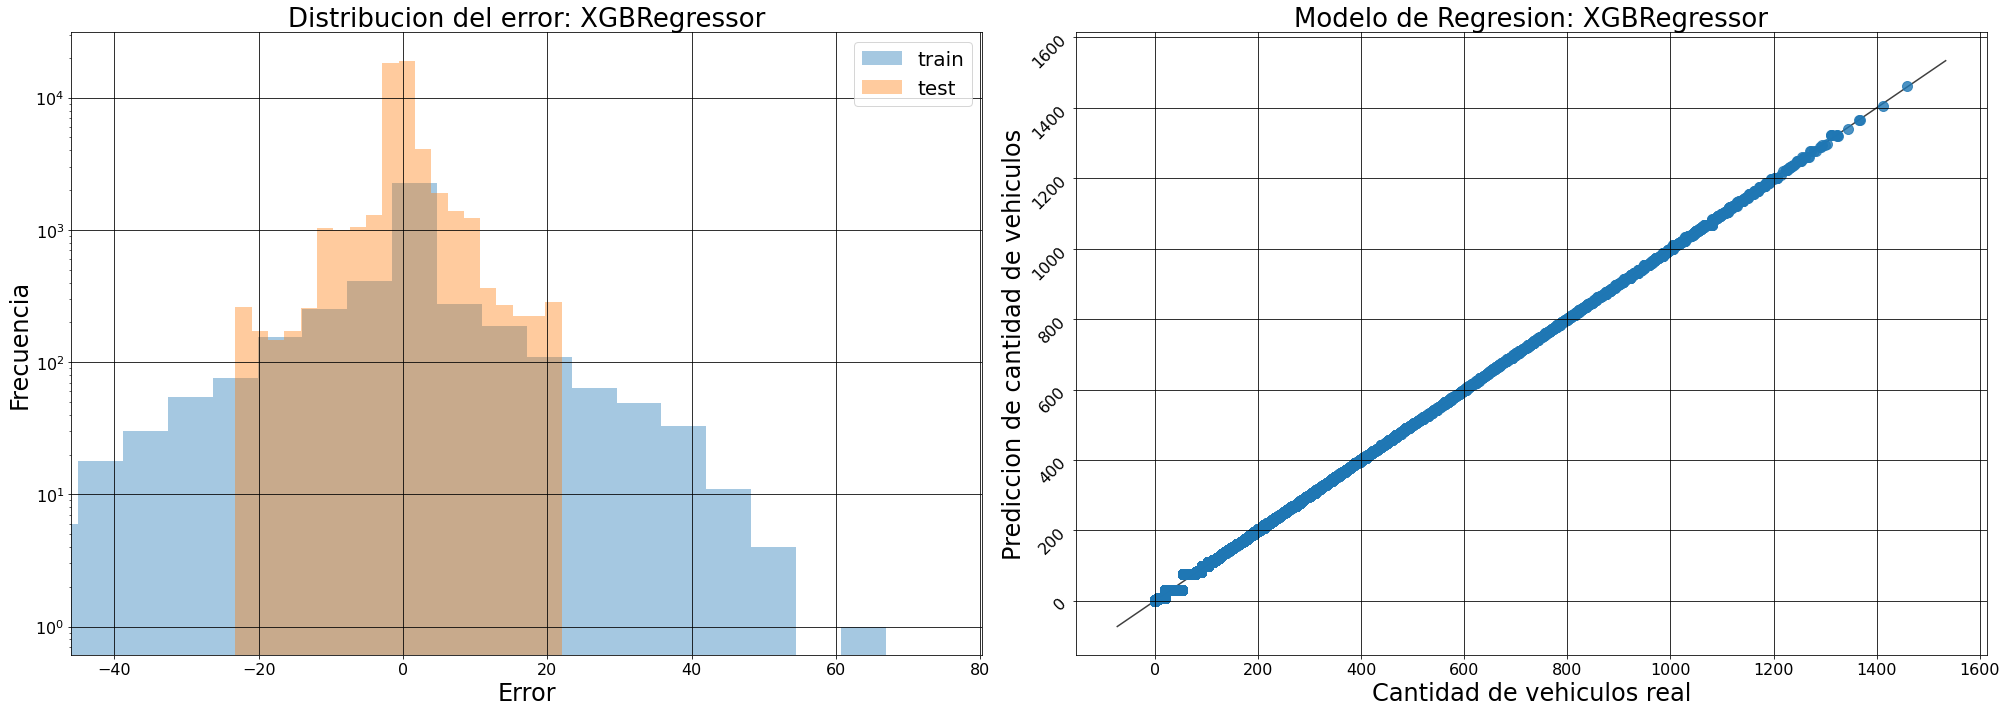

In [177]:
modelos = ["KNeighborsRegressor","DecisionTreeRegressor","XGBRegressor"]

for i, model in enumerate([model_1, model_2, model_3]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test_2020)
    
    
    print(f"Modelo: {modelos[i]}")

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test_2020, y_test_pred)
    print(f"Error Medio Absoluto en Train: {mae_train}")
    print(f"Error Medio Absoluto en Test: {mae_test}")
    
    
    plt.figure(figsize = (28,10))
    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = "train", hist = True, kde = False, norm_hist = False)
    sns.distplot(y_test_2020 - y_test_pred, bins = 20, label = "test",  hist = True, kde = False, norm_hist = False)
    plt.xlabel("Error", fontsize = 24)
    plt.xticks(fontsize = 16)
    plt.xlim((y_train - y_train_pred).append(y_test_2020 - y_test_pred).min() * 0.8,
             (y_train - y_train_pred).append(y_test_2020 - y_test_pred).max() * 1.2)
    plt.ylabel("Frecuencia", fontsize = 24)
    plt.yscale("log")
    plt.yticks(fontsize = 16)
    plt.legend(fontsize = 20)
    plt.title("Distribucion del error: " + modelos[i], fontsize = 26)
    plt.grid(c = "k")


    ax = plt.subplot(1,2,2)
    ax.scatter(x = y_test_2020, y = y_test_pred, s = 100, alpha = 0.8)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
    plt.xlabel("Cantidad de vehiculos real", fontsize = 24)
    plt.xticks(fontsize = 16)
    plt.ylabel("Prediccion de cantidad de vehiculos", fontsize = 24)
    plt.yticks(rotation = 45, fontsize = 16)
    plt.title("Modelo de Regresion: " + modelos[i], fontsize = 26)
    #plt.xlim(0, y_test_2020.max() * 1.1)
    #plt.ylim(0, y_test_pred.max() * 1.1)
    plt.grid(c = "k")
    
    plt.tight_layout()
    plt.show()

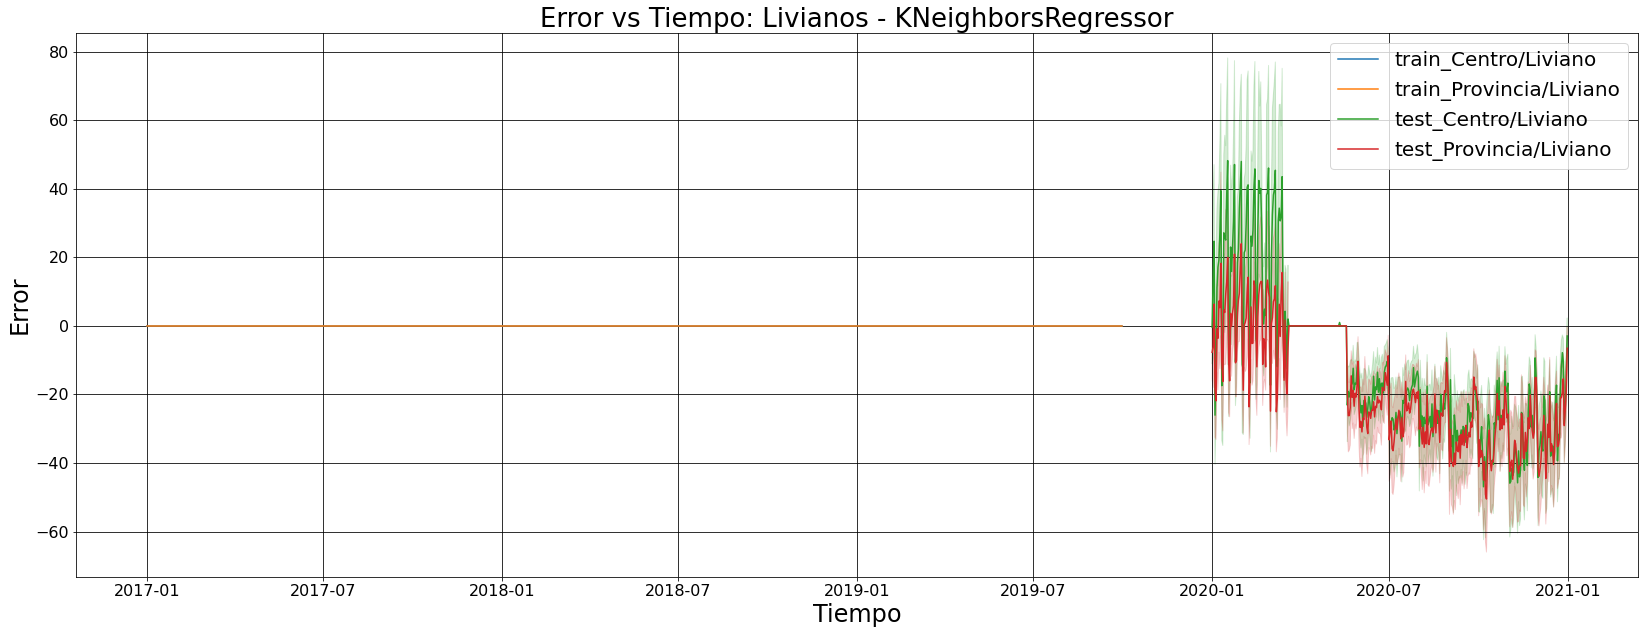

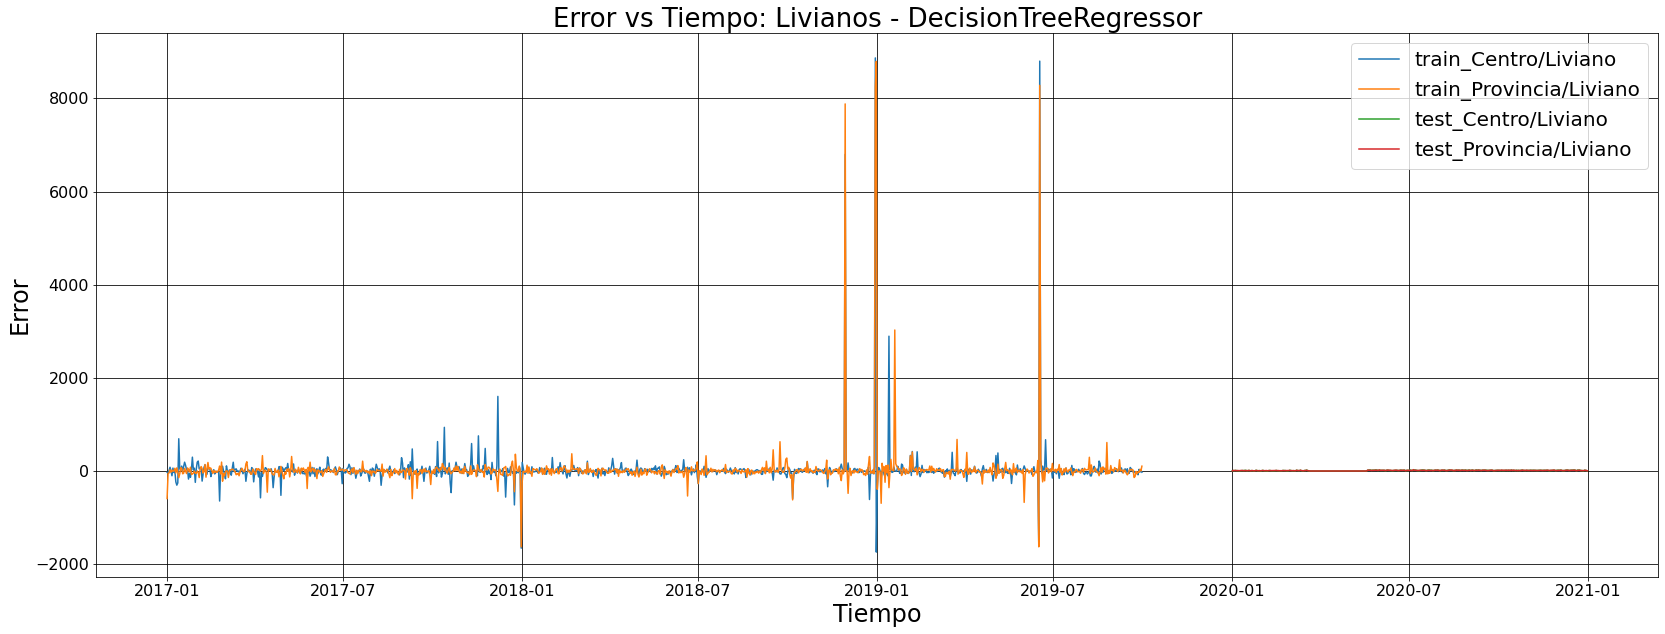

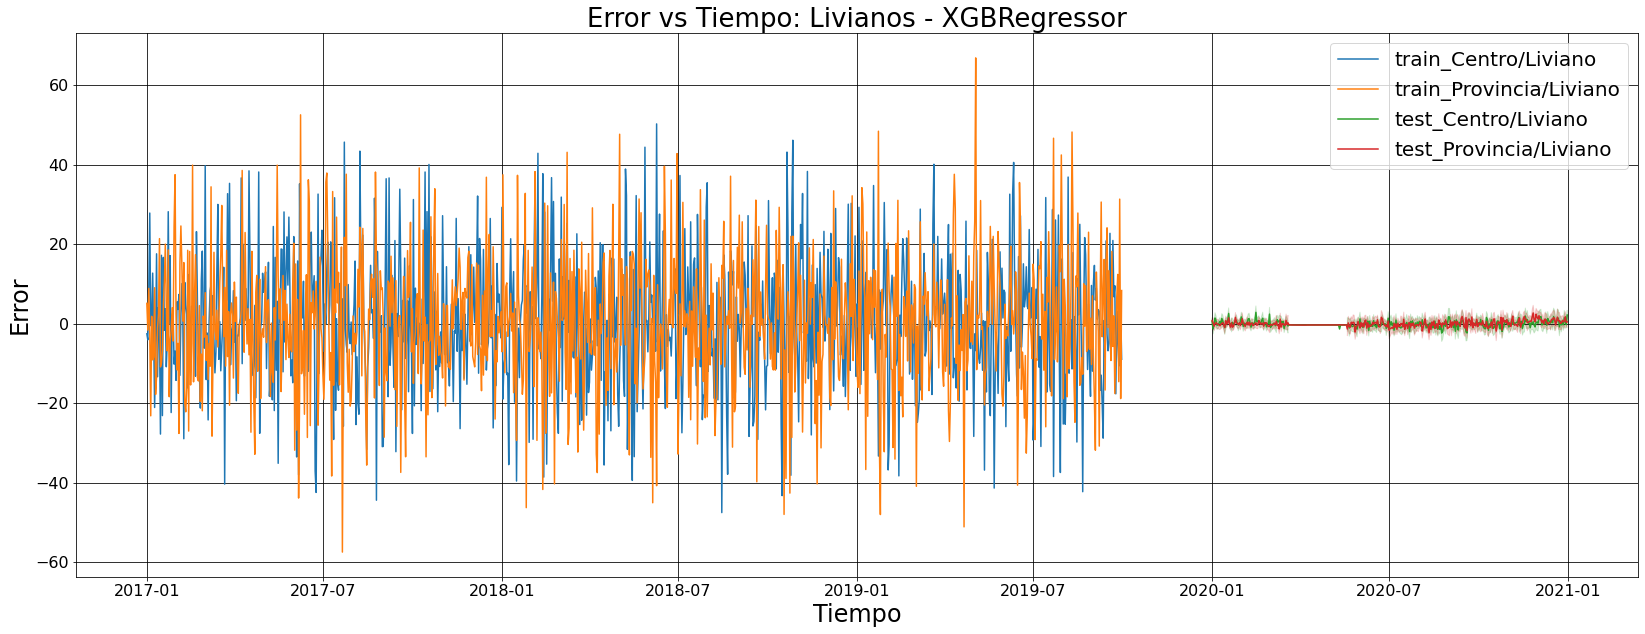

In [178]:
modelos = ["KNeighborsRegressor","DecisionTreeRegressor","XGBRegressor"]

for i, model in enumerate([model_1, model_2, model_3]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test_2020) 
    
    df_aux_train = pd.DataFrame(data = {"error" : (y_train - y_train_pred),
                                        "fecha" : X_train["fecha_numeros"].apply(dt.datetime.fromordinal),
                                        "Centro" : X_train["x0_Centro"],
                                        "Liviano" : X_train["x1_Liviano"],
                                        }
                               )

    df_aux_test = pd.DataFrame(data = {"error" : (y_test_2020 - y_test_pred),
                                       "fecha" : X_test_2020["fecha_numeros"].apply(dt.datetime.fromordinal),
                                       "Centro" : X_test_2020["x0_Centro"],
                                       "Liviano" : X_test_2020["x1_Liviano"],
                                      }
                              )

    plt.figure(figsize = (28,10))
    
    #TRAIN
    #Centro/Liviano
    sns.lineplot(data = df_aux_train[(df_aux_train["Centro"] == 1) & (df_aux_train["Liviano"] == 1)], 
                    x = "fecha",
                    y = "error",
                    label = "train_Centro/Liviano")
    
    #Provincia/Liviano
    sns.lineplot(data = df_aux_train[(df_aux_train["Centro"] == 0) & (df_aux_train["Liviano"] == 1)], 
                    x = "fecha",
                    y = "error",
                    label = "train_Provincia/Liviano")
    
    #TEST
    #Centro/Liviano
    sns.lineplot(data = df_aux_test[(df_aux_test["Centro"] == 1) & (df_aux_test["Liviano"] == 1)], 
                 x = "fecha",
                 y = "error",
                 label = "test_Centro/Liviano")
    
    #Provincia/Liviano
    sns.lineplot(data = df_aux_test[(df_aux_test["Centro"] == 0) & (df_aux_test["Liviano"] == 1)], 
                 x = "fecha",
                 y = "error",
                 label = "test_Provincia/Liviano")
    
    
    plt.title("Error vs Tiempo: Livianos - " + modelos[i], fontsize = 26)
        
    plt.xlabel("Tiempo", fontsize = 24)
    plt.xticks(fontsize = 16)
    plt.ylabel("Error", fontsize = 24)
    plt.yticks(fontsize = 16)
    plt.legend(fontsize = 20)
        
    plt.grid(c = "k")

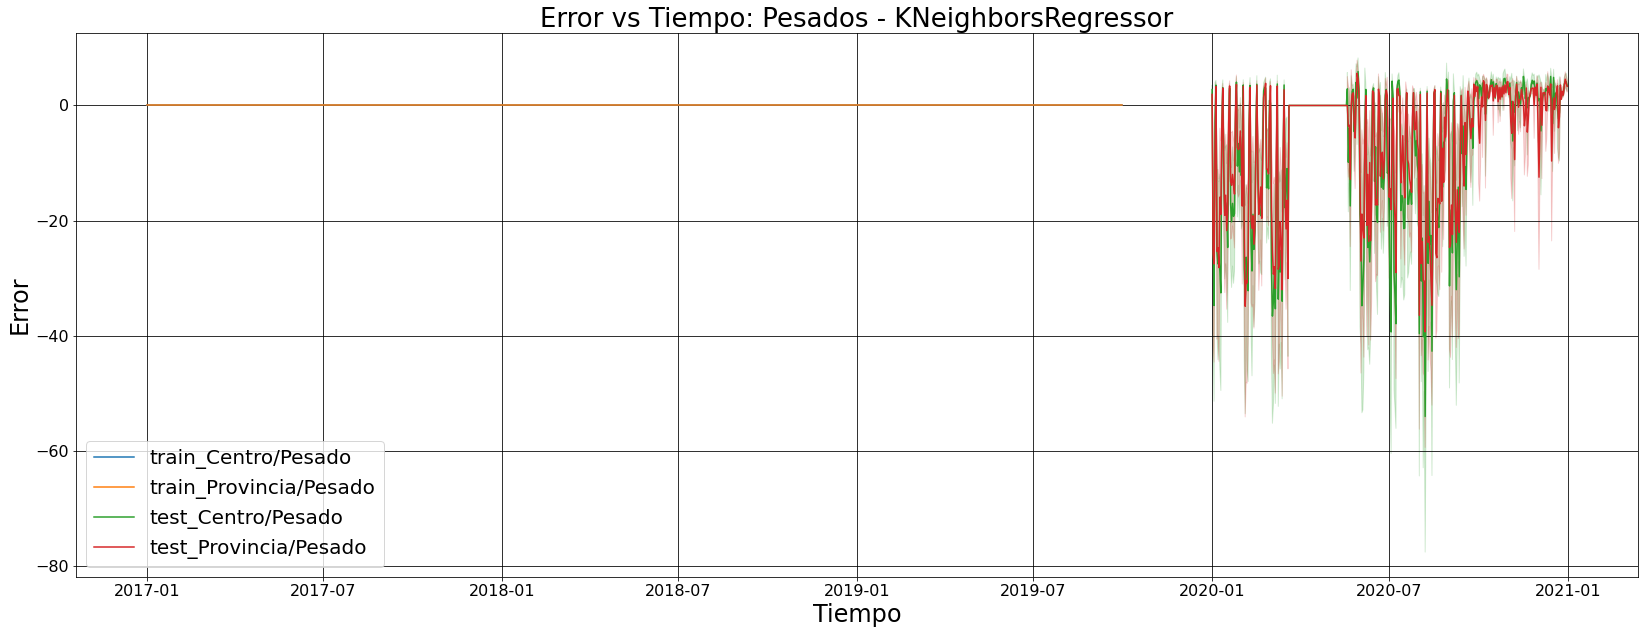

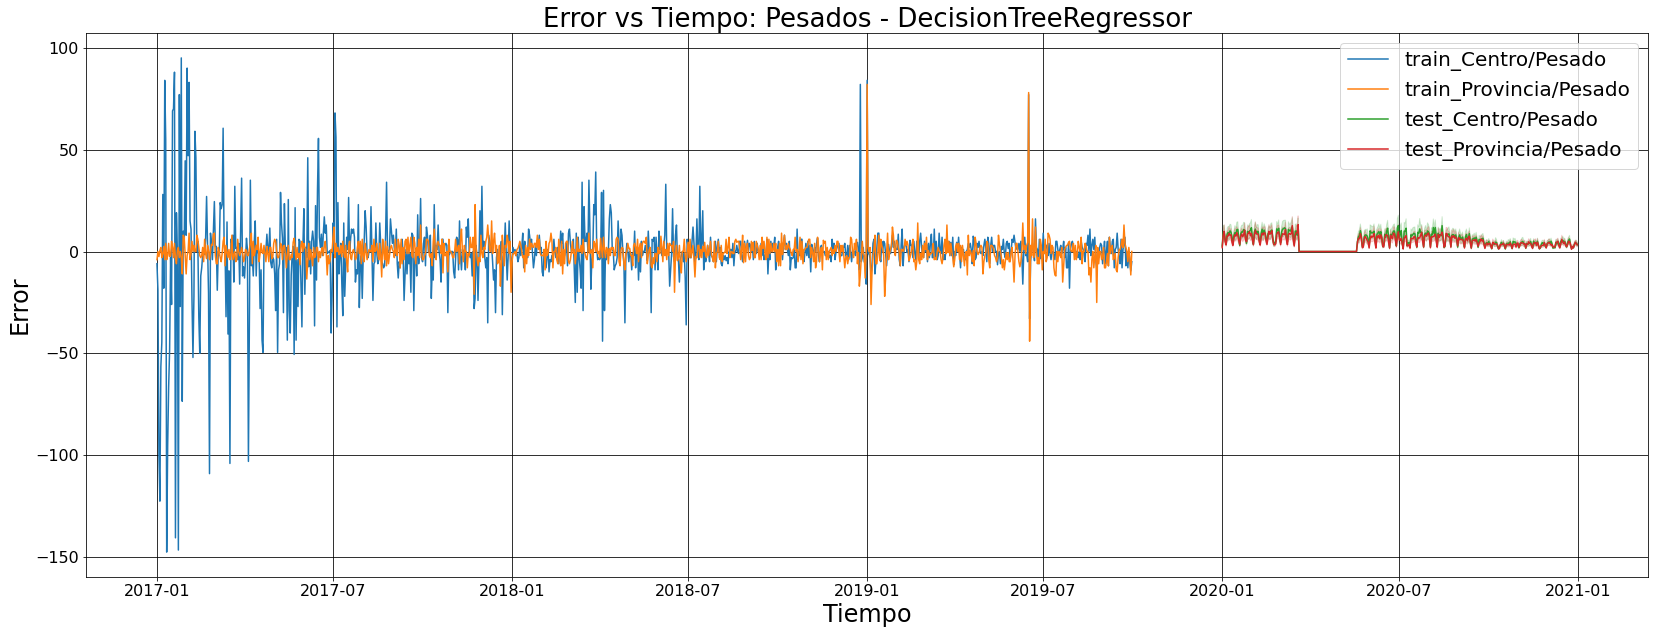

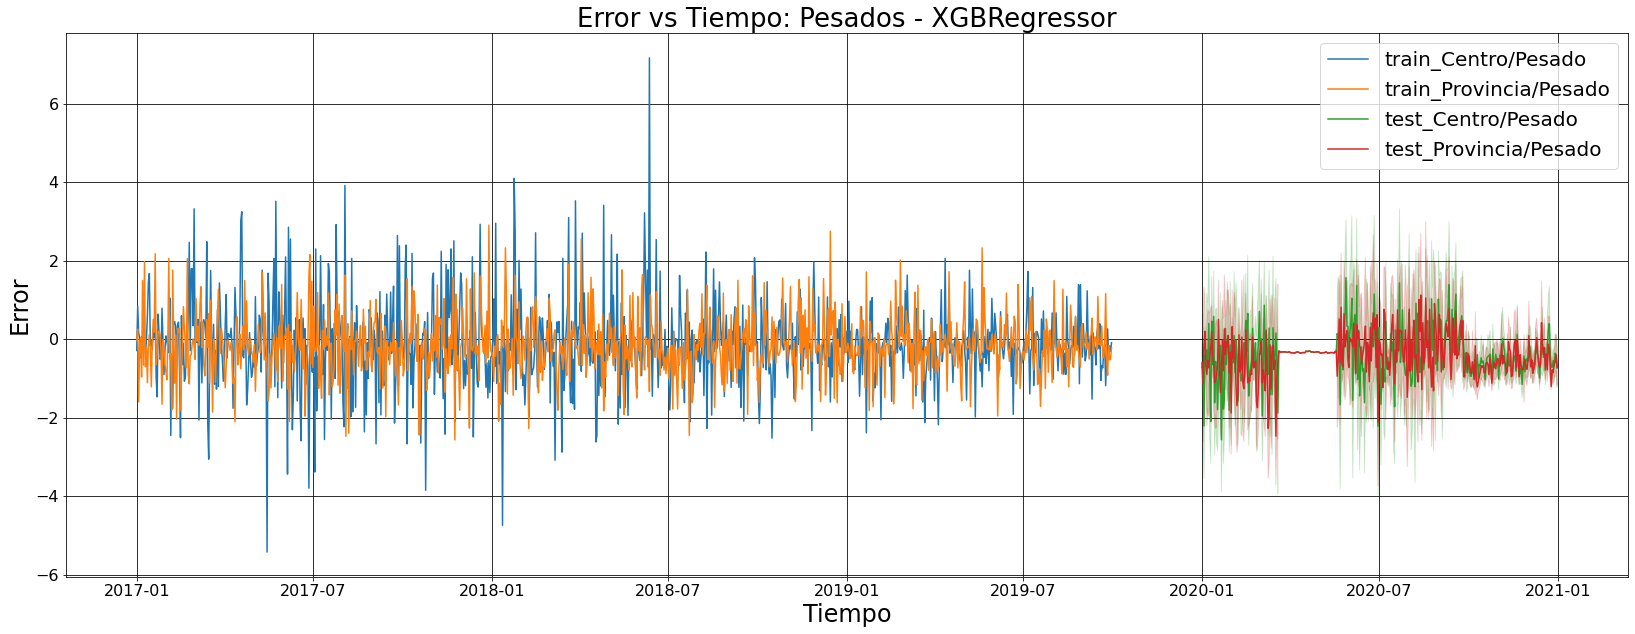

In [179]:
modelos = ["KNeighborsRegressor","DecisionTreeRegressor","XGBRegressor"]

for i, model in enumerate([model_1, model_2, model_3]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test_2020) 
    
    df_aux_train = pd.DataFrame(data = {"error" : (y_train - y_train_pred),
                                        "fecha" : X_train["fecha_numeros"].apply(dt.datetime.fromordinal),
                                        "Centro" : X_train["x0_Centro"],
                                        "Liviano" : X_train["x1_Liviano"],
                                        }
                               )

    df_aux_test = pd.DataFrame(data = {"error" : (y_test_2020 - y_test_pred),
                                       "fecha" : X_test_2020["fecha_numeros"].apply(dt.datetime.fromordinal),
                                       "Centro" : X_test_2020["x0_Centro"],
                                       "Liviano" : X_test_2020["x1_Liviano"],
                                      }
                              )

    plt.figure(figsize = (28,10))
    
    #TRAIN
    #Centro/Pesado
    sns.lineplot(data = df_aux_train[(df_aux_train["Centro"] == 1) & (df_aux_train["Liviano"] == 0)], 
                    x = "fecha",
                    y = "error",
                    label = "train_Centro/Pesado")
    
    #Provincia/Pesado
    sns.lineplot(data = df_aux_train[(df_aux_train["Centro"] == 0) & (df_aux_train["Liviano"] == 0)], 
                    x = "fecha",
                    y = "error",
                    label = "train_Provincia/Pesado")
    
    #TEST
    #Centro/Pesado
    sns.lineplot(data = df_aux_test[(df_aux_test["Centro"] == 1) & (df_aux_test["Liviano"] == 0)], 
                 x = "fecha",
                 y = "error",
                 label = "test_Centro/Pesado")
    
    #Provincia/Pesado
    sns.lineplot(data = df_aux_test[(df_aux_test["Centro"] == 0) & (df_aux_test["Liviano"] == 0)], 
                 x = "fecha",
                 y = "error",
                 label = "test_Provincia/Pesado")
    
    
    plt.title("Error vs Tiempo: Pesados - " + modelos[i], fontsize = 26)
        
    plt.xlabel("Tiempo", fontsize = 24)
    plt.xticks(fontsize = 16)
    plt.ylabel("Error", fontsize = 24)
    plt.yticks(fontsize = 16)
    plt.legend(fontsize = 20)
        
    plt.grid(c = "k")

### Conclusiones

El modelo de KNN continua en overfitting

Respecto a los otros dos modelos sucede algo particular y que era de esperarse conociendo el contexto de pandemia,

**El error de entrenamiento es mayor que el de prueba**

Incurrimos en un error en la metodología del entrenamiento del modelo: cuando partimos los datos en entrenamiento y prueba. Esto nos conduce a que los modelos resulten confusos y puedan llevarnos a concluir en forma erronea sobre los resultados obtenidos.
Sabemos que los modelos pueden clasificarse en:

* Overfitting (sobreajuste): muy bajo error en train, alto en test
* Underfitting (): alto error tanto en train como en test
* Good fit (un buen ajuste): error train bajo, error en test relativamente mas alto que train.
* Unknown fit (ajuste desconocido): error en test bajo, error en train "alto"

Si la esencia del ML es predecir lo desconocido, lo predicho en test no hace sentido que tenga un error en promedio menor que aquel sobre el que ha "aprendido". Entonces, los datos de train y test deben ser diferentes de alguna manera. Esta diferencia radica principalmente a que la pandemia cambió totalmente el flujo vehicular existente en 2020.

Fuente: https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error

Otra explicación en situaciones similares: Existe un sesgo de muestreo en la prueba. Comparto este ejemplo obtenido de un foro donde surge esta inquietud: https://discuss.analyticsvidhya.com/t/what-are-the-reason-when-test-error-is-less-than-train-error/8155

## 7 - Agregado de años 2015 y 2016

In [180]:
data_2015 = pd.read_csv('flujo-vehicular-2015.csv', sep =',')
data_2016 = pd.read_csv('flujo-vehicular-2016.csv', sep =',')

In [181]:
data_2015.head()

periodo       fecha  hora     dia estacion tipo_vehiculo  forma_pago  \
0     2015  2015-01-01     0  Jueves  Alberdi       Liviano  NO COBRADO   
1     2015  2015-01-01     0  Jueves  Alberdi       Liviano    EFECTIVO   
2     2015  2015-01-01     0  Jueves  Alberdi       Liviano      EXENTO   
3     2015  2015-01-01     0  Jueves  Alberdi       Liviano    EFECTIVO   
4     2015  2015-01-01     0  Jueves  Alberdi       Liviano      AUPASS   

   cantidad_pasos  
0              15  
1               1  
2               1  
3              68  
4              18

In [182]:
data_2016.head()

periodo       fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2016  2016-01-01            0         1  Viernes  Alberdi  Centro   
1     2016  2016-01-01            0         1  Viernes  Alberdi  Centro   
2     2016  2016-01-01            1         2  Viernes  Alberdi  Centro   
3     2016  2016-01-01            1         2  Viernes  Alberdi  Centro   
4     2016  2016-01-01            1         2  Viernes  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              32  
1       Liviano      AUPASS               9  
2       Liviano  NO COBRADO               1  
3       Liviano    EFECTIVO               4  
4       Liviano      EXENTO               3

### Incoveniente

Para el dataset de 2015 no contamos con un registro sobre el sentido de los vehiculos (Provincia o Centro).

Debido al enfoque que fue adoptado a lo largo del proyecto (complejizando y robusteciendo los modelos presentados), no puedo considerar para este punto los datos correspondientes al año 2015.

In [183]:
# Verifico valores nulos

data_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379443 entries, 0 to 1379442
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1379443 non-null  int64 
 1   fecha           1379443 non-null  object
 2   hora_inicio     1379443 non-null  int64 
 3   hora_fin        1379443 non-null  int64 
 4   dia             1379443 non-null  object
 5   estacion        1379443 non-null  object
 6   sentido         1379443 non-null  object
 7   tipo_vehiculo   1379443 non-null  object
 8   forma_pago      1379443 non-null  object
 9   cantidad_pasos  1379443 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.2+ MB


In [184]:
# Verifico que no haya errores correspondientes al nombre de la estacion

data_2016.estacion.unique()

array(['Alberdi', 'Avellaneda', 'Dellepiane Centro', 'Dellepiane Liniers',
       'Illia', 'Retiro', 'Salguero', 'Sarmiento'], dtype=object)

In [185]:
# Verifico que no haya otros errores correspondientes a la forma de pago

data_2016.forma_pago.unique()

array(['NO COBRADO', 'AUPASS', 'EFECTIVO', 'EXENTO',
       'TARJETA DISCAPACIDAD', 'INFRACCION', 'MONEDERO'], dtype=object)

In [186]:
# Verifico que no haya errores en el sentido

data_2016.sentido.unique()

array(['Centro', 'Provincia'], dtype=object)

In [187]:
data_2016["fecha"] = pd.to_datetime(data_2016["fecha"])

In [188]:
data_2016 = data_2016[(data_2016["forma_pago"] == "EFECTIVO") & (data_2016["estacion"] == "Illia")]

In [189]:
# Construccion del calendario completo
calendario_2016 = pd.Series(pd.date_range(start = "2016-01-01",
                                          end = "2016-12-31", 
                                          freq = "D"))

In [190]:
data_2016 = data_2016.groupby(by = ["fecha","sentido","tipo_vehiculo"], as_index = False)["cantidad_pasos"].sum()

In [191]:
calendario_2016.shape[0] - len(data_2016.fecha.unique())

0

In [192]:
set(calendario_2016) - set(data_2016.fecha)

set()

La diferencia de conjuntos entre el calendario completo generado y el dataset de 2016 nos devuelve el conjunto vacio. En consecuencia, el dataset del 2016 tiene todas las fechas.

### Aplico todas las transformaciones ya realizadas previamente

In [193]:
# Label Encoding para el calendario

data_2016["day_num"] = data_2016.fecha.dt.day # Dia
data_2016["month_num"] = data_2016.fecha.dt.month # Mes
data_2016["year_num"] = data_2016.fecha.dt.year # Año

# Construyo 2 nuevas columnas que contengan los dias de la semana numerados
# 0: Lunes, 1: Martes, ... , 6: Domingo

data_2016["dia_sem"] = data_2016.fecha.dt.weekday
data_2016["fin_sem"] = data_2016.fecha.dt.weekday

# Armo el one hot encoding con la siguiente regla:

data_2016["dia_sem"] = data_2016["dia_sem"].apply(lambda x: 1 if x <= 4 else 0) # Implica que es un dia de semana, ya que 4 = Viernes
data_2016["fin_sem"] = data_2016["fin_sem"].apply(lambda x: 1 if x > 4 else 0) # Implica que es un fin de semana

In [194]:
# Armo one hot encoding para el sentido y el tipo de vehiculo

cat_features = ["sentido","tipo_vehiculo"]
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False).fit(data_2016[cat_features])
label_names = list(ohe.get_feature_names())
label_names

['x0_Centro', 'x0_Provincia', 'x1_Liviano', 'x1_Pesado']

In [195]:
ohe_df = pd.DataFrame(ohe.transform(data_2016[cat_features]), columns = label_names)
ohe_df = ohe_df.set_index(keys = data_2016.index)

In [196]:
data_2016 = data_2016.join(ohe_df, on = data_2016.index)

data_2016[label_names] = data_2016[label_names].astype(dtype = "int")

In [197]:
data_2016.drop(labels = cat_features, 
               axis = 1,
               inplace = True)

In [198]:
data_2016["fecha_numeros"] = data_2016.fecha.map(dt.datetime.toordinal)

In [199]:
df_16_19 = data_2016[["fecha",
                      "cantidad_pasos",
                      "day_num", 
                      "month_num",
                      "year_num",
                      "dia_sem", 
                      "fin_sem",
                      "x0_Centro",
                      "x0_Provincia",
                      "x1_Liviano",
                      "x1_Pesado",
                      "fecha_numeros"]].append(df)



In [200]:
df_16_19.head().append(df_16_19.tail())

fecha  cantidad_pasos  day_num  month_num  year_num  dia_sem  \
0    2016-01-01           12985        1          1      2016        1   
1    2016-01-01             297        1          1      2016        1   
2    2016-01-01           12180        1          1      2016        1   
3    2016-01-01             140        1          1      2016        1   
4    2016-01-02           18169        2          1      2016        0   
4373 2019-12-30             301       30         12      2019        1   
4374 2019-12-31           10866       31         12      2019        1   
4375 2019-12-31             109       31         12      2019        1   
4376 2019-12-31           10355       31         12      2019        1   
4377 2019-12-31             117       31         12      2019        1   

      fin_sem  x0_Centro  x0_Provincia  x1_Liviano  x1_Pesado  fecha_numeros  
0           0          1             0           1          0         735964  
1           0          1             0           0          1         735964  
2           0          0             1           1          0         735964  
3           0          0             1           0          1         735964  
4           1          1             0           1          0         735965  
4373        0          0             1           0          1         737423  
4374        0          1             0           1          0         737424  
4375        0          1             0           0          1         737424  
4376        0          0             1           1          0         737424  
4377        0          0             1           0          1         737424

### Particion ordenada de los datos de entrenamiento y prueba

In [201]:
X_train = df_16_19[df_16_19["fecha"] < "2019-10-01"]
X_test = df_16_19[df_16_19["fecha"] >= "2019-10-01"]
y_train = df_16_19[df_16_19["fecha"] < "2019-10-01"]["cantidad_pasos"]
y_test = df_16_19[df_16_19["fecha"] >= "2019-10-01"]["cantidad_pasos"]

In [202]:
X_train.drop(labels = "fecha", axis = 1, inplace = True)
X_test.drop(labels = "fecha", axis = 1, inplace = True)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Hipertunning

### Hipertunning de XGBRegressor

In [203]:
parametros = {"n_estimators": [50, 100, 150],
              "subsample": [0.5, 0.7, 1.0],
              "min_child_weight" : [1, 3, 5, 7],
              "max_depth": [5,7,9],
              "max_features" : [None, "sqrt"]}

xgbr_cv = GridSearchCV(estimator = model_dict["xgbr"], 
                       param_grid = parametros, 
                       scoring='neg_mean_absolute_error',
                       cv = 5,
                       n_jobs=-1)

xgbr_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.08, max_delta_step=None,
                                    max_depth=5, max_features='sqrt',
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estim...
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=123, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=0.7, tree_method=None,
      

In [204]:
print(f"Los mejores hiperparametros son: \n")
for key, value in xgbr_cv.best_params_.items():
    print(f"{key}: {value}")
print(f"El error absoluto medio más bajo es: {np.round(-xgbr_cv.best_score_, 2)}")

Los mejores hiperparametros son: 

max_depth: 9
max_features: None
min_child_weight: 1
n_estimators: 150
subsample: 1.0
El error absoluto medio más bajo es: 13.31


In [205]:
model_3 = xgbr_cv.best_estimator_

### Evaluacion del modelo

### XGBRegressor

In [206]:
print(f"El RMSE en Entrenamiento: {np.sqrt(mean_squared_error(y_train, model_3.predict(X_train)))}")

print(f"El RMSE en Prueba: {np.sqrt(mean_squared_error(y_test, model_3.predict(X_test)))}" + "\n")

print(f"El MAE en Entrenamiento: {mean_absolute_error(y_train, model_3.predict(X_train))}")

print(f"El MAE en Prueba: {mean_absolute_error(y_test, model_3.predict(X_test))}")

El RMSE en Entrenamiento: 12.189859618519694
El RMSE en Prueba: 36.869717987178404

El MAE en Entrenamiento: 6.852731972116165
El MAE en Prueba: 12.985011691632478


### Distribucion de los errores

Modelo: XGBRegressor
Error Medio Absoluto en Train: 6.852731972116165
Error Medio Absoluto en Test: 12.985011691632478


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


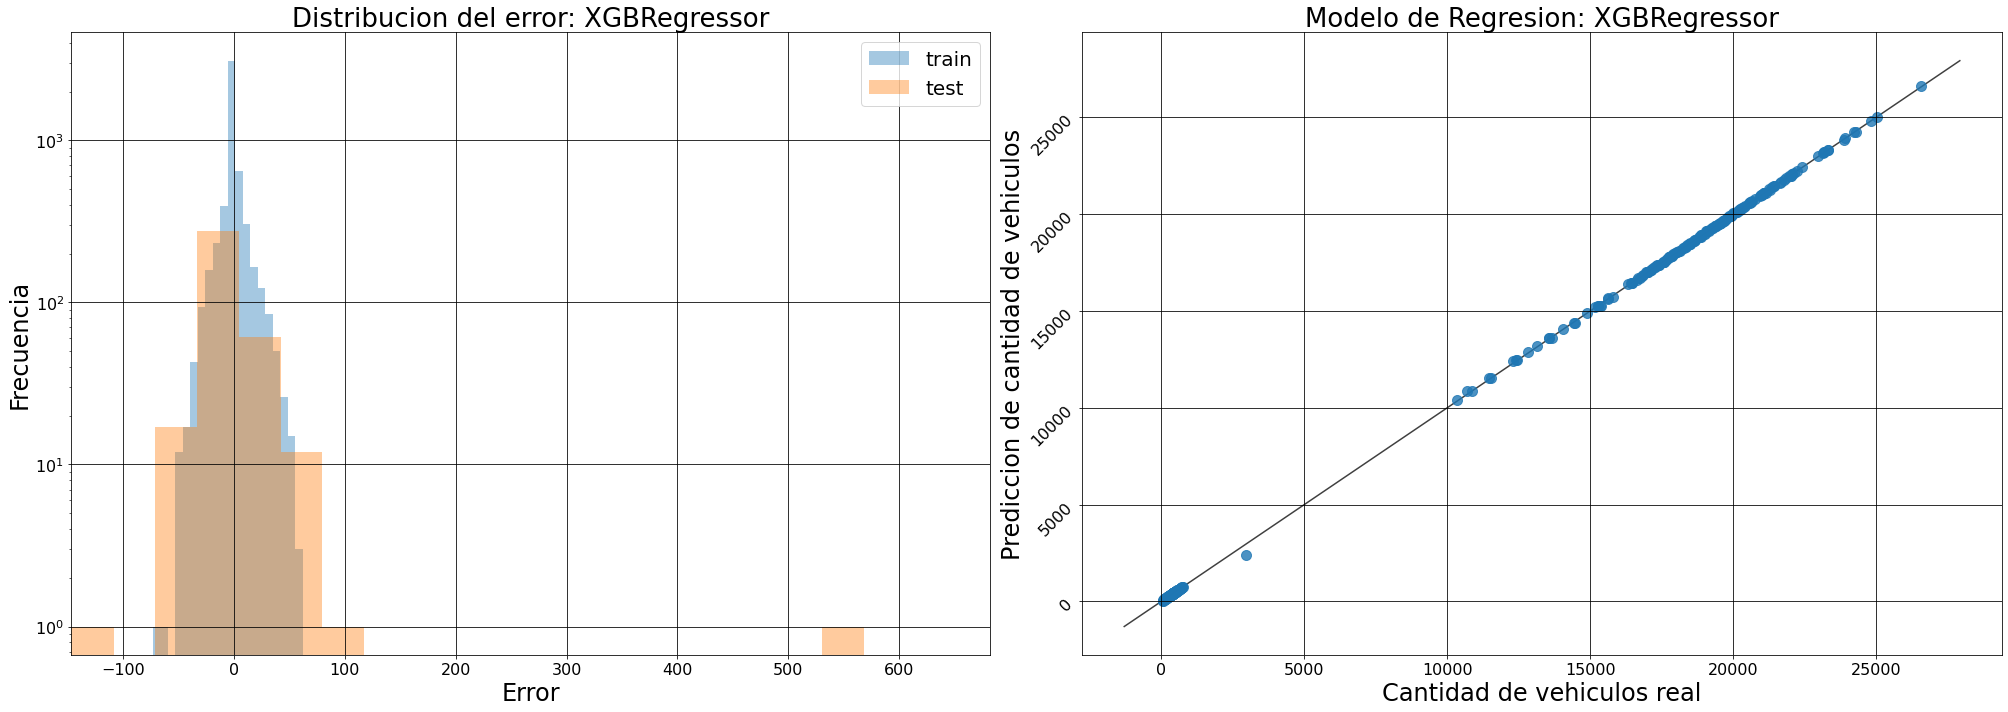

In [207]:
modelos = ["XGBRegressor"]

for i, model in enumerate([model_3]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    
    print(f"Modelo: {modelos[i]}")

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    print(f"Error Medio Absoluto en Train: {mae_train}")
    print(f"Error Medio Absoluto en Test: {mae_test}")
    
    
    plt.figure(figsize = (28,10))
    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = "train", hist = True, kde = False, norm_hist = False)
    sns.distplot(y_test - y_test_pred, bins = 20, label = "test",  hist = True, kde = False, norm_hist = False)
    plt.xlabel("Error", fontsize = 24)
    plt.xticks(fontsize = 16)
    plt.xlim((y_train - y_train_pred).append(y_test - y_test_pred).min() * 0.8,
             (y_train - y_train_pred).append(y_test - y_test_pred).max() * 1.2)
    plt.ylabel("Frecuencia", fontsize = 24)
    plt.yticks(fontsize = 16)
    plt.yscale("log")
    plt.legend(fontsize = 20)
    plt.title("Distribucion del error: " + modelos[i], fontsize = 26)
    plt.grid(c = "k")


    ax = plt.subplot(1,2,2)
    ax.scatter(x = y_test, y = y_test_pred, s = 100, alpha = 0.8)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
    plt.xlabel("Cantidad de vehiculos real", fontsize = 24)
    plt.xticks(fontsize = 16)
    plt.ylabel("Prediccion de cantidad de vehiculos", fontsize = 24)
    plt.yticks(rotation = 45, fontsize = 16)
    plt.title("Modelo de Regresion: " + modelos[i], fontsize = 26)
    #plt.xlim(0, y_test.max() * 1.1)
    #plt.ylim(0, y_test_pred.max() * 1.1)
    plt.grid(c = "k")
    
    plt.tight_layout()
    plt.show()

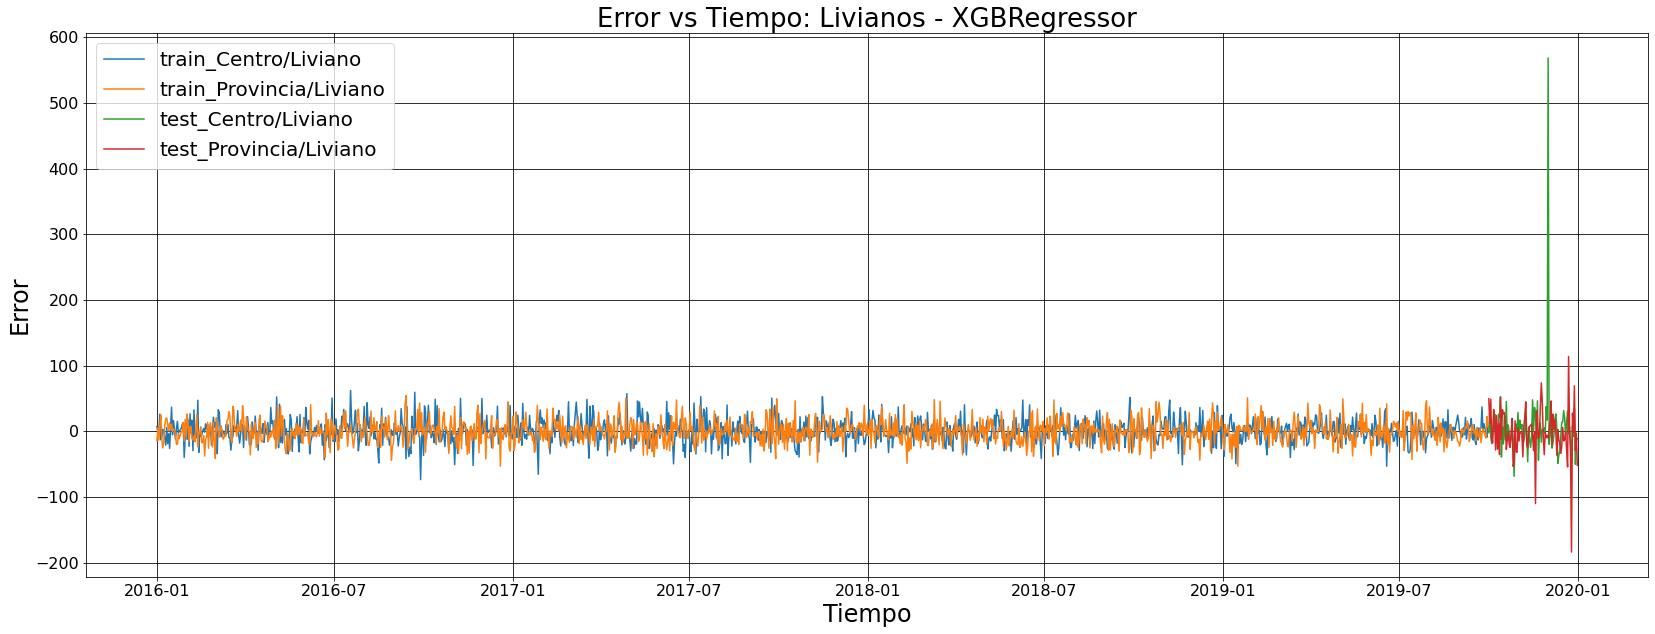

In [208]:
modelos = ["XGBRegressor"]

for i, model in enumerate([model_3]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test) 
    
    df_aux_train = pd.DataFrame(data = {"error" : (y_train - y_train_pred),
                                        "fecha" : X_train["fecha_numeros"].apply(dt.datetime.fromordinal),
                                        "Centro" : X_train["x0_Centro"],
                                        "Liviano" : X_train["x1_Liviano"],
                                        }
                               )

    df_aux_test = pd.DataFrame(data = {"error" : (y_test - y_test_pred),
                                       "fecha" : X_test["fecha_numeros"].apply(dt.datetime.fromordinal),
                                       "Centro" : X_test["x0_Centro"],
                                       "Liviano" : X_test["x1_Liviano"],
                                      }
                              )

    plt.figure(figsize = (28,10))
    
    #TRAIN
    #Centro/Liviano
    sns.lineplot(data = df_aux_train[(df_aux_train["Centro"] == 1) & (df_aux_train["Liviano"] == 1)], 
                    x = "fecha",
                    y = "error",
                    label = "train_Centro/Liviano")
    
    #Provincia/Liviano
    sns.lineplot(data = df_aux_train[(df_aux_train["Centro"] == 0) & (df_aux_train["Liviano"] == 1)], 
                    x = "fecha",
                    y = "error",
                    label = "train_Provincia/Liviano")
    
    #TEST
    #Centro/Liviano
    sns.lineplot(data = df_aux_test[(df_aux_test["Centro"] == 1) & (df_aux_test["Liviano"] == 1)], 
                 x = "fecha",
                 y = "error",
                 label = "test_Centro/Liviano")
    
    #Provincia/Liviano
    sns.lineplot(data = df_aux_test[(df_aux_test["Centro"] == 0) & (df_aux_test["Liviano"] == 1)], 
                 x = "fecha",
                 y = "error",
                 label = "test_Provincia/Liviano")
    
    
    plt.title("Error vs Tiempo: Livianos - " + modelos[i], fontsize = 26)
        
    plt.xlabel("Tiempo", fontsize = 24)
    plt.xticks(fontsize = 16)
    plt.ylabel("Error", fontsize = 24)
    plt.yticks(fontsize = 16)
    plt.legend(fontsize = 20)
        
    plt.grid(c = "k")

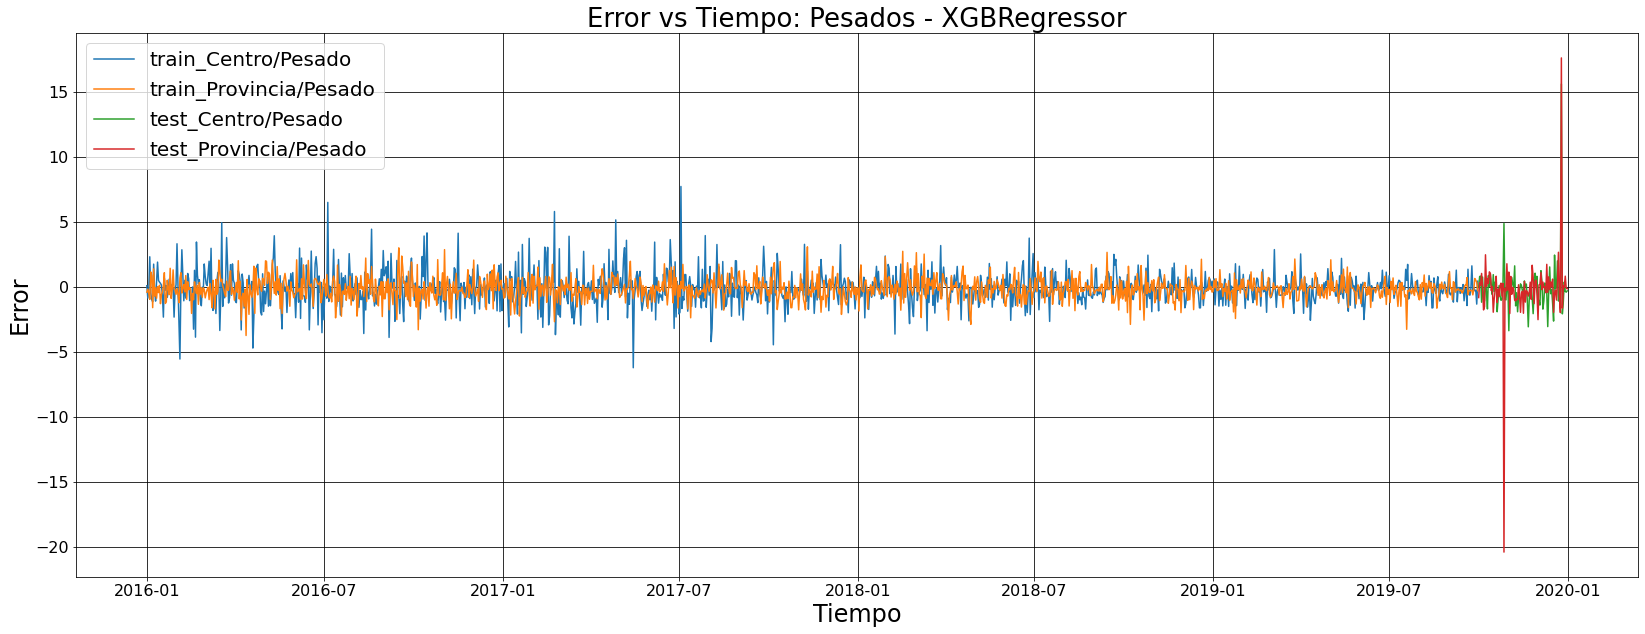

In [209]:
modelos = ["XGBRegressor"]

for i, model in enumerate([model_3]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test) 
    
    df_aux_train = pd.DataFrame(data = {"error" : (y_train - y_train_pred),
                                        "fecha" : X_train["fecha_numeros"].apply(dt.datetime.fromordinal),
                                        "Centro" : X_train["x0_Centro"],
                                        "Liviano" : X_train["x1_Liviano"],
                                        }
                               )

    df_aux_test = pd.DataFrame(data = {"error" : (y_test - y_test_pred),
                                       "fecha" : X_test["fecha_numeros"].apply(dt.datetime.fromordinal),
                                       "Centro" : X_test["x0_Centro"],
                                       "Liviano" : X_test["x1_Liviano"],
                                      }
                              )

    plt.figure(figsize = (28,10))
    
    #TRAIN
    #Centro/Pesado
    sns.lineplot(data = df_aux_train[(df_aux_train["Centro"] == 1) & (df_aux_train["Liviano"] == 0)], 
                    x = "fecha",
                    y = "error",
                    label = "train_Centro/Pesado")
    
    #Provincia/Pesado
    sns.lineplot(data = df_aux_train[(df_aux_train["Centro"] == 0) & (df_aux_train["Liviano"] == 0)], 
                    x = "fecha",
                    y = "error",
                    label = "train_Provincia/Pesado")
    
    #TEST
    #Centro/Pesado
    sns.lineplot(data = df_aux_test[(df_aux_test["Centro"] == 1) & (df_aux_test["Liviano"] == 0)], 
                 x = "fecha",
                 y = "error",
                 label = "test_Centro/Pesado")
    
    #Provincia/Pesado
    sns.lineplot(data = df_aux_test[(df_aux_test["Centro"] == 0) & (df_aux_test["Liviano"] == 0)], 
                 x = "fecha",
                 y = "error",
                 label = "test_Provincia/Pesado")
    
    
    plt.title("Error vs Tiempo: Pesados - " + modelos[i], fontsize = 26)
        
    plt.xlabel("Tiempo", fontsize = 24)
    plt.xticks(fontsize = 16)
    plt.ylabel("Error", fontsize = 24)
    plt.yticks(fontsize = 16)
    plt.legend(fontsize = 20)
        
    plt.grid(c = "k")

### Conclusion: Mejora levemente el resultado

## Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

1) ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?

Aplicando estrategias de transformacion encoding (las cuales fueron explicadas a lo largo del notebook).

Respecto a las predicciones, al haberse ya implementado desde el inicio estas transformaciones para el modelado, podriamos simplificar el modelo ignorando totalmente estos atributos y re-haciendo los pasos subsiguientes (separar en train y test, probar modelos con sus parametros por defecto,hipertunning y ver finalmente su desempeño).

Nota: utilizo el dataset inicial con las fechas de 2017 a 2019 para volver a predecir el ultimo trimestre del 2019.

### Modelo simplificado

In [210]:
# Para regresar a un dataset mas simple, solo necesito agrupar por fechas, 
# sumarizando la cantidad de vehiculos

df_simple = df.groupby(by = ["fecha", "fecha_numeros"], as_index = False)["cantidad_pasos"].sum()

df_simple.head()

fecha  fecha_numeros  cantidad_pasos
0 2017-01-01         736330           31183
1 2017-01-02         736331           51568
2 2017-01-03         736332           51093
3 2017-01-04         736333           53332
4 2017-01-05         736334           56486

In [211]:
X_train = df_simple[df_simple["fecha"] < "2019-10-01"]
X_test = df_simple[df_simple["fecha"] >= "2019-10-01"]
y_train = df_simple[df_simple["fecha"] < "2019-10-01"]["cantidad_pasos"]
y_test = df_simple[df_simple["fecha"] >= "2019-10-01"]["cantidad_pasos"]

In [212]:
X_train.drop(labels = "fecha", axis = 1, inplace = True)
X_test.drop(labels = "fecha", axis = 1, inplace = True)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Modelos

In [213]:
# Guardo modelos en un diccionario
model_dict = {}

model_dict["knn"] = KNeighborsRegressor(n_neighbors = 5)

model_dict["tree"] = DecisionTreeRegressor(max_depth = 5, random_state = 123)

model_dict["random_forest"] = RandomForestRegressor(n_estimators = 50, max_depth = 5, max_features = "sqrt", random_state = 123, n_jobs = -1)

model_dict["gbr"] = GradientBoostingRegressor(n_estimators=50, max_depth=5, learning_rate=0.08, subsample=0.7, max_features = "sqrt", random_state = 123)

model_dict["xgbr"] = XGBRegressor(n_estimators=50, max_depth=5, learning_rate=0.08, subsample=0.7, max_features = "sqrt", random_state = 123, n_jobs = -1)

# Guardo keys en una lista
modelos = list(model_dict.keys()) 

### Cross Validation

In [214]:
rmse = {}
mae = {}

for modelo in modelos:
    
    rmse[modelo] = np.sqrt(-cross_val_score(estimator = model_dict[modelo], X = X_train, y = y_train,
                                           scoring = "neg_mean_squared_error", cv = 5, n_jobs = -1))
    
    mae[modelo] = -cross_val_score(estimator = model_dict[modelo], X = X_train, y = y_train,
                                  scoring = "neg_mean_absolute_error", cv = 5, n_jobs = -1)
    
rmse = pd.DataFrame.from_dict(rmse)
mae = pd.DataFrame.from_dict(mae)

#### Justificar metrica elegida

rmse
mae


#### Resultados CV

In [215]:
resultados = pd.concat(objs=[pd.DataFrame(rmse.mean(), columns=["rmse"]),
                             pd.DataFrame(rmse.std(), columns=["rmse_std"]),
                             pd.DataFrame(mae.mean(), columns=["mae"]),
                             pd.DataFrame(mae.std(), columns=["mae_std"])], axis=1)

resultados

rmse    rmse_std          mae     mae_std
knn             392.758646  499.344257   118.899420   87.209556
tree            510.104726  160.998210   364.175531   67.395844
random_forest  2108.083645  432.981333  1180.363062  195.212414
gbr            1233.231619  235.404401   584.745922  187.003710
xgbr            838.775120  290.798966   753.831273  169.234655

Utilizando los parametros por defecto los modelos de vecinos mas cercanos, arboles de decision y xtreme gradient boosting fueron los de menor error.

### Hipertunning de KNeighborsRegressor

In [216]:
parametros = {"n_neighbors" : range(3,12,2),
              "weights" : ["uniform","distance"],
              "leaf_size" : range(15, 60, 15),
              "p" : [1, 2]}

knn_cv = GridSearchCV(estimator = model_dict["knn"], param_grid = parametros, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

knn_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'leaf_size': range(15, 60, 15),
                         'n_neighbors': range(3, 12, 2), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error')

In [217]:
print(f"Los mejores hiperparametros son: \n")

for key, value in knn_cv.best_params_.items():
    print(f"{key}: {value}")
    
print(f"El error absoluto medio más bajo es: {np.round(-knn_cv.best_score_, 2)}")

Los mejores hiperparametros son: 

leaf_size: 15
n_neighbors: 3
p: 1
weights: distance
El error absoluto medio más bajo es: 74.03


### Hipertunning de DecisionTreeRegressor

In [218]:
parametros = {"criterion" : ["mse","mae","poisson"],
              "max_depth" : range(3,12,2), 
              "min_samples_split" : range(10,60,10),
              "min_samples_leaf" : range(10,60,10)}



tree_cv = GridSearchCV(estimator = model_dict["tree"], 
                       param_grid = parametros, 
                       scoring='neg_mean_absolute_error',
                       cv = 5,
                       n_jobs=-1)

tree_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(max_depth=5, random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae', 'poisson'],
                         'max_depth': range(3, 12, 2),
                         'min_samples_leaf': range(10, 60, 10),
                         'min_samples_split': range(10, 60, 10)},
             scoring='neg_mean_absolute_error')

In [219]:
print(f"Los mejores hiperparametros son: \n")

for key, value in tree_cv.best_params_.items():
    print(f"{key}: {value}")
    
print(f"El error absoluto medio más bajo es: {np.round(-tree_cv.best_score_, 2)}")

Los mejores hiperparametros son: 

criterion: mae
max_depth: 9
min_samples_leaf: 10
min_samples_split: 10
El error absoluto medio más bajo es: 375.42


### Hipertunning de XGBRegressor

In [220]:
parametros = {"n_estimators": [50, 100, 150],
              "subsample": [0.5, 0.7, 1.0],
              "min_child_weight" : [1, 3, 5, 7],
              "max_depth": [5,7,9],
              "max_features" : [None, "sqrt"]}

xgbr_cv = GridSearchCV(estimator = model_dict["xgbr"], 
                       param_grid = parametros, 
                       scoring='neg_mean_absolute_error',
                       cv = 5,
                       n_jobs=-1)

xgbr_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.08, max_delta_step=None,
                                    max_depth=5, max_features='sqrt',
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estim...
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=123, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=0.7, tree_method=None,
      

In [221]:
print(f"Los mejores hiperparametros son: \n")
for key, value in xgbr_cv.best_params_.items():
    print(f"{key}: {value}")
print(f"El error absoluto medio más bajo es: {np.round(-xgbr_cv.best_score_, 2)}")

Los mejores hiperparametros son: 

max_depth: 9
max_features: None
min_child_weight: 1
n_estimators: 150
subsample: 1.0
El error absoluto medio más bajo es: 89.52


In [222]:
model_1 = knn_cv.best_estimator_
model_2 = tree_cv.best_estimator_
model_3 = xgbr_cv.best_estimator_

### Evaluacion de modelos

### KNeighborsRegressor

In [223]:
print(f"El RMSE en Entrenamiento: {np.sqrt(mean_squared_error(y_train, model_1.predict(X_train)))}")

print(f"El RMSE en Prueba: {np.sqrt(mean_squared_error(y_test, model_1.predict(X_test)))}" + "\n")

print(f"El MAE en Entrenamiento: {mean_absolute_error(y_train, model_1.predict(X_train))}")

print(f"El MAE en Prueba: {mean_absolute_error(y_test, model_1.predict(X_test))}")

El RMSE en Entrenamiento: 0.0
El RMSE en Prueba: 96.38255405957509

El MAE en Entrenamiento: 0.0
El MAE en Prueba: 58.79034190918561


### DecisionTreeRegressor

In [224]:
print(f"El RMSE en Entrenamiento: {np.sqrt(mean_squared_error(y_train, model_2.predict(X_train)))}")

print(f"El RMSE en Prueba: {np.sqrt(mean_squared_error(y_test, model_2.predict(X_test)))}" + "\n")

print(f"El MAE en Entrenamiento: {mean_absolute_error(y_train, model_2.predict(X_train))}")

print(f"El MAE en Prueba: {mean_absolute_error(y_test, model_2.predict(X_test))}")

El RMSE en Entrenamiento: 1314.4757328089283
El RMSE en Prueba: 3111.921685403885

El MAE en Entrenamiento: 214.21136590229312
El MAE en Prueba: 678.0434782608696


### XGBRegressor

In [225]:
print(f"El RMSE en Entrenamiento: {np.sqrt(mean_squared_error(y_train, model_3.predict(X_train)))}")

print(f"El RMSE en Prueba: {np.sqrt(mean_squared_error(y_test, model_3.predict(X_test)))}" + "\n")

print(f"El MAE en Entrenamiento: {mean_absolute_error(y_train, model_3.predict(X_train))}")

print(f"El MAE en Prueba: {mean_absolute_error(y_test, model_3.predict(X_test))}")

El RMSE en Entrenamiento: 31.716276123964555
El RMSE en Prueba: 228.92592334287335

El MAE en Entrenamiento: 23.46847119336114
El MAE en Prueba: 95.85591457201087


### Distribucion de los errores

Modelo: KNeighborsRegressor
Error Medio Absoluto en Train: 0.0
Error Medio Absoluto en Test: 58.79034190918561


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


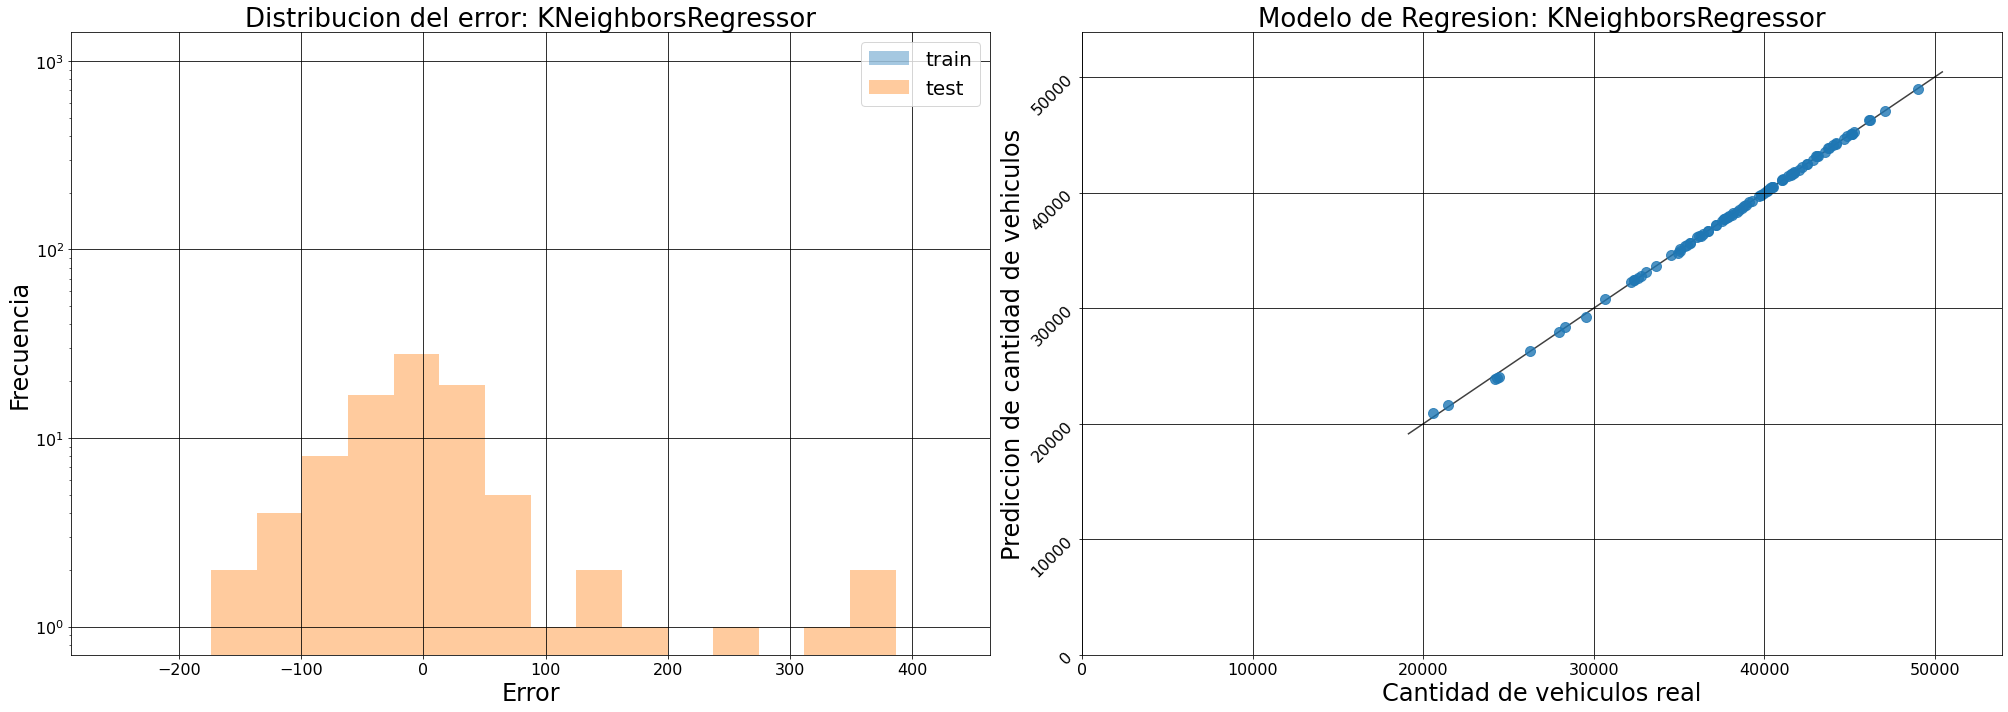

Modelo: DecisionTreeRegressor
Error Medio Absoluto en Train: 214.21136590229312
Error Medio Absoluto en Test: 678.0434782608696


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


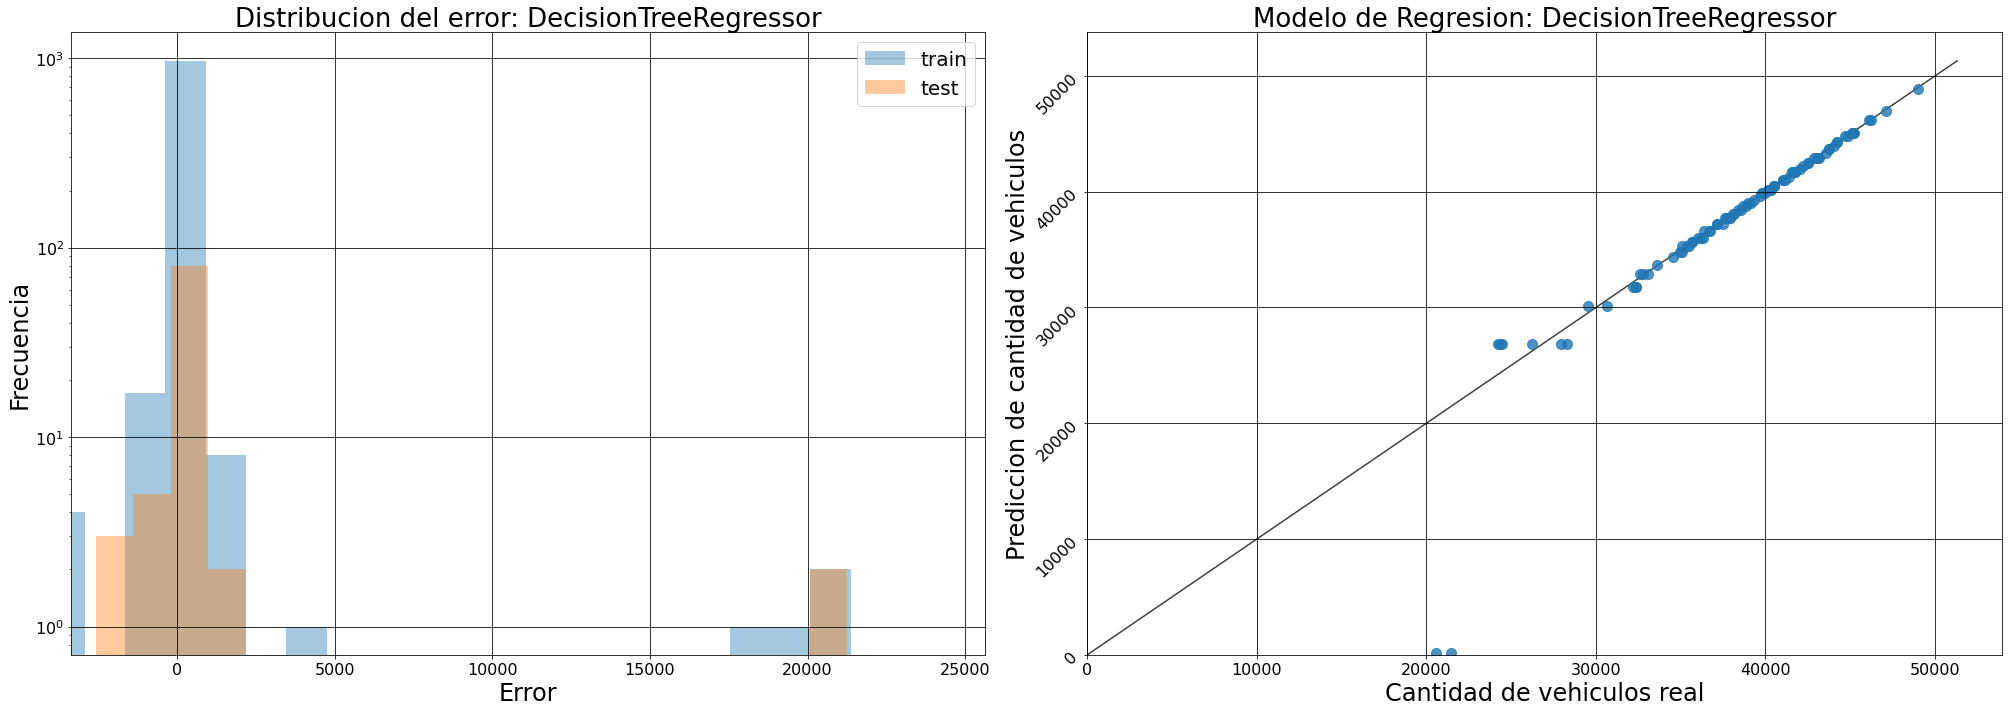

Modelo: XGBRegressor
Error Medio Absoluto en Train: 23.46847119336114
Error Medio Absoluto en Test: 95.85591457201087


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


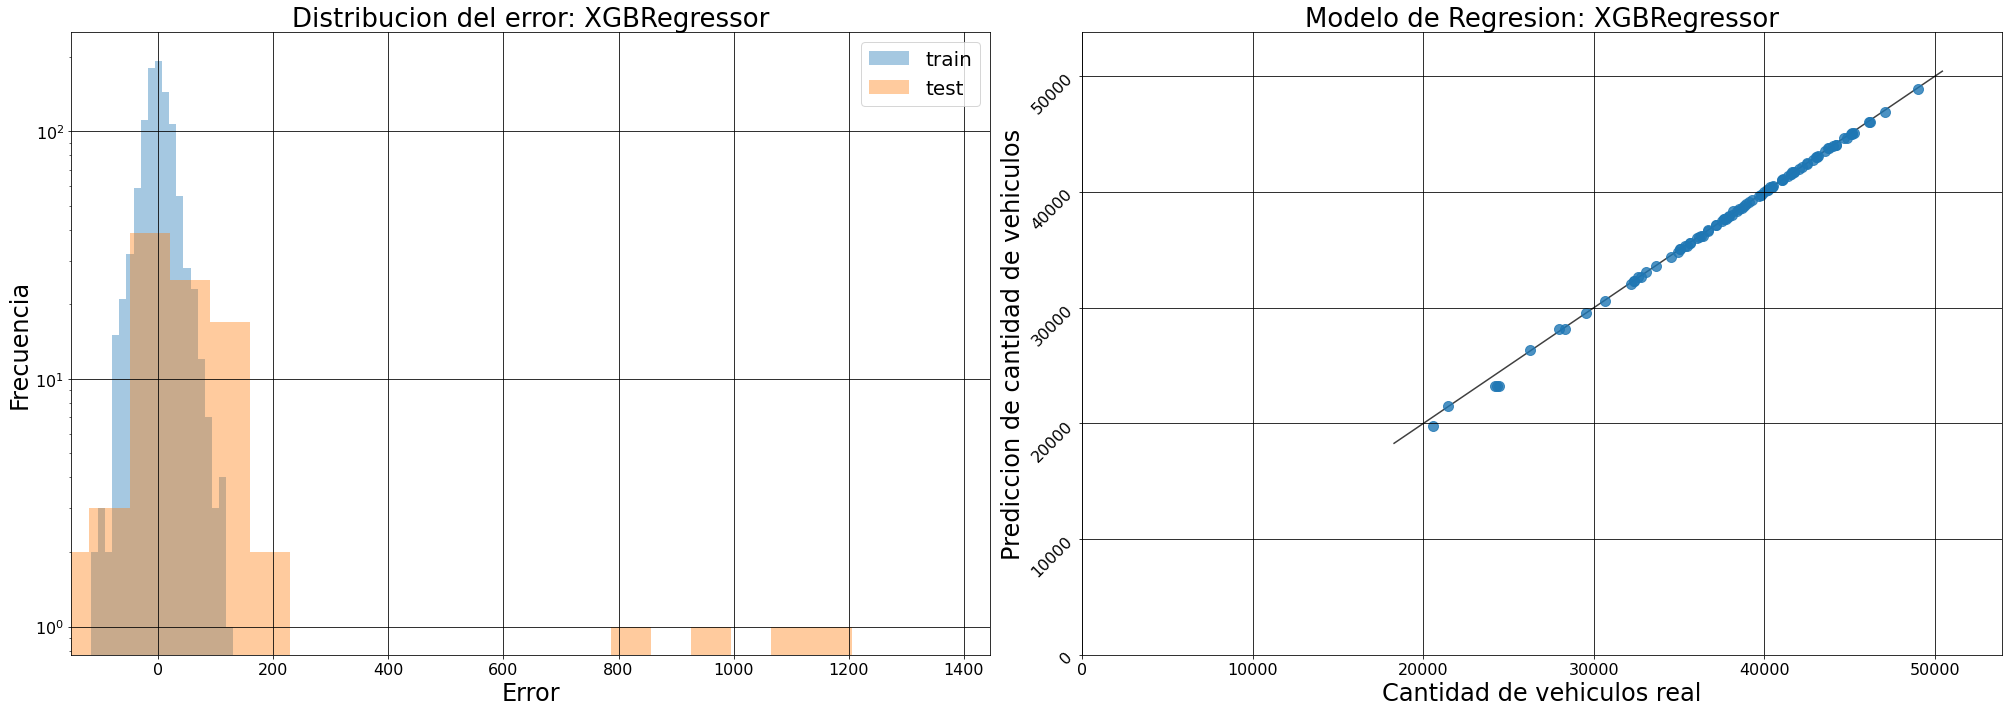

In [226]:
modelos = ["KNeighborsRegressor","DecisionTreeRegressor","XGBRegressor"]

for i, model in enumerate([model_1, model_2, model_3]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    
    print(f"Modelo: {modelos[i]}")

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    print(f"Error Medio Absoluto en Train: {mae_train}")
    print(f"Error Medio Absoluto en Test: {mae_test}")
    
    
    plt.figure(figsize = (28,10))
    plt.subplot(1,2,1)
    
    sns.distplot(y_train - y_train_pred,
                 bins = 20,
                 label = "train",
                 hist = True,
                 kde = False,
                 norm_hist = False)
    
    sns.distplot(y_test - y_test_pred,
                 bins = 20,
                 label = "test",
                 hist = True,
                 kde = False, 
                 norm_hist = False)
    
    plt.xlabel("Error", fontsize = 24)
    plt.xticks(fontsize = 16)
    
    plt.xlim((y_train - y_train_pred).append(y_test - y_test_pred).min() * 0.8, 
             (y_train - y_train_pred).append(y_test - y_test_pred).max() * 1.2)
    
    plt.ylabel("Frecuencia", fontsize = 24)
    plt.yscale("log")
    plt.yticks(fontsize = 16)
    plt.legend(fontsize = 20)
    plt.title("Distribucion del error: " + modelos[i], fontsize = 26)
    plt.grid(c = "k")


    ax = plt.subplot(1,2,2)
    ax.scatter(x = y_test, y = y_test_pred, s = 100, alpha = 0.8)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
    plt.xlabel("Cantidad de vehiculos real", fontsize = 24)
    plt.xticks(fontsize = 16)
    plt.ylabel("Prediccion de cantidad de vehiculos", fontsize = 24)
    plt.yticks(rotation = 45, fontsize = 16)
    plt.title("Modelo de Regresion: " + modelos[i], fontsize = 26)
    
    plt.xlim(0, y_test.max() * 1.1)
    plt.ylim(0, y_test_pred.max() * 1.1)
    plt.grid(c = "k")
    
    plt.tight_layout()
    plt.show()

### Estudio Desempeño de los modelos en el tiempo

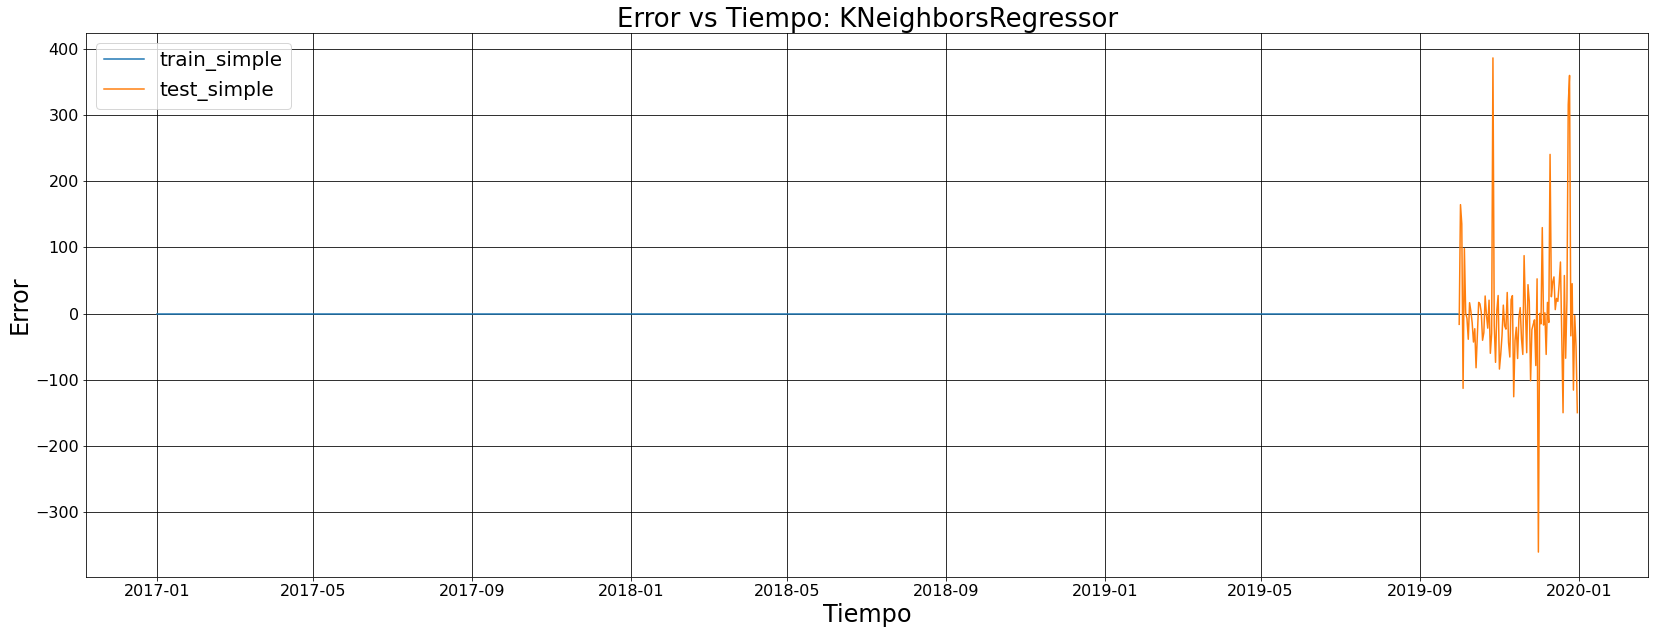

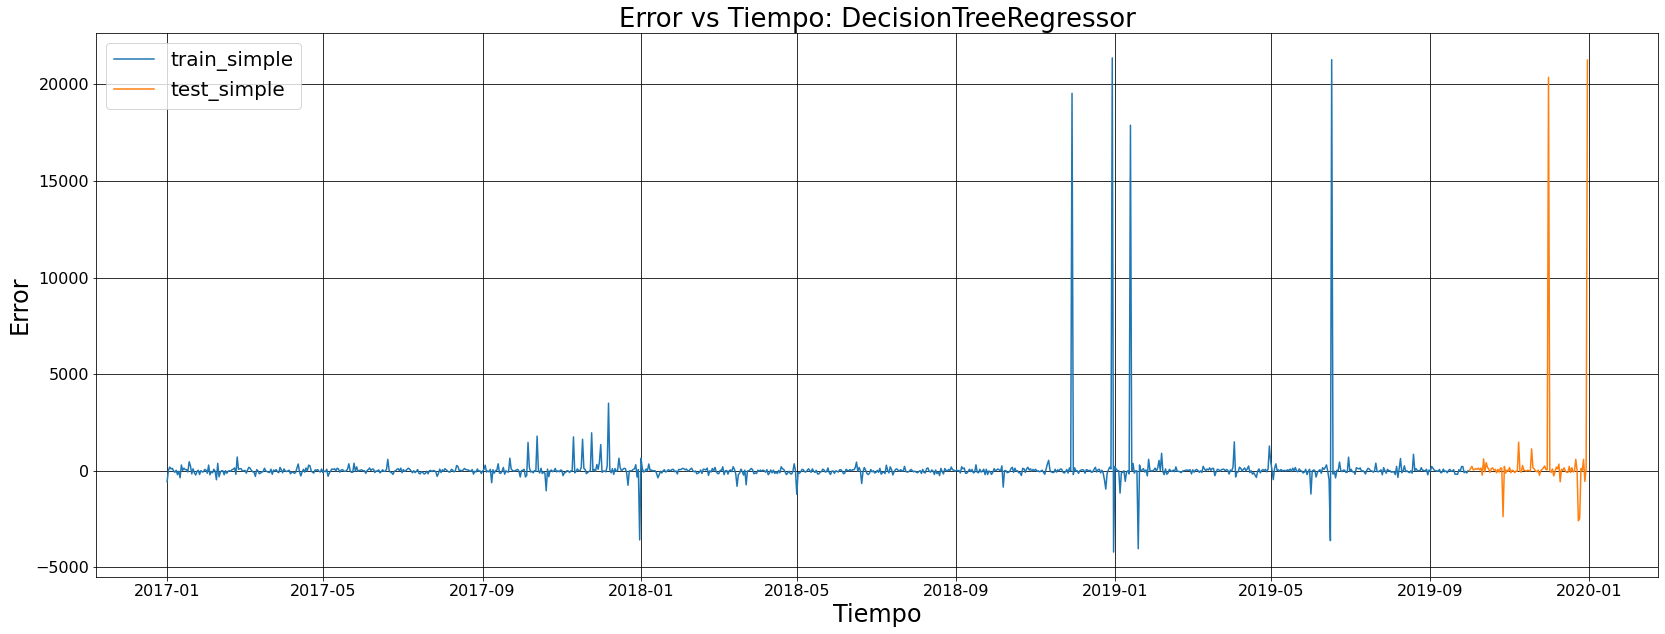

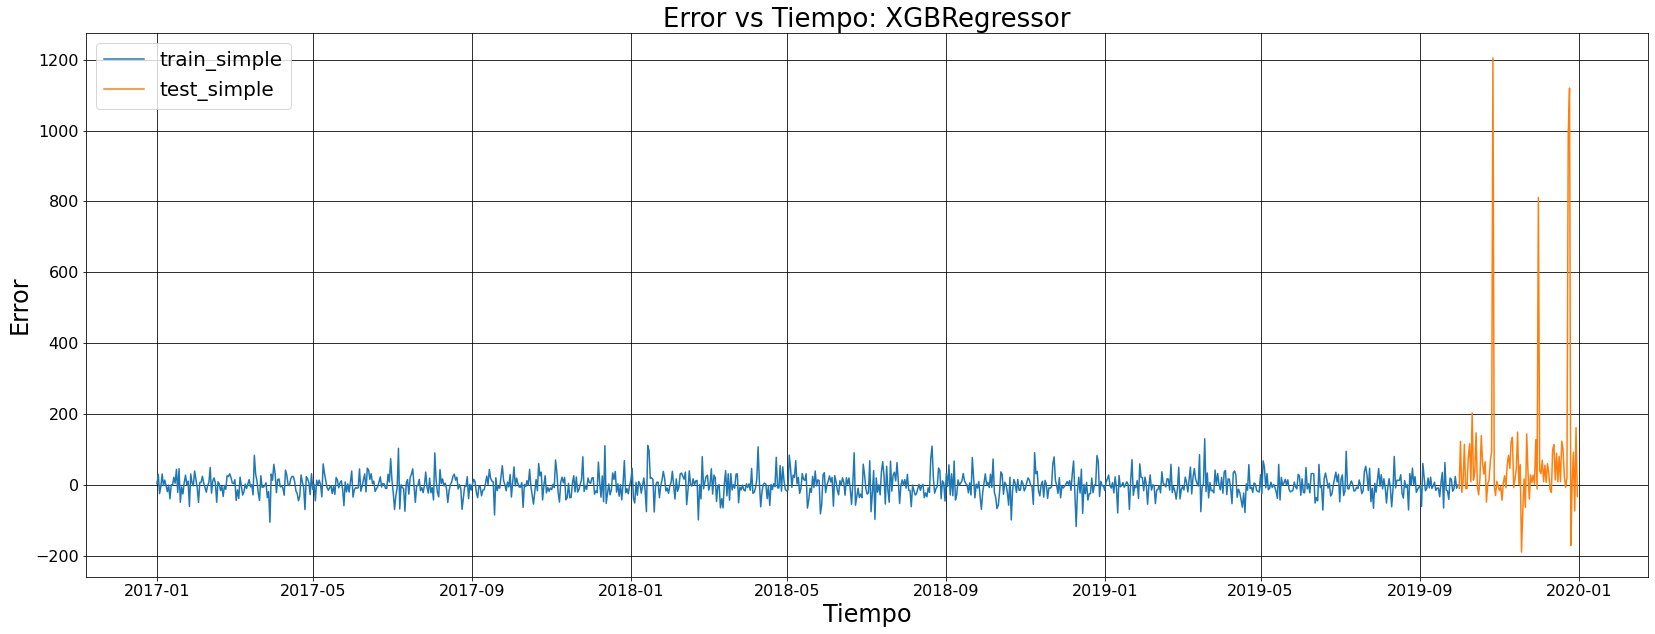

In [227]:
# Analizo los errores en el tiempo

modelos = ["KNeighborsRegressor","DecisionTreeRegressor","XGBRegressor"]

for i, model in enumerate([model_1, model_2, model_3]):
        
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
        
    df_aux_train = pd.DataFrame(data = {"error" : (y_train - y_train_pred),
                                        "fecha" : X_train["fecha_numeros"].apply(dt.datetime.fromordinal)
                                        }
                               )

    df_aux_test = pd.DataFrame(data = {"error" : (y_test - y_test_pred),
                                       "fecha" : X_test["fecha_numeros"].apply(dt.datetime.fromordinal)
                                      }
                              )

    plt.figure(figsize = (28,10))
    
    #TRAIN
    
    sns.lineplot(data = df_aux_train, 
                    x = "fecha",
                    y = "error",
                    label = "train_simple")
       
    #TEST
    
    sns.lineplot(data = df_aux_test, 
                 x = "fecha",
                 y = "error",
                 label = "test_simple")    
    
    plt.title("Error vs Tiempo: " + modelos[i], fontsize = 26)
        
    plt.xlabel("Tiempo", fontsize = 24)
    plt.xticks(fontsize = 16)
    plt.ylabel("Error", fontsize = 24)
    plt.yticks(fontsize = 16)
    plt.legend(fontsize = 20)
        
    plt.grid(c = "k")

### Conclusiones:




Si hubiese iniciado el proyecto con un modelo mas sencillo los resultados iniciales hubiesen sido peores. Los modelos más simples no logran capturar la complejidad de los atributos desarrollados con anterioridad y al convivir datos muy diversos los errores de las métricas escogidas se incrementaron.

2) ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?

In [228]:
dataset = pd.concat([data_2019, data_2018, data_2017]).reset_index(drop = True)

#Paso a formato datetime el feature "fecha"
dataset["fecha"] = pd.to_datetime(dataset["fecha"])

#Unifico el tipo de pago de tarjeta de discapacidad, reemplazando la clasificacion vieja (2017 y 2018) con la mas reciente
ind_disc = dataset[dataset["forma_pago"] == "TARJETA DISCAPACIDAD"].index
dataset.loc[ind_disc,"forma_pago"] = "T. DISCAPACIDAD"

#Unifico la estacion de peaje Dellepiane
ind_della = dataset[dataset["estacion"].isin(['Dellepiane Centro', 'Dellepiane Liniers'])].index
dataset.loc[ind_della,"estacion"] = "Dellepiane"

#Corrijo la estacion de peaje Alberdi a Alberti
ind_della = dataset[dataset["estacion"] == "Alberdi"].index
dataset.loc[ind_della,"estacion"] = "Alberti"

In [229]:
analisis = dataset.groupby(by = ["fecha", "estacion"], as_index = False)["cantidad_pasos"].sum()

In [230]:
analisis.head()

fecha    estacion  cantidad_pasos
0 2017-01-01     Alberti            9638
1 2017-01-01  Avellaneda           99631
2 2017-01-01  Dellepiane           62026
3 2017-01-01       Illia           45478
4 2017-01-01      Retiro            2532

In [231]:
estacion_dict = {}

for estacion in analisis.estacion.unique():
    estacion_dict[estacion] = analisis[analisis["estacion"] == estacion][["fecha","cantidad_pasos"]].resample('M', on = 'fecha').sum().reset_index()
    estacion_dict[estacion]["estacion"] = pd.Series()
    estacion_dict[estacion]["estacion"] = estacion_dict[estacion]["estacion"].fillna(value = estacion)
    
estacion_dict.keys()

<ipython-input-231-99270cfbd8fb>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  estacion_dict[estacion]["estacion"] = pd.Series()


dict_keys(['Alberti', 'Avellaneda', 'Dellepiane', 'Illia', 'Retiro', 'Salguero', 'Sarmiento', 'PDB'])

In [232]:
# Por algun motivo, no pude lograr iterar el diccionario para consutruir un DataFrame que tome todo el resampleo por estacion
# En consecuencia, tuve que aplicar append para cada key-value consecutivamente.

df_flujo_mensual = pd.DataFrame.from_dict(data = estacion_dict["Alberti"]).append(
    pd.DataFrame.from_dict(data = estacion_dict["Avellaneda"])).append(
    pd.DataFrame.from_dict(data = estacion_dict["Dellepiane"])).append(
    pd.DataFrame.from_dict(data = estacion_dict["Illia"])).append(
    pd.DataFrame.from_dict(data = estacion_dict["Retiro"])).append(
    pd.DataFrame.from_dict(data = estacion_dict["Salguero"])).append(
    pd.DataFrame.from_dict(data = estacion_dict["Sarmiento"])).append(
    pd.DataFrame.from_dict(data = estacion_dict["PDB"]))

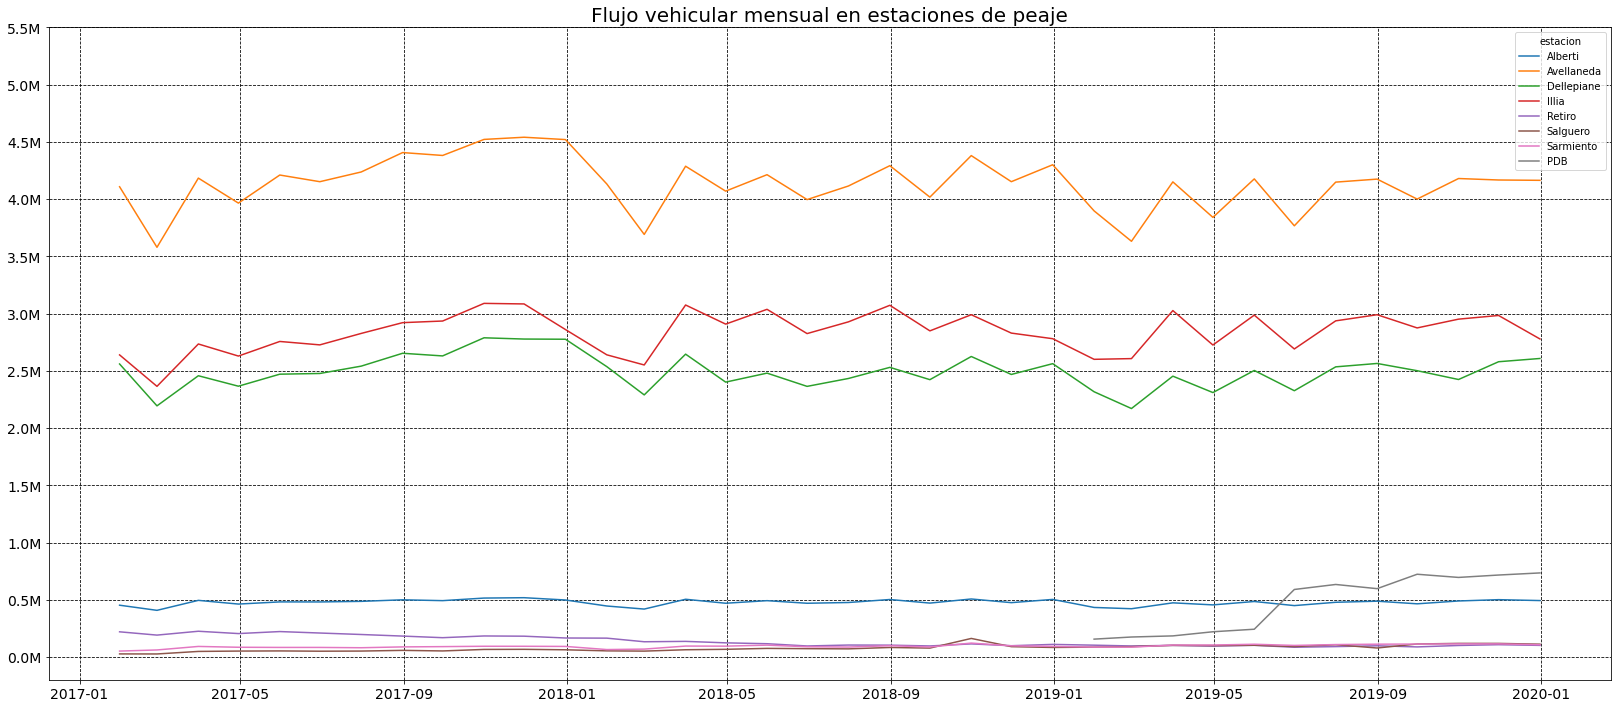

In [233]:
_ = plt.figure(figsize = (28,12))

_ = sns.lineplot(x = "fecha",
                 y = "cantidad_pasos",
                 data = df_flujo_mensual,
                 hue = "estacion")

_ = plt.ylabel("")
_ = plt.yticks((range(0,6*10**6,5*10**5)),
               (str(i/10) + "M" for i in range(0,60,5)),
               fontsize = 14)

_ = plt.xlabel("")
_ = plt.xticks(fontsize = 14)

_ = plt.title("Flujo vehicular mensual en estaciones de peaje", 
              fontsize = 20)

_ = plt.grid(axis = "both", 
             c = "k",
             linestyle = "--")

## Analisis de las series de tiempo entre estaciones de peajes:

* Avellaneda es el peaje con mayor circulacion, luego le siguen Dellepiane e Illia
* Los de menor circulacion son Salguero, Sarmiento y Retiro. Este ultimo podemos notar que va decreciendo levemente hasta mantener niveles de circulacion casi iguales a Salguero y Sarmiento.
* PDB es el peaje mas nuevo y podemos notar una tendencia creciente en su serie.
* Podemos notar que los comportamientos de las series de tiempo en los puntos de peaje de mayor circulacion son similares (los crecimientos y decrecimientos a lo largo de la serie se replican en la mayoria de sus puntos)

Recordando que al inicio del notebook analizamos la cantidad de vehiculos que circularon por estos peajes. Por todos ellos predominaron los vehiculos livianos, con excepcion del peaje PDB.

Seria interesante obtener mas informacion sobre este peaje en particular.

No es dificil encontrar en google noticias al respecto de por que destaca que predominen los pesados:

*Paseo del Bajo a la Ciudad, es la primera autopista para tránsito pesado y Ómnibus de Transporte de Pasajeros de Larga Distancia.*

Fuente: https://www.buenosaires.gob.ar/movilidad/noticias/paseo-del-bajo-como-sera-la-circulacion-para-el-transito-liviano. La nota además explica como debe circular un vehiculo liviano

*(...) tiene cuatro carriles exclusivos para camiones y micros de larga distancia, lo que permitirá circular más rápido hasta los accesos directos al puerto y a la Terminal de Retiro. Los camiones podrán hacer en aproximadamente 10 minutos un trayecto que les llevaba más de una hora. (...)*

Fuente: https://www.ausa.com.ar/novedades/paseodelbajo/. La noticia es la pagina oficial de autopistas urbanas además agrega más informacion al respecto sobre este ultimo peaje concretado en 2019.


3) ¿Hay algo que te gustaría investigar o probar?

Poder comprender mejor como incluir casos complejos de outliers en el modelado. Las alternativas que se me ocurren:
* Aplicar escalamientos especificos en los datos que regularicen la tendencia y desestacionalicen la serie
* Usar este paso previo para proceder a identificar los outliers (con regla de iqr o 3sigma) e incluirlos como un nuevo atributo codificado (OHE) en los datos de entrenamiento.